## Notes
* This notebook has implementations of `Backprop` with binary spike feature vectors obtained from the `SPIKEFLOW`. Here, we will use tf.data API. Here the shape of the inputs is `[None, n_input]` instead of `[n_input, None]`. We had to do this because nested elements in `from_tensor_slices` must have the same dimension in 0th rank [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). Everytime an iterator `iter = dataset.make_initializable_iterator()` gets initialized, the dataset is randomly shuffled so we need not shuffle again, [see](https://stackoverflow.com/questions/49579684/what-is-the-difference-between-dataset-from-tensors-and-dataset-from-tensor-slic). We also use `z_3 = tf.floor(z_3)`. Surrogate gradients with one step is used. (one sided)

* Here, error in the hidden layer, $\delta^{2}$ is implemented as:
$ \delta^{2} = W^{3T}\delta^{(3)}\odot\sigma^{'}(z^{(2)}) \tag{1}$
* $\sigma^{'}(z^{(2)})$ is approximated with a surrogate. (See section 6)
* It also takes care of catastrophic forgetting by using synaptic intelligence.
* He initialization without AR1 gives lesser final accuracy than Trunc init because in He the gradients don't suffer from dimnishing.
### References
* [Neural Nets](http://neuralnetworksanddeeplearning.com/chap3.html)
* [Randombackprop](https://github.com/xuexue/randombp/blob/master/randombp.py)
* [Randombackprop](https://github.com/sangyi92/feedback_alignment/blob/master/RFA.ipynb)
* [Backprop](http://blog.aloni.org/posts/backprop-with-tensorflow/)
* [Initializers](https://towardsdatascience.com/hyper-parameters-in-action-part-ii-weight-initializers-35aee1a28404)
* [Dropout](https://github.com/pinae/TensorFlow-MNIST-example/blob/master/fully-connected.py)
* [Softmax](https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits)
* [SoftmaxLogits](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
* [TF memory leaks when  assigning in loop](https://github.com/tensorflow/tensorflow/issues/4151)

In [1]:
import os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from IPython.display import display, HTML
tf.compat.v2.random.set_seed(0)
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.client import timeline
import h5py, pickle
from keras.utils.np_utils import to_categorical 
import numpy as np
import pandas as pd
import DATA_Loader
import seaborn as sb
import theano, random, sys, time

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)
tf

1.14.0


<module 'tensorflow' from '/home/ruthvik/.local/lib/python2.7/site-packages/tensorflow/__init__.pyc'>

## Hide code

In [3]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Plots

### Large

In [4]:
mpl.rcParams['figure.figsize'] = 15,10
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['legend.fontsize'] = 25

### Small

In [5]:
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = 3.75,3
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

## Load the data 

In [6]:
filename = '../../spiking_networks/train_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_train_images = hf['pool1_spike_features'][:].astype(np.int8)
#@@emnist_train_images[np.where(emnist_train_images>=1)] = 1

filehandle = open('../../spiking_networks/train_y.pkl','rb')
emnist_train_labels = pickle.load(filehandle).astype(np.int).tolist()
filehandle.close()
emnist_train_labels = np.array(emnist_train_labels)
print('Total train features:{}'.format(emnist_train_images.shape[0]))

#### LOAD TEST IMAGES AND LABELS
filename = '../../spiking_networks/test_pool1_spike_features_inh_False_conv1maps_30.h5'
with h5py.File(filename, 'r') as hf:
    emnist_test_images = hf['pool1_spike_features'][:].astype(np.int8)
#@@emnist_test_images[np.where(emnist_test_images>=1)] = 1
print('Total test features:{}'.format(emnist_test_images.shape[0]))

filehandle = open('../../spiking_networks/test_y.pkl','rb')
emnist_test_labels = pickle.load(filehandle).astype(np.int)
filehandle.close()
emnist_test_labels = np.array(emnist_test_labels)

#### LOAD TRAIN AND VALIDATION DATA AND LABELS
train_images = emnist_train_images
train_labels = emnist_train_labels
train_labels = np.array(train_labels)
test_images = emnist_test_images
test_labels = emnist_test_labels
num_classes=10

Total train features:60000
Total test features:10000


In [7]:
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}

In [8]:
BATCH_SIZE = 10
#### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TRAIN DATA
def extract_class_data(start=0, stop=1):
    set1_locs = np.where((train_labels>=start) & (train_labels<=stop))[0]
    train_labels_set1 = to_categorical(train_labels[set1_locs], num_classes=num_classes)
    train_images_set1 = train_images[set1_locs,:]
    n_images = len(train_images_set1)

    #### EXTRACT REQUIRED LOCATIONS OF 0 TO 5 FOR TEST DATA
    set1_locs = np.where((test_labels>=start) & (test_labels<=stop))[0]
    test_labels_set1 = to_categorical(test_labels[set1_locs], num_classes=num_classes)
    test_images_set1 = test_images[set1_locs,:]
    print('Test features:{}'.format(test_images_set1.shape))
    print('Length of test labels:{}'.format(test_labels_set1.shape[0]))
    test_data_set1 = (test_images_set1, test_labels_set1)
    


    train_images_set1 = train_images_set1[int(0.09*n_images):]
    train_labels_set1 = train_labels_set1[int(0.09*n_images):]
    print('Train features:{}'.format(train_images_set1.shape))
    print('Length of train labels:{}'.format(train_labels_set1.shape[0]))
    train_data_set1 = (train_images_set1, train_labels_set1)

    valid_labels_set1 = train_labels_set1[0:int(0.09*n_images)]
    valid_images_set1 = train_images_set1[0:int(0.09*n_images)]
    print('Valid features:{}'.format(valid_images_set1.shape))
    print('Length of valid labels:{}'.format(valid_labels_set1.shape[0]))
    valid_data_set1 = (valid_images_set1, valid_labels_set1)
    
    n_train_set1 = train_labels_set1.shape[0]
    n_test_set1 = test_labels_set1.shape[0]
    n_valid_set1 = valid_labels_set1.shape[0]

    return train_data_set1, valid_data_set1, test_data_set1

## Start a session

In [9]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess= tf.InteractiveSession(config=config)
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()

$tanh(x) = \frac{(e^{x} – e^{-x})}{(e^{x} + e^{-x})}$

$d\frac{tanh(x)}{dx} = 1 – (tanh(x))^{2}$

$\sigma(x) = \frac{1.0}{1 + e^{-x}}$

$d\frac{\sigma(x)}{dx} = \sigma(x)*(1 - \sigma(x))$

## Setup the network graph

In [10]:
n_input = 3630
n_middle = 1024
n_out = 10
batch_size = tf.placeholder(tf.int64, name='batch_size') 
a_1 = tf.placeholder(tf.float32, [None, n_input], name = 'Input_batch')
y = tf.placeholder(tf.float32, [None, n_out], name = 'output_batch')
dataset = tf.data.Dataset.from_tensor_slices((a_1, y))
#dataset = dataset.shuffle(buffer_size=len(all_train_labels), reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size)
iter = dataset.make_initializable_iterator()
features, labels = iter.get_next()

drop_out = tf.placeholder(tf.float32)
tau = tf.placeholder(tf.float32)
set1_mask = tf.placeholder(tf.float32, [10], name='mask')
eta = tf.placeholder(tf.float32)
n_tot = tf.placeholder(tf.float32)
lmbda = tf.placeholder(tf.float32, name='lambda')
with tf.name_scope('hid_lyr_w_b'):  ###havier or glorot initialization
    low = -4*tf.math.sqrt(6.0/(n_input + n_middle)) # use 4 for sigmoid, 1 for tanh activation 
    high = 4*tf.math.sqrt(6.0/(n_input + n_middle))
    
    low = -tf.math.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
    high = tf.math.sqrt(2.0/(n_input))
    
    w_2 = tf.Variable(tf.random_uniform(shape=[n_input,n_middle],minval=low,maxval=high), name = 'W_2')
    #w_2 = tf.Variable(tf.truncated_normal(shape=[n_input,n_middle], stddev=0.01),name = 'W_2')
    w_2_update_placeholder = tf.placeholder(w_2.dtype, shape=w_2.get_shape(),name='update_w2')
    w_2_update_op = w_2.assign(w_2_update_placeholder)
    tf.summary.histogram('w_2', w_2)
    
    b_2 = tf.Variable(tf.zeros([1,n_middle]), name = 'b_2')
    b_2_update_placeholder = tf.placeholder(b_2.dtype, shape=b_2.get_shape(),name='update_b2')
    b_2_update_op = b_2.assign(b_2_update_placeholder)
    tf.summary.histogram('b_2', b_2)
    
    
    w2_grad_accum = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32),name='w2_grad_accum')
    w2_grad_accum_update_placeholder=tf.placeholder(w2_grad_accum.dtype, shape=w2_grad_accum.get_shape(),
                                            name='update_w2_grad_accum')
    w2_grad_accum_update_op = w2_grad_accum.assign(w2_grad_accum_update_placeholder)
    
    
    b2_grad_accum = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='b2_grad_accum')
    b2_grad_accum_update_placeholder=tf.placeholder(b2_grad_accum.dtype,shape=b2_grad_accum.get_shape(),
                                            name='update_b2_grad_accum')
    b2_grad_accum_update_op = b2_grad_accum.assign(b2_grad_accum_update_placeholder)
    
    
    big_omeg_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='omeg_w2')
    tf.summary.histogram('big_omeg_w2', big_omeg_w2)
    big_omeg_w2_update_placeholder = tf.placeholder(big_omeg_w2.dtype, shape=big_omeg_w2.get_shape(),
                                                    name='update_big_omeg_w2')
    big_omeg_w2_update_op = big_omeg_w2.assign(big_omeg_w2_update_placeholder)
    
    
    big_omeg_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='omeg_b2')
    tf.summary.histogram('big_omeg_b2', big_omeg_b2)
    big_omeg_b2_update_placeholder = tf.placeholder(big_omeg_b2.dtype, shape=big_omeg_b2.get_shape(),
                                                    name='update_big_omeg_b2')
    big_omeg_b2_update_op = big_omeg_b2.assign(big_omeg_b2_update_placeholder)
    
    
    star_w2 = tf.Variable(np.zeros(shape=[n_input,n_middle], dtype=np.float32), name='star_w2')
    star_w2_update_placeholder = tf.placeholder(star_w2.dtype, shape=star_w2.get_shape(),
                                                name='update_star_w2')
    star_w2_update_op = star_w2.assign(star_w2_update_placeholder)
    
    
    star_b2 = tf.Variable(np.zeros(shape=[1,n_middle], dtype=np.float32), name='star_b2')
    star_b2_update_placeholder = tf.placeholder(star_b2.dtype, shape=star_b2.get_shape(),
                                                name='update_star_b2')
    star_b2_update_op = star_b2.assign(star_b2_update_placeholder)
with tf.name_scope('op_lyr_w_b'):
    
    low = -tf.math.sqrt(2.0/(n_middle))
    high = tf.math.sqrt(2.0/(n_middle))
    #w_3 = tf.Variable(tf.random_uniform(shape=[n_middle,10],minval=low,maxval=high), name = 'W_3')
    #w_3 = tf.Variable(tf.truncated_normal(shape=[n_middle,n_out], stddev=0.01),name = 'W_3')
    w_3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32),name = 'W_3')
    tf.summary.histogram('w_3', w_3)
    w_3_update_placeholder = tf.placeholder(w_3.dtype, shape=w_3.get_shape(),name='update_w3')
    w_3_update_op = w_3.assign(w_3_update_placeholder)
    
    b_3 = tf.Variable(tf.zeros([1,n_out]), name = 'b_3')
    tf.summary.histogram('b_3', b_3)
    b_3_update_placeholder = tf.placeholder(b_3.dtype, shape=b_3.get_shape(),name='update_b3')
    b_3_update_op = b_3.assign(b_3_update_placeholder)
    
    w3_grad_accum = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='w3_grad_accum')
    b3_grad_accum = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='b3_grad_accum')
    
    big_omeg_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='omeg_w3')
    tf.summary.histogram('big_omeg_w3', big_omeg_w3)
    big_omeg_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='omeg_b3')
    tf.summary.histogram('big_omeg_b3', big_omeg_b3)
    
    star_w3 = tf.Variable(np.zeros(shape=[n_middle,n_out], dtype=np.float32), name='star_w3')
    star_b3 = tf.Variable(np.zeros(shape=[1,n_out], dtype=np.float32), name='star_b3')

def sigma(x):
    return tf.math.divide(tf.constant(1.0),
                  tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
def tanh(x):
    return tf.math.divide(tf.subtract(tf.exp(x), tf.exp(tf.negative(x))), 
                          tf.add(tf.exp(x), tf.exp(tf.negative(x))) )

def sigmaprime(x):
    return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

def tanhprime(x):
    return tf.subtract(tf.constant(1.0),tf.square(tanh(x)))

def spkNeuron(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def ReLU(x):
    return tf.maximum(0.0, x)

def ReLUprime(x):
    return tf.where(tf.greater_equal(x,0.0), tf.ones_like(x), 
                        tf.zeros_like(x))

def spkPrime1(x):
    l1_bound_higher = tf.greater_equal(x,-0/4)
    r1_bound_lesser = tf.less_equal(x,tau/4) 
    grad_one = tf.where(tf.logical_and(l1_bound_higher,r1_bound_lesser), tf.ones_like(x), tf.zeros_like(x))
    return grad_one

def firstLyrSpks(x):
    return tf.where(tf.greater_equal(x,1.0), tf.ones_like(x), 
                        tf.zeros_like(x))

    
with tf.name_scope('hid_lyr_acti'):
    z_2 = tf.add(tf.matmul(features,w_2,name = 'w_2xa_1'), b_2, name = 'z_2')
    locs_to_drop = tf.random.categorical(tf.math.log([[1.0-drop_out, drop_out]]), tf.size(z_2))
    locs_to_drop = tf.reshape(locs_to_drop, tf.shape(z_2))
    z_2 = tf.where(locs_to_drop>0,-tf.ones_like(z_2),z_2, 'drop_out_app')
    tf.summary.histogram('z_2', z_2)
    a_2 = ReLU(z_2)
    #@@a_2 = spkNeuron(z_2)
    tf.summary.histogram('a_2', a_2)
with tf.name_scope('op_lyr_acti'):
    z_3 = tf.add(tf.matmul(a_2,w_3, name = 'w_3xa_2'),b_3, name = 'z_3')
    #@@z_3 = tf.floor(z_3)
    #z_3 = tf.subtract(tf.reduce_max(z_3),z_3, name = 'inhibition')
    tf.summary.histogram('z_3', z_3)
    a_3 = tf.cast(tf.nn.softmax(z_3,axis=1), tf.float32)
    a_3 = tf.multiply(a_3, set1_mask, name='masking')
    tf.summary.histogram('a_3', a_3)
    ##COMMENT THE ABOVE LINE AND UNCOMMENT BELOW LINE IF YOU WANT SOFTMAX
    #a_3 = tf.nn.softmax(z_3,axis=1) ##AXIS IS VERY IMPORTANT!!! axis=1 INDICATES THE CLASSES AS y IS [None,10]

#cost = tf.reduce_mean(-tf.reduce_sum((y*tf.log(a_3) +tf.log(1-a_3)*(1-y)) ,axis=0), name = 'cost_calc') WORKS, USE BELOW
with tf.name_scope('cost_calc'):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels,logits=z_3,axis=1),
                          name = 'cost_calc')#WORKS
        ##COMMENT BELOW LINES IF YOU WANT quadratic
    #@dc_da = tf.multiply(-tf.subtract(labels,a_3, name = 'y_minus_a_3'), mask)
    #@cost = tf.reduce_mean(tf.reduce_sum((1/2.0)*tf.square(dc_da),axis=1), name = 'cost_calc')
    tf.summary.scalar('cost', cost)

with tf.name_scope('op_lyr_grad'):
    #@d_z_3 = tf.multiply(-tf.subtract(labels,a_3, name = 'delta3'), mask, name='masking')
    d_z_3 = -tf.subtract(labels,a_3, name = 'delta3')
    #d_z_3 = tf.multiply(dc_da,a_3, name = 'delta3')
    d_b_3 = tf.expand_dims(tf.reduce_mean(d_z_3, axis=[0]), axis=0)
    tf.summary.histogram('d_b_3', d_b_3)
    d_w_3 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(a_2),d_z_3), 
                        name='delta_w3')
    tf.summary.histogram('d_w_3', d_w_3)
    
with tf.name_scope('hid_lyr_grad'):
    d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), ReLUprime(z_2),
                        name = 'delta2')
    #@@d_z_2 = tf.multiply(tf.matmul(d_z_3,tf.transpose(w_3), name = 'w_3Txdelta3'), spkPrime1(z_2),
    #@@                    name = 'delta2')
    #d_z_2 = tf.matmul(d_z_3,tf.transpose(w_3), name = 'delta2')
    d_b_2 = tf.expand_dims(tf.reduce_mean(d_z_2, axis=[0]), axis=0)
    tf.summary.histogram('d_b_2', d_b_2)
    d_w_2 = tf.multiply(1/tf.cast(batch_size, tf.float32),
                        tf.matmul(tf.transpose(features),d_z_2), 
                        name='delta_w2')
    tf.summary.histogram('d_w_2', d_w_2)
    
omega_step=[tf.assign(w2_grad_accum,
                      tf.add(w2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot, tf.square(d_w_2))),
                     name='update_omeg_w2'),
            tf.assign(b2_grad_accum,
                      tf.add(b2_grad_accum,tf.multiply(eta*eta*lmbda/n_tot,tf.square(d_b_2))),
                     name='update_omeg_b2')
]

step = [tf.assign(w_2,
                  tf.subtract(w_2, (eta*d_w_2+big_omeg_w2*(w_2-star_w2))),name='update_w_2'),
        tf.assign(b_2,
                  tf.subtract(b_2,(eta*d_b_2+big_omeg_b2*(b_2-star_b2))),name='update_b_2'),
        
        tf.assign(w_3,
                  tf.subtract(w_3, (eta*d_w_3+big_omeg_w3*(w_3-star_w3))),name='update_w_3'),
        tf.assign(b_3,
                  tf.subtract(b_3,(eta*d_b_3+big_omeg_b3*(b_3-star_b3))),name='update_b_3')    
]
with tf.name_scope('acc_calc'):
    predictions = tf.argmax(a_3, 1)
    acct_mat = tf.equal(tf.argmax(a_3, 1), tf.argmax(labels, 1))
    acct_res = tf.reduce_mean(tf.cast(acct_mat, tf.float32))
    tf.summary.scalar('accuracy', acct_res)

init_op = tf.global_variables_initializer()

### Init the writer with $\lambda$s (0, 6.75)e4

In [10]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_16lmbdas_ar1_3lyrs_he1', sess.graph)

### Generate $\lambda$s 

In [11]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=0.0, high=6.75, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[3.66798336 1.87899335 2.86549374 5.70223889 0.03185228 0.82059157
 4.52755632 5.5745061  0.92276948 3.88187997 6.01642319 1.41211432
 1.25096548 0.73154401 1.48295808]
()
[  318.52279289  7315.44010634  8205.91565286  9227.69480373
 12509.65481963 14121.14324291 14829.58075219 18789.93349383
 28654.93737557 36679.83357089 38818.79973634 45275.56321906
 55745.06096959 57022.38893159 60164.23191608]
()
([0, 318.52279289064813, 7315.4401063372225, 8205.915652860209, 9227.694803734325, 12509.654819630066, 14121.143242910297, 14829.58075218697, 18789.933493831242, 28654.937375566486, 36679.833570890165, 38818.79973633937, 45275.563219057556, 55745.06096959071, 57022.388931593494, 60164.23191607782, 0, 318.52279289064813, 7315.4401063372225, 8205.915652860209, 9227.694803734325, 12509.654819630066, 14121.143242910297, 14829.58075218697, 18789.933493831242, 28654.937375566486, 36679.833570890165, 38818.79973633937, 45275.563219057556, 55745.06096959071, 57022.388931593494, 60164.23191607782,

### Generate random weights

In [12]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [13]:
np.array_equal(np_weights[0], np_weights[15])

True

In [14]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [15]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:128.926782846
Method 3 test accuracy:0.78979998827
Training with lmbda:318.522792891, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.151472836733 and training accuracy:0.965263545513
validation cost:0.147377207875 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.103573098779 and training accuracy:0.972713708878
validation cost:0.10354039818 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824561417103 and training accuracy:0.976066291332
validation cost:0.0788237005472 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692244544625 and training accuracy:0.979791402817
validation cost:0.0633962526917 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.059490069747 and training accuracy:0.983237087727
validation cost:0.0546964928508 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0533672757447 and training accuracy:0.985285878181
validation cost:0.0488668456674 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.047845300287 and train

Training on :(6, 7)
training cost:0.00988424755633 and training accuracy:0.999098062515
validation cost:0.0102383000776 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00883597321808 and training accuracy:0.999098062515
validation cost:0.00859887711704 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.652678013
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15136988461 and training accuracy:0.964984178543
validation cost:0.148393079638 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103539772332 and training accuracy:0.972434341908
validation cost:0.102035716176 and validation accuracy:0.9745

Training on :(6, 7)
training cost:0.0241417139769 and training accuracy:0.997745096684
validation cost:0.024643426761 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.019125521183 and training accuracy:0.998015701771
validation cost:0.0193141885102 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155282784253 and training accuracy:0.998286306858
validation cost:0.0160127580166 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129362177104 and training accuracy:0.9987372756
validation cost:0.0134760057554 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0111363437027 and training accuracy:0.998827457428
validation cost:0.0119296777993 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00985618215054 and training accuracy:0.999098062515
validation cost:0.0102367522195 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.008818378672 and tr

Training on :(4, 5)
Time taken:113.042720795
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0638147220016 and training accuracy:0.991431415081
validation cost:0.0632113814354 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0341522954404 and training accuracy:0.997294127941
validation cost:0.0343139767647 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242036189884 and training accuracy:0.997925519943
validation cost:0.0244181770831 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0189443659037 and training accuracy:0.997925519943
validation cost:0.0194039661437 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0236765164882 and training accuracy:0.997853636742
validation cost:0.0181112382561 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199190527201 and training accuracy:0.998341441154
validation cost:0.0147758722305 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0170001611114 and training accuracy:0.998341441154
validation cost:0.012366569601 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154246380553 and training accuracy:0.997853636742
validation cost:0.0112634934485 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0140442205593 and training accuracy:0.998146355152
validation cost:0.0101188346744 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.852390051
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989918932319 and training accuracy:0.991609752178
validation cost:0.091744363308 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0540550015867 and training accuracy:0.99287801981
validation cost:0.0476841889322 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0378479473293 and training accuracy:0.994634151459
validation cost:0.0303050130606 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0291291959584 and training accuracy:0.99658536911
validation cost:0.0222821366042 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0236534923315 and training accuracy:0.997853636742
validation cost:0.0180211886764 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199630148709 and training accuracy:0.998341441154
validation cost:0.0147312618792 and va

Training on :(2, 3)
training cost:0.0513002499938 and training accuracy:0.982910633087
validation cost:0.050956338644 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465157516301 and training accuracy:0.985637664795
validation cost:0.0468412488699 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0429077409208 and training accuracy:0.987273871899
validation cost:0.0414585731924 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:120.226647139
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989998206496 and training accuracy:0.991609752178
validation cost:0.0916628539562 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113364562392 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885561406612 and training accuracy:0.97309333086
validation cost:0.0924739167094 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0737892091274 and training accuracy:0.974184155464
validation cost:0.0788468718529 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0644843131304 and training accuracy:0.977365672588
validation cost:0.0673433989286 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0564459450543 and training accuracy:0.9806381464
validation cost:0.0583137944341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.051290538162 and training accuracy:0.982819736004
validation cost:0.0505184829235 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465791411698 and training acc

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.32477808
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168316215277 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113381847739 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885733067989 and training accuracy:0.97309333086
validation cost:0.0924739167094 and validation accuracy:0.9678308

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.446883917
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0483522415161 and training accuracy:0.986682832241
validation cost:0.0454847961664 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0445359498262 and training accuracy:0.987707197666
validation cost:0.0415289700031 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0408991575241 and training accuracy:0.988359093666
validation cost:0.0391653738916 and validation accuracy:0.992467045784
Training on :(8, 9)
Time taken:117.765272856
Method 3 test accuracy:0.783500015736
Training with lmbda:45275.5632191, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accura

Training on :(8, 9)
training cost:0.103793106973 and training accuracy:0.972061812878
validation cost:0.100347965956 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0822403505445 and training accuracy:0.975880026817
validation cost:0.0786894857883 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0691204816103 and training accuracy:0.979791402817
validation cost:0.0634864270687 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.060049276799 and training accuracy:0.983423352242
validation cost:0.0552336461842 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0533308051527 and training accuracy:0.985379040241
validation cost:0.050281342119 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0484713725746 and training accuracy:0.986589670181
validation cost:0.0455383434892 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.044461145997 and train

Training on :(6, 7)
training cost:0.00908142607659 and training accuracy:0.999098062515
validation cost:0.00878660194576 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.50276804
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153453245759 and training accuracy:0.964704811573
validation cost:0.148792400956 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103723436594 and training accuracy:0.972248077393
validation cost:0.100438781083 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.08261243999 and training accuracy:0.975600659847
validation cost:0.0797011777759 and validation accuracy:0.979284346

Training on :(6, 7)
training cost:0.0189655944705 and training accuracy:0.998105883598
validation cost:0.0190979149193 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0156312976032 and training accuracy:0.998196065426
validation cost:0.0163305066526 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131931435317 and training accuracy:0.9987372756
validation cost:0.0132242999971 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113306669518 and training accuracy:0.9987372756
validation cost:0.0116669768468 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.010006451048 and training accuracy:0.998917639256
validation cost:0.0103530595079 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00903469603509 and training accuracy:0.999098062515
validation cost:0.00874926149845 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.423624039
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639605298638 and training accuracy:0.991250991821
validation cost:0.0632901266217 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0342638269067 and training accuracy:0.997203946114
validation cost:0.0344367735088 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241608824581 and training accuracy:0.997925519943
validation cost:0.0248610507697 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0188748743385 and training accuracy:0.998105883598
validation cost:0.0191118586808 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.015687244013 and training accuracy:0.998196065426
validation cost:0.0163077488542 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131380818784 and training accuracy:0.9987372756
validation cost

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.212858915
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.100126810372 and training accuracy:0.991414606571
validation cost:0.0899167507887 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0545816011727 and training accuracy:0.993073165417
validation cost:0.0473784282804 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395342633128 and training accuracy:0.995024383068
validation cost:0.0320389680564 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0308352075517 and training accuracy:0.996292710304
validation cost:0.023763589561 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0251379031688 and training accuracy:0.996292710304
validation cost:0.0194510221481 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209808852524 and training accuracy:0.996975600719
validation cost:0.0149645060301 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183092635125 and training ac

training cost:0.0520863197744 and training accuracy:0.984910488129
validation cost:0.0572169162333 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474901460111 and training accuracy:0.986092150211
validation cost:0.0527139976621 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0441380105913 and training accuracy:0.987637460232
validation cost:0.048333209008 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:121.050490856
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0999810248613 and training accuracy:0.991804897785
validation cost:0.0896395370364 and validation accuracy:0.995064139366
Training o

Training on :(2, 3)
training cost:0.116149045527 and training accuracy:0.96891194582
validation cost:0.119582034647 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0904788970947 and training accuracy:0.974638640881
validation cost:0.0987908989191 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757415294647 and training accuracy:0.977092981339
validation cost:0.0860173627734 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662310495973 and training accuracy:0.979001879692
validation cost:0.0742289721966 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591368302703 and training accuracy:0.982183456421
validation cost:0.0654713883996 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0522213727236 and training accuracy:0.984819591045
validation cost:0.0572488605976 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0475407429039 and t

training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.286984921
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116149045527 and training accuracy:0.96891194582
validation cost:0.119582034647 and validation accuracy:0.964154422283
Training on

Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155

Training on :(8, 9)
Time taken:120.481314898
Method 3 test accuracy:0.791499972343
Training with lmbda:14121.1432429, 22
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 

Training on :(8, 9)
training cost:0.0615483894944 and training accuracy:0.982212722301
validation cost:0.059198319912 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551306940615 and training accuracy:0.984354615211
validation cost:0.0522239170969 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0492140129209 and training accuracy:0.985844671726
validation cost:0.0474375337362 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.044388461858 and training accuracy:0.987055301666
validation cost:0.0426999218762 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0403650738299 and training accuracy:0.988265991211
validation cost:0.0395393259823 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:118.189106941
Method 3 test accuracy:0.786099970341
Training with lmbda:14829.5807522, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test label

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153816148639 and training accuracy:0.963214755058
validation cost:0.153117462993 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.104858569801 and training accuracy:0.968988656998
validation cost:0.102057896554 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0837670266628 and training accuracy:0.975228190422
validation cost:0.0830205902457 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0702793598175 and training accuracy:0.979418873787
validation cost:0.0696703419089 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0615342594683 and training accuracy:0.982119560242
validation cost:0.0596029125154 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551932863891 and training accuracy:0.984447777271
validation cost:

Training on :(6, 7)
training cost:0.0111367572099 and training accuracy:0.999007821083
validation cost:0.0107680410147 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0098322480917 and training accuracy:0.999098062515
validation cost:0.0100724035874 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00897537451237 and training accuracy:0.99927842617
validation cost:0.00892462115735 and validation accuracy:1.0
Training on :(6, 7)
Time taken:122.170909166
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15371260047 and training accuracy:0.963401019573
validation cost:0.152765482664 and validation accuracy:0.961393594742
Tr

Training on :(6, 7)
training cost:0.034116897732 and training accuracy:0.997654914856
validation cost:0.0347194820642 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0240002460778 and training accuracy:0.998105883598
validation cost:0.0244227107614 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0185022354126 and training accuracy:0.998647093773
validation cost:0.018949162215 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0150814484805 and training accuracy:0.998647093773
validation cost:0.0152597930282 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0128386821598 and training accuracy:0.998827457428
validation cost:0.0130059467629 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0111534651369 and training accuracy:0.999007821083
validation cost:0.0109174335375 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00986880995333 and train

Training on :(4, 5)
training cost:0.016719661653 and training accuracy:0.997560977936
validation cost:0.0112298447639 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0151301696897 and training accuracy:0.997560977936
validation cost:0.00964047480375 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.764501095
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620635561645 and training accuracy:0.992603957653
validation cost:0.0625883489847 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341623574495 and training accuracy:0.997564733028
validation cost:0.0345652736723 and validation accuracy:0.999087572098
Training on

Training on :(4, 5)
training cost:0.0396576188505 and training accuracy:0.994829297066
validation cost:0.0322456881404 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0311093777418 and training accuracy:0.995999991894
validation cost:0.0240888167173 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254214759916 and training accuracy:0.996292710304
validation cost:0.019578339532 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0211355183274 and training accuracy:0.996975600719
validation cost:0.0151416193694 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184242501855 and training accuracy:0.997560977936
validation cost:0.0128741655499 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0167547315359 and training accuracy:0.997463405132
validation cost:0.010931039229 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015101919882 and training accuracy:0.997756123543
v

training cost:0.0443618632853 and training accuracy:0.987455666065
validation cost:0.0490240976214 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:120.505398035
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100013934076 and training accuracy:0.991609752178
validation cost:0.0893259271979 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0546714700758 and training accuracy:0.992975592613
validation cost:0.0472962036729 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0396246537566 and training accuracy:0.995024383068
validation cost:0.0321504175663 and validation accuracy:0.998025655746
Training o

Training on :(2, 3)
training cost:0.0759068205953 and training accuracy:0.976729393005
validation cost:0.0861033350229 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663100928068 and training accuracy:0.978820085526
validation cost:0.0746524333954 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591175407171 and training accuracy:0.982456147671
validation cost:0.0653562918305 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0523256994784 and training accuracy:0.985001385212
validation cost:0.0572704859078 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0473319552839 and training accuracy:0.986001253128
validation cost:0.0526042282581 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0444595068693 and training accuracy:0.987364768982
validation cost:0.0491150841117 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:120.918208122
Current

Time taken:126.452954769
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172655671835 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116085350513 and training accuracy:0.968639194965
validation cost:0.119249850512 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0904999151826 and training accuracy:0.974638640881
validation cost:0.0984914898872 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0756558775902 and training accuracy:0.977183878422
validation cost:0.0858241021633 and validation accuracy:0.970588207245
Training on :(

Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.461848974
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Va

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0485742762685 and training accuracy:0.986030936241
validation cost:0.0470215454698 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444778949022 and training accuracy:0.987148463726
validation cost:0.0425119064748 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.122453928
Method 3 test accuracy:0.787899971008
Training with lmbda:318.522792891, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 

Training on :(8, 9)
training cost:0.102530695498 and training accuracy:0.971968710423
validation cost:0.102527581155 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0834567174315 and training accuracy:0.975600659847
validation cost:0.0835453793406 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0699967294931 and training accuracy:0.978766977787
validation cost:0.0695092007518 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0606748685241 and training accuracy:0.982026457787
validation cost:0.0593354403973 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0541148744524 and training accuracy:0.983982145786
validation cost:0.0518507026136 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0486207529902 and training accuracy:0.985751509666
validation cost:0.0474768951535 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0444009080529 and t

Training on :(6, 7)
training cost:0.00861151888967 and training accuracy:0.999098062515
validation cost:0.00871124211699 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.661106825
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150438115001 and training accuracy:0.963214755058
validation cost:0.148587688804 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102669894695 and training accuracy:0.971968710423
validation cost:0.102246038616 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0832442939281 and training accuracy:0.975414395332
validation cost:0.0836543366313 and validation accuracy:0.97740

Training on :(6, 7)
training cost:0.018265042454 and training accuracy:0.998286306858
validation cost:0.0184528678656 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148086510599 and training accuracy:0.998286306858
validation cost:0.0142932645977 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126848593354 and training accuracy:0.998556852341
validation cost:0.0129027906805 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109691824764 and training accuracy:0.998917639256
validation cost:0.0109466733411 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00978331267834 and training accuracy:0.999098062515
validation cost:0.0101170074195 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00862791202962 and training accuracy:0.999098062515
validation cost:0.00865565985441 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.992592812
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619770810008 and training accuracy:0.991972565651
validation cost:0.0612336583436 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337977446616 and training accuracy:0.997113764286
validation cost:0.0352673046291 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.023487970233 and training accuracy:0.998196065426
validation cost:0.0246037598699 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183280743659 and training accuracy:0.998376488686
validation cost:0.0185248758644 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148234311491 and training accuracy:0.998286306858
validation cost:0.0142504023388 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126727661118 and training accuracy:0.998556852341
validation c

Training on :(4, 5)
training cost:0.0174313671887 and training accuracy:0.998243927956
validation cost:0.013257978484 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0157319940627 and training accuracy:0.998439013958
validation cost:0.0125356428325 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141888810322 and training accuracy:0.998536586761
validation cost:0.0112034985796 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.672134876
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.061915975064 and training accuracy:0.991972565651
validation cost:0.0609783530235 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.0526391379535 and training accuracy:0.994926810265
validation cost:0.0474383160472 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377746932209 and training accuracy:0.996097564697
validation cost:0.0323411002755 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0286552384496 and training accuracy:0.997658550739
validation cost:0.0237779002637 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0235775168985 and training accuracy:0.997560977936
validation cost:0.0190748441964 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200517959893 and training accuracy:0.997951209545
validation cost:0.0151044707745 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0174853652716 and training accuracy:0.998243927956
validation cost:0.0133407004178 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156553834677 and training accuracy:0.998439013958
validation cost:0.01

Training on :(2, 3)
training cost:0.0427206642926 and training accuracy:0.986728489399
validation cost:0.0421030670404 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:120.779515982
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.096432864666 and training accuracy:0.993365824223
validation cost:0.0909444391727 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0526186339557 and training accuracy:0.994926810265
validation cost:0.0472542829812 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378435105085 and training accuracy:0.995999991894
validation cost:0.0323789976537 and validation accuracy:1.0
T

Training on :(2, 3)
training cost:0.0705200359225 and training accuracy:0.977274775505
validation cost:0.0716834515333 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0619650036097 and training accuracy:0.979001879692
validation cost:0.063658721745 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.05472022295 and training accuracy:0.981819808483
validation cost:0.0561834610999 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495570115745 and training accuracy:0.984092354774
validation cost:0.0492137745023 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0463130436838 and training accuracy:0.984728634357
validation cost:0.0464502573013 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0423749051988 and training accuracy:0.987001180649
validation cost:0.0424100570381 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.215496063
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.106987677515 and training accuracy:0.971184432507
validation cost:0.106891572475 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833403021097 and training accuracy:0.975002288818
validation cost:0.0826154351234 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0705836489797 and training accuracy:0.977183878422
validation cost:0.0716642066836 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0619399696589 and training accuracy:0.97909283638
validation cost:0.0636349767447 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.054816853255 and training accuracy:0.981910765171
validation cost:0

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.116593122
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0418185591698 and training accuracy:0.987893462181
validation cost:0.0400071367621 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.256458998
Method 3 test accuracy:0.786400020123
Training with lmbda:45275.5632191, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.069791443646 and training accuracy:0.978953242302
validation cost:0.0684397742152 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0608754232526 and training accuracy:0.982026457787
validation cost:0.0588055066764 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540161244571 and training accuracy:0.983982145786
validation cost:0.0513063743711 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.048902772367 and training accuracy:0.985751509666
validation cost:0.0466610714793 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444310121238 and training accuracy:0.987334728241
validation cost:0.0428877659142 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0418405495584 and training accuracy:0.988172829151
validation cost:0.0400366596878 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:117.861140013
Method 3 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.149996340275 and training accuracy:0.963959753513
validation cost:0.147390350699 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102863714099 and training accuracy:0.972154974937
validation cost:0.102561824024 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.083615899086 and training accuracy:0.975973188877
validation cost:0.0844724327326 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0700719803572 and training accuracy:0.978580713272
validation cost:0.0689814314246 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0607537552714 and training accuracy:0.982119560242
validation cost:0.0585863143206 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0543346256018 and training accuracy:0.984075248241
validation cost:0

Training on :(6, 7)
training cost:0.0111195631325 and training accuracy:0.998917639256
validation cost:0.0112301958725 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0098137781024 and training accuracy:0.999098062515
validation cost:0.0099175684154 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00879005435854 and training accuracy:0.999098062515
validation cost:0.00890683289617 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.762551069
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150125429034 and training accuracy:0.963680386543
validation cost:0.148038029671 and validation accuracy:0.9642

Training on :(6, 7)
training cost:0.0337890721858 and training accuracy:0.997023522854
validation cost:0.035351138562 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234273541719 and training accuracy:0.998196065426
validation cost:0.0244155880064 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183205008507 and training accuracy:0.998376488686
validation cost:0.0188477095217 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.014861931093 and training accuracy:0.998376488686
validation cost:0.0144215095788 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0127490246668 and training accuracy:0.998556852341
validation cost:0.0128457369283 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0111612612382 and training accuracy:0.998917639256
validation cost:0.0114140026271 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00991629622877 and t

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:113.405771971
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0294880736619 and training accuracy:0.996682941914
validation cost:0.0219154953957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0243707187474 and training accuracy:0.997170746326
validation cost:0.0177403576672 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0211981907487 and training accuracy:0.997463405132
validation cost:0.0151897370815 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.018980724737 and training accuracy:0.99726831913
validation cost:0.0134885795414 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169548820704 and training accuracy:0.997365832329
validation cost:0.0123119493946 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152132986113 and training accuracy:0.997463405132
validation cost:0.0111348340288 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:112.746743917
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0

Time taken:120.997966051
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.09499797225 and training accuracy:0.992292702198
validation cost:0.0884245038033 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0528650432825 and training accuracy:0.993073165417
validation cost:0.0452229753137 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.037450004369 and training accuracy:0.995024383068
validation cost:0.0303481537849 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293159652501 and training accuracy:0.996878027916
validation cost:0.0219632312655 and validation accuracy:1.0
Training on :(4, 5)
trai

Training on :(2, 3)
training cost:0.0611424557865 and training accuracy:0.979729115963
validation cost:0.0678342655301 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537426732481 and training accuracy:0.982456147671
validation cost:0.0582773573697 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0491536073387 and training accuracy:0.984455943108
validation cost:0.0527291372418 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0452709421515 and training accuracy:0.985728561878
validation cost:0.0492718741298 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416040569544 and training accuracy:0.987182974815
validation cost:0.0460423231125 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:121.856167078
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fe

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162115871906 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108130030334 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837637484074 and training accuracy:0.976365804672
validation cost:0.0885929092765 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0696206092834 and training accuracy:0.977820217609
validation cost:0.0767484158278 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0609808117151 and training accuracy:0.979820013046
validation cost:0.067244514823 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0538365915418 and training accuracy:0.982365250587
validation cost:0.058244

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:126.424232006
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162115871906 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0430474579334 and training accuracy:0.987520933151
validation cost:0.0409238599241 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.569076061
Method 3 test accuracy:0.787599980831
Training with lmbda:14829.5807522, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 a

Training on :(8, 9)
training cost:0.0727451443672 and training accuracy:0.978208243847
validation cost:0.0730718150735 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0631366819143 and training accuracy:0.982119560242
validation cost:0.0637478083372 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0565294809639 and training accuracy:0.984168350697
validation cost:0.0556199736893 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0510895736516 and training accuracy:0.985379040241
validation cost:0.0494109578431 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0465335324407 and training accuracy:0.986775934696
validation cost:0.0439791753888 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0429053790867 and training accuracy:0.987520933151
validation cost:0.0400900244713 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:117.828014851
Method 3

Training on :(6, 7)
Time taken:121.907500029
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150270164013 and training accuracy:0.963773488998
validation cost:0.152108892798 and validation accuracy:0.958568751812
Training on :(8, 9)
training cost:0.104814402759 and training accuracy:0.972248077393
validation cost:0.107460066676 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0849664658308 and training accuracy:0.974762499332
validation cost:0.084878526628 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0726746916771 and training accuracy:0.978301346302
validation cost:0.0731333941221 and validation accuracy:0.9792843

Training on :(6, 7)
training cost:0.0160866938531 and training accuracy:0.998196065426
validation cost:0.0154011612758 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0135535756126 and training accuracy:0.998466670513
validation cost:0.0138618536294 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011541380547 and training accuracy:0.998556852341
validation cost:0.0116321565583 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0102827521041 and training accuracy:0.998647093773
validation cost:0.0106787281111 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00933049153537 and training accuracy:0.9987372756
validation cost:0.00958501640707 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.115272045
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680602043867 and training accuracy:0.990258872509
validation cost:0.0669418722391 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364418625832 and training accuracy:0.996482372284
validation cost:0.0357679873705 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0259940512478 and training accuracy:0.997294127941
validation cost:0.0258670300245 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0201300289482 and training accuracy:0.997745096684
validation cost:0.0193624347448 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0161209143698 and training accuracy:0.998105883598
validation cost:0.0154650593176 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0135559113696 and training accuracy:0.998556852341
validation cost:

Training on :(4, 5)
training cost:0.0189097952098 and training accuracy:0.997463405132
validation cost:0.0134053658694 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0170930307359 and training accuracy:0.99726831913
validation cost:0.0125577170402 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0154857933521 and training accuracy:0.997463405132
validation cost:0.0108912186697 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:112.549488068
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680212527514 and training accuracy:0.990349054337
validation cost:0.066829957068 and validation accuracy:0.98813867569
Tra

Training on :(4, 5)
training cost:0.0530794411898 and training accuracy:0.993073165417
validation cost:0.0454771518707 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.037420861423 and training accuracy:0.994926810265
validation cost:0.0299726072699 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0295207705349 and training accuracy:0.996780514717
validation cost:0.0221221260726 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0245544929057 and training accuracy:0.997073173523
validation cost:0.0181762613356 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215311329812 and training accuracy:0.99726831913
validation cost:0.0153397191316 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189435072243 and training accuracy:0.997463405132
validation cost:0.0133904665709 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0171835385263 and training accuracy:0.99726831913
va

training cost:0.0454221516848 and training accuracy:0.985728561878
validation cost:0.0494114011526 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0414363481104 and training accuracy:0.987092077732
validation cost:0.0464083105326 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:120.737991095
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0953279733658 and training accuracy:0.991999983788
validation cost:0.0895662456751 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530065484345 and training accuracy:0.992975592613
validation cost:0.0451232530177 and validation accuracy:0.99703848362
Training o

Training on :(2, 3)
training cost:0.0837248042226 and training accuracy:0.976184010506
validation cost:0.0887720882893 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0696736127138 and training accuracy:0.977820217609
validation cost:0.0767827033997 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611455924809 and training accuracy:0.979729115963
validation cost:0.0678301826119 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537644661963 and training accuracy:0.982456147671
validation cost:0.0577355995774 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.049286890775 and training accuracy:0.984274148941
validation cost:0.0533486604691 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0453134737909 and training accuracy:0.985819458961
validation cost:0.0497581399977 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0415504612029 and

Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:126.063431025
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162090584636 and training accuracy:0.953822374344
validation cost:0.167213529348 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108071632683 and training accuracy:0.971457123756
validation cost:0.10907522589 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837088674307 and training accuracy:0.976274907589
validation cost:0.0887720882893 and validation accuracy:0.970588207245


Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.185282946
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0489648133516 and training accuracy:0.985844671726
validation cost:0.0490796528757 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0448433347046 and training accuracy:0.987707197666
validation cost:0.0446303412318 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413806848228 and training accuracy:0.987893462181
validation cost:0.0424531139433 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:117.880537987
Method 3 test accuracy:0.778999984264
Training with lmbda:7315.44010634, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

training cost:0.102525182068 and training accuracy:0.972527444363
validation cost:0.101549655199 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.081553645432 and training accuracy:0.976438820362
validation cost:0.0820285603404 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689795464277 and training accuracy:0.980722665787
validation cost:0.0683335661888 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.060918956995 and training accuracy:0.982957720757
validation cost:0.0598873533309 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538806952536 and training accuracy:0.984633982182
validation cost:0.0510835163295 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0488013774157 and training accuracy:0.985937774181
validation cost:0.0493856221437 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0447147972882 and training accuracy:0.9873

Training on :(6, 7)
training cost:0.00938875041902 and training accuracy:0.998827457428
validation cost:0.0093960268423 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.719449997
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151651740074 and training accuracy:0.966287970543
validation cost:0.147887662053 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.1024043262 and training accuracy:0.972527444363
validation cost:0.101378493011 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0815320983529 and training accuracy:0.976625084877
validation cost:0.082053206861 and validation accuracy:0.9792843461

Training on :(6, 7)
training cost:0.0194424297661 and training accuracy:0.997474491596
validation cost:0.0204810518771 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157105028629 and training accuracy:0.997654914856
validation cost:0.0162810049951 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0134840933606 and training accuracy:0.997925519943
validation cost:0.0137807419524 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0116576459259 and training accuracy:0.998376488686
validation cost:0.0124882208183 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0105366529897 and training accuracy:0.998466670513
validation cost:0.0109745478258 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00941835064441 and training accuracy:0.998827457428
validation cost:0.00943769700825 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.524744034
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.062854975462 and training accuracy:0.990709841251
validation cost:0.0628894343972 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0348013192415 and training accuracy:0.996572554111
validation cost:0.0343046560884 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0244993697852 and training accuracy:0.997654914856
validation cost:0.0254750773311 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0195292178541 and training accuracy:0.997474491596
validation cost:0.0206893272698 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157417077571 and training accuracy:0.997654914856
validation cost:0.0163048971444 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135279092938 and training accuracy:0.997925519943
validation c

Training on :(4, 5)
training cost:0.0181870739907 and training accuracy:0.997365832329
validation cost:0.0120139783248 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0163404773921 and training accuracy:0.997365832329
validation cost:0.0105181680992 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149182965979 and training accuracy:0.99726831913
validation cost:0.0090246219188 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.201184988
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629575774074 and training accuracy:0.990800023079
validation cost:0.0635300278664 and validation accuracy:0.989963531494
Training on :(6, 7)
tra

Training on :(4, 5)
training cost:0.0531929247081 and training accuracy:0.993073165417
validation cost:0.0433845259249 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375171154737 and training accuracy:0.994829297066
validation cost:0.0288330856711 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288491994143 and training accuracy:0.996390223503
validation cost:0.0221033487469 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239546000957 and training accuracy:0.997073173523
validation cost:0.0180130377412 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0206119511276 and training accuracy:0.997170746326
validation cost:0.0140976980329 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.018234282732 and training accuracy:0.997365832329
validation cost:0.0120124388486 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0163554418832 and training accuracy:0.997365832329
validation cost:0.010

Training on :(2, 3)
training cost:0.0445248410106 and training accuracy:0.986546695232
validation cost:0.0479874871671 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.748495102
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943730846047 and training accuracy:0.993463397026
validation cost:0.0835187211633 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0533511526883 and training accuracy:0.993073165417
validation cost:0.0433187223971 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375720411539 and training accuracy:0.994829297066
validation cost:0.0290271267295 and validation accuracy:1.0
Traini

Training on :(2, 3)
training cost:0.0761064887047 and training accuracy:0.975002288818
validation cost:0.0819090306759 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652254745364 and training accuracy:0.979274630547
validation cost:0.0663506090641 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0579468347132 and training accuracy:0.9817289114
validation cost:0.0604482106864 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0522437617183 and training accuracy:0.984001457691
validation cost:0.0546326301992 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477242432535 and training accuracy:0.985728561878
validation cost:0.0515386760235 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0443524457514 and training accuracy:0.986546695232
validation cost:0.0473847948015 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.048588037
Current mask:[1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.115162163973 and training accuracy:0.968366503716
validation cost:0.11941459775 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0914531648159 and training accuracy:0.971729815006
validation cost:0.0965398699045 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0761845186353 and training accuracy:0.975002288818
validation cost:0.0821439325809 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653061717749 and training accuracy:0.979274630547
validation cost:0.0666116699576 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578880161047 and training accuracy:0.9817289114
validation cost:0.0604594

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:126.377273083
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0418464392424 and training accuracy:0.987893462181
validation cost:0.0424620471895 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:118.502793789
Method 3 test accuracy:0.778299987316
Training with lmbda:55745.0609696, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0689769685268 and training accuracy:0.981188297272
validation cost:0.0684213638306 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0607419237494 and training accuracy:0.983143985271
validation cost:0.0601097159088 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0535583198071 and training accuracy:0.984540879726
validation cost:0.0500381365418 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0489421449602 and training accuracy:0.985565304756
validation cost:0.0476326905191 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0447496064007 and training accuracy:0.987614095211
validation cost:0.0439683236182 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0418207496405 and training accuracy:0.988359093666
validation cost:0.0418667905033 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:117.959624052
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151483908296 and training accuracy:0.967126071453
validation cost:0.147311836481 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.103107854724 and training accuracy:0.972061812878
validation cost:0.102827094495 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0818460360169 and training accuracy:0.976252555847
validation cost:0.0824571847916 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.068995654583 and training accuracy:0.981002032757
validation cost:0.0676765814424 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0606768019497 and training accuracy:0.983330249786
validation cost:0.0596147328615 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537315644324 and training accuracy:0.984540879726
validation cost:0

Training on :(6, 7)
training cost:0.0119111798704 and training accuracy:0.998286306858
validation cost:0.0125729553401 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0106898322701 and training accuracy:0.998466670513
validation cost:0.0112676285207 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00947760138661 and training accuracy:0.998917639256
validation cost:0.0095496783033 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:121.800095081
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151441723108 and training accuracy:0.967032968998
validation cost:0.147194832563 and validation accuracy:0.97175

### Final accuracies

In [17]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_16lmbdas_ar1_3lyrs_he1.csv')
final_test_acc

Method3       lambdas
0    0.7898      0.000000
1    0.7901    318.522793
2    0.7897   7315.440106
3    0.7877   8205.915653
4    0.7838   9227.694804
5    0.7834  12509.654820
6    0.7833  14121.143243
7    0.7825  14829.580752
8    0.7828  18789.933494
9    0.7815  28654.937376
10   0.7826  36679.833571
11   0.7835  38818.799736
12   0.7828  45275.563219
13   0.7808  55745.060970
14   0.7773  57022.388932
15   0.7806  60164.231916
16   0.7927      0.000000
17   0.7923    318.522793
18   0.7909   7315.440106
19   0.7919   8205.915653
20   0.7922   9227.694804
21   0.7915  12509.654820
22   0.7861  14121.143243
23   0.7918  14829.580752
24   0.7918  18789.933494
25   0.7923  28654.937376
26   0.7927  36679.833571
27   0.7866  38818.799736
28   0.7929  45275.563219
29   0.7922  55745.060970
..      ...           ...
50   0.7902   7315.440106
51   0.7897   8205.915653
52   0.7905   9227.694804
53   0.7905  12509.654820
54   0.7876  14121.143243
55   0.7867  14829.580752
56   0.7864  18789.933494
57   0.7981  28654.937376
58   0.7909  36679.833571
59   0.7964  38818.799736
60   0.7894  45275.563219
61   0.7851  55745.060970
62   0.8053  57022.388932
63   0.7904  60164.231916
64   0.7784      0.000000
65   0.7790    318.522793
66   0.7783   7315.440106
67   0.7790   8205.915653
68   0.7783   9227.694804
69   0.7782  12509.654820
70   0.7786  14121.143243
71   0.7780  14829.580752
72   0.7775  18789.933494
73   0.7776  28654.937376
74   0.7780  36679.833571
75   0.7785  38818.799736
76   0.7783  45275.563219
77   0.7786  55745.060970
78   0.7784  57022.388932
79   0.7788  60164.231916

[80 rows x 2 columns]

final_test_accuracies 
[0.682, 0.7121, 0.7243, 0.5746, 0.5998, 0.6755, 0.7068, 0.7382, 0.6611, 0.6537]
for lmbdas = np.array([1.0+i/10.0 for i in range(1,11)])*1.0e5
lmbdas = lmbdas.tolist()

#### Groupby $\lambda$

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000      0.78762
318.522793    0.78752
7315.440106   0.78726
8205.915653   0.78698
9227.694804   0.78634
12509.654820  0.78596
14121.143243  0.78448
14829.580752  0.78520
18789.933494  0.78504
28654.937376  0.78736
36679.833571  0.78618
38818.799736  0.78628
45275.563219  0.78608
55745.060970  0.78482
57022.388932  0.78820
60164.231916  0.78588

In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

Method3
lambdas               
0.000000      0.005442
318.522793    0.005151
7315.440106   0.005199
8205.915653   0.004898
9227.694804   0.005546
12509.654820  0.005434
14121.143243  0.003664
14829.580752  0.005200
18789.933494  0.005296
28654.937376  0.008206
36679.833571  0.006016
38818.799736  0.006534
45275.563219  0.005694
55745.060970  0.005386
57022.388932  0.011505
60164.231916  0.005951

In [20]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000       0.7927
318.522793     0.7923
7315.440106    0.7909
8205.915653    0.7919
9227.694804    0.7922
12509.654820   0.7915
14121.143243   0.7876
14829.580752   0.7918
18789.933494   0.7918
28654.937376   0.7981
36679.833571   0.7927
38818.799736   0.7964
45275.563219   0.7929
55745.060970   0.7922
57022.388932   0.8053
60164.231916   0.7923

#### Plots

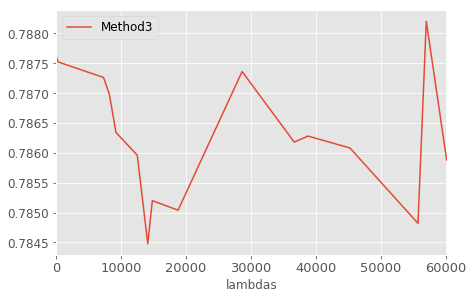

In [23]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Some histograms

#### W_2

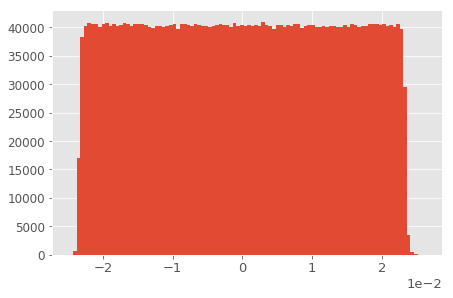

In [24]:
plt.hist(w_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_W_2

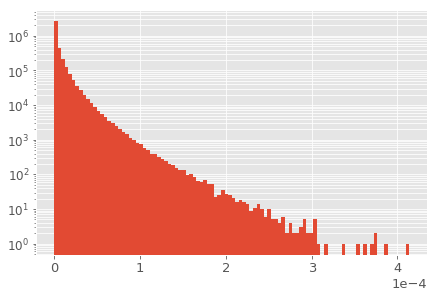

In [25]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_2

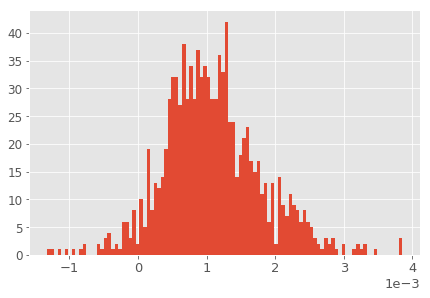

In [26]:
plt.hist(b_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_b_2

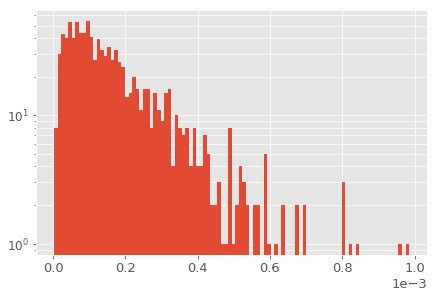

In [27]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### W_3

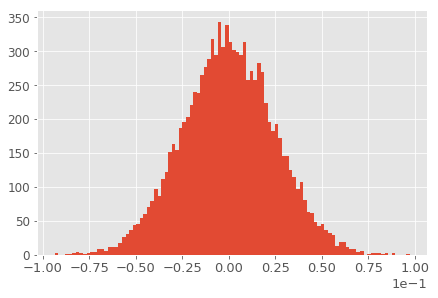

In [28]:
plt.hist(w_3.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_3

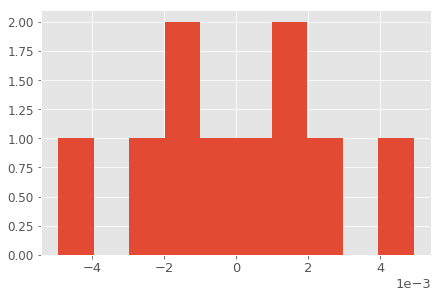

In [29]:
plt.hist(b_3.eval().flatten(), 10)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Init the writer with $\lambda$s (0, 6.75*2.5)e4

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_16lmbdas_ar1_3lyrs_he1_v2', sess.graph)

### Generate $\lambda$s 

In [10]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=0.0, high=6.75, size=(n_lmbdas,))
print(a)
print()
a = a*2.5e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[3.66798336 1.87899335 2.86549374 5.70223889 0.03185228 0.82059157
 4.52755632 5.5745061  0.92276948 3.88187997 6.01642319 1.41211432
 1.25096548 0.73154401 1.48295808]
()
[   796.30698223  18288.60026584  20514.78913215  23069.23700934
  31274.13704908  35302.85810728  37073.95188047  46974.83373458
  71637.34343892  91699.58392723  97046.99934085 113188.90804764
 139362.65242398 142555.97232898 150410.57979019]
()
([0, 796.3069822266202, 18288.600265843055, 20514.789132150523, 23069.237009335815, 31274.13704907517, 35302.858107275744, 37073.95188046742, 46974.833734578104, 71637.34343891621, 91699.58392722541, 97046.99934084844, 113188.9080476439, 139362.65242397678, 142555.97232898374, 150410.57979019455, 0, 796.3069822266202, 18288.600265843055, 20514.789132150523, 23069.237009335815, 31274.13704907517, 35302.858107275744, 37073.95188046742, 46974.833734578104, 71637.34343891621, 91699.58392722541, 97046.99934084844, 113188.9080476439, 139362.65242397678, 142555.97232898374, 150410

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [12]:
np.array_equal(np_weights[0], np_weights[15])

True

In [13]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [14]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:121.30377388
Method 3 test accuracy:0.78979998827
Training with lmbda:796.306982227, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 

Training on :(8, 9)
training cost:0.15148922801 and training accuracy:0.965170443058
validation cost:0.148252308369 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.10349150002 and training accuracy:0.972527444363
validation cost:0.102656595409 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0822133123875 and training accuracy:0.975973188877
validation cost:0.0786989107728 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692298561335 and training accuracy:0.979698240757
validation cost:0.0625535920262 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596315972507 and training accuracy:0.983050823212
validation cost:0.0548168830574 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0535449199378 and training accuracy:0.985192775726
validation cost:0.0488376505673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0478708669543 and traini

Training on :(6, 7)
training cost:0.00987485703081 and training accuracy:0.998917639256
validation cost:0.0103398412466 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00892970431596 and training accuracy:0.999098062515
validation cost:0.00891944114119 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:125.009098053
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153210803866 and training accuracy:0.964704811573
validation cost:0.146881058812 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.103699244559 and training accuracy:0.971875607967
validation cost:0.100957274437 and validation accuracy:0.976

Training on :(6, 7)
training cost:0.0241887103766 and training accuracy:0.997925519943
validation cost:0.0247597545385 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0189974773675 and training accuracy:0.997925519943
validation cost:0.0194135829806 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156127111986 and training accuracy:0.998196065426
validation cost:0.0162430014461 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131339710206 and training accuracy:0.998556852341
validation cost:0.0133459856734 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011212753132 and training accuracy:0.9987372756
validation cost:0.011480296962 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00990417134017 and training accuracy:0.998917639256
validation cost:0.0102933067828 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00893883407116 and 

Training on :(4, 5)
Time taken:118.933258057
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639220923185 and training accuracy:0.991431415081
validation cost:0.0631635710597 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0341743864119 and training accuracy:0.997294127941
validation cost:0.0343474708498 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242358539253 and training accuracy:0.997925519943
validation cost:0.0247850101441 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190198086202 and training accuracy:0.997925519943
validation cost:0.0194074325264 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0237225387245 and training accuracy:0.997853636742
validation cost:0.01825719513 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200099293143 and training accuracy:0.998243927956
validation cost:0.0148150855675 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01708384417 and training accuracy:0.998439013958
validation cost:0.0124439075589 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154672898352 and training accuracy:0.998048782349
validation cost:0.0113083859906 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.014066869393 and training accuracy:0.998146355152
validation cost:0.0102049121633 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.247581959
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
tra

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0988501161337 and training accuracy:0.991609752178
validation cost:0.0914637222886 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0541028305888 and training accuracy:0.99287801981
validation cost:0.0477724932134 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0378667786717 and training accuracy:0.994731724262
validation cost:0.030252315104 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0291485805064 and training accuracy:0.99658536911
validation cost:0.0223447922617 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.023802658543 and training accuracy:0.997756123543
validation cost:0.0181183759123 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200901124626 and training accuracy:0.998243927956
validation cost:0.014854083769 and vali

Training on :(2, 3)
training cost:0.0511706955731 and training accuracy:0.982910633087
validation cost:0.0508445911109 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0466096997261 and training accuracy:0.985728561878
validation cost:0.0470463596284 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0426395870745 and training accuracy:0.987455666065
validation cost:0.041549731046 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:122.146348953
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989923924208 and training accuracy:0.991609752178
validation cost:0.0916132107377 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113399781287 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886662453413 and training accuracy:0.97309333086
validation cost:0.0926548317075 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0737865045667 and training accuracy:0.974275052547
validation cost:0.07908950001 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.064708955586 and training accuracy:0.977274775505
validation cost:0.0673271641135 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0565049946308 and training accuracy:0.9806381464
validation cost:0.0583447925746 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.051161698997 and training accuracy:0.982819736004
validation cost:0.0506649166346 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465773865581 and training accura

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.041059017
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168318986893 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.11337454617 and training accuracy:0.968457400799
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886882692575 and training accuracy:0.973184227943
validation cost:0.0922498106956 and validation accuracy:0.96875


Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.957110882
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0486769229174 and training accuracy:0.986496567726
validation cost:0.0473077744246 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.045007288456 and training accuracy:0.987707197666
validation cost:0.0438957437873 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0415603145957 and training accuracy:0.988265991211
validation cost:0.040117777884 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.442662954
Method 3 test accuracy:0.781300008297
Training with lmbda:113188.908048, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy

Training on :(8, 9)
training cost:0.103646531701 and training accuracy:0.972154974937
validation cost:0.0989990979433 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.082573890686 and training accuracy:0.975786924362
validation cost:0.0804234445095 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689834356308 and training accuracy:0.979884505272
validation cost:0.0634634271264 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0603681579232 and training accuracy:0.982957720757
validation cost:0.056859780103 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0538872629404 and training accuracy:0.985006511211
validation cost:0.0515067912638 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0489155463874 and training accuracy:0.986310303211
validation cost:0.0471997708082 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0446824878454 and tr

Training on :(6, 7)
training cost:0.00918270554394 and training accuracy:0.999188244343
validation cost:0.00900432094932 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.155768871
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151894465089 and training accuracy:0.965263545513
validation cost:0.147132754326 and validation accuracy:0.966101706028
Training on :(8, 9)
training cost:0.10371812433 and training accuracy:0.972248077393
validation cost:0.101578719914 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0822459459305 and training accuracy:0.976159453392
validation cost:0.0785198286176 and validation accuracy:0.98022

Training on :(6, 7)
training cost:0.0192371290177 and training accuracy:0.997925519943
validation cost:0.0195095110685 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0158599000424 and training accuracy:0.998286306858
validation cost:0.0162932816893 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.013314222917 and training accuracy:0.9987372756
validation cost:0.0137675013393 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0115742273629 and training accuracy:0.998647093773
validation cost:0.0122968517244 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0103127844632 and training accuracy:0.9987372756
validation cost:0.0100096752867 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00921260379255 and training accuracy:0.999188244343
validation cost:0.00924434978515 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.764304161
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636705160141 and training accuracy:0.991160809994
validation cost:0.0626512393355 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0343804769218 and training accuracy:0.997203946114
validation cost:0.0333191305399 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0243165139109 and training accuracy:0.997835278511
validation cost:0.0248917285353 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0192671623081 and training accuracy:0.997925519943
validation cost:0.0197508372366 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0158849991858 and training accuracy:0.998196065426
validation cost:0.0163610056043 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0133453505114 and training accuracy:0.9987372756
validation cos

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.277729988
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.100175209343 and training accuracy:0.991414606571
validation cost:0.0899644941092 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0545722655952 and training accuracy:0.993073165417
validation cost:0.0472493432462 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039478354156 and training accuracy:0.994731724262
validation cost:0.0319879502058 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0308999381959 and training accuracy:0.996292710304
validation cost:0.0236615557224 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0251184981316 and training accuracy:0.996292710304
validation cost:0.0193858724087 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209882892668 and training accuracy:0.996975600719
validation cost:0.0149504188448 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184116456658 and training ac

training cost:0.0520971044898 and training accuracy:0.985001385212
validation cost:0.0572928674519 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0473909676075 and training accuracy:0.986274003983
validation cost:0.052646279335 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044321436435 and training accuracy:0.987455666065
validation cost:0.0489239394665 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.050449848
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998949185014 and training accuracy:0.991414606571
validation cost:0.0898005142808 and validation accuracy:0.994077026844
Training on

Training on :(2, 3)
training cost:0.116115123034 and training accuracy:0.968820989132
validation cost:0.119510956109 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903266966343 and training accuracy:0.974638640881
validation cost:0.0988492965698 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0756534710526 and training accuracy:0.977183878422
validation cost:0.0860961228609 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662140473723 and training accuracy:0.979001879692
validation cost:0.0743382573128 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0593109801412 and training accuracy:0.982183456421
validation cost:0.0655158311129 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0523320250213 and training accuracy:0.984819591045
validation cost:0.0574324764311 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474755242467 and 

Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.90159893
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116149775684 and training accuracy:0.968820989132
validation cost:0.119510956109 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903266966343 and training accuracy:0.974638640881
validation cost:0.0988492965698 and validation accuracy:0.970588

Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.067500114
C

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0495286546648 and training accuracy:0.985565304756
validation cost:0.046992868185 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0445526950061 and training accuracy:0.986869037151
validation cost:0.0443219691515 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0409540683031 and training accuracy:0.988359093666
validation cost:0.0409554950893 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:120.033000946
Method 3 test accuracy:0.788399994373
Training with lmbda:37073.9518805, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 

Training on :(8, 9)
training cost:0.105343349278 and training accuracy:0.968709230423
validation cost:0.102400757372 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0842297524214 and training accuracy:0.974762499332
validation cost:0.0827304571867 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0706858709455 and training accuracy:0.979139506817
validation cost:0.0700647979975 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0616864226758 and training accuracy:0.982026457787
validation cost:0.0593126527965 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0551976636052 and training accuracy:0.984633982182
validation cost:0.0523497201502 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0495488718152 and training accuracy:0.985658407211
validation cost:0.0471847765148 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448317304254 and t

training cost:0.0100257536396 and training accuracy:0.999098062515
validation cost:0.0100910728797 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00906832702458 and training accuracy:0.99927842617
validation cost:0.00897102989256 and validation accuracy:1.0
Training on :(6, 7)
Time taken:124.11333704
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.154370635748 and training accuracy:0.963121652603
validation cost:0.152970224619 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.105653375387 and training accuracy:0.968150496483
validation cost:0.102336391807 and validation accuracy:0.975517868996
Training on :(8, 9)
trai

Training on :(6, 7)
training cost:0.0241403542459 and training accuracy:0.998196065426
validation cost:0.0245787650347 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0186895895749 and training accuracy:0.998556852341
validation cost:0.0191698558629 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.015182456933 and training accuracy:0.998647093773
validation cost:0.0153837949038 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0129462461919 and training accuracy:0.998827457428
validation cost:0.013132693246 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113100577146 and training accuracy:0.999007821083
validation cost:0.0112292328849 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0100640999153 and training accuracy:0.999007821083
validation cost:0.0102113625035 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00916577782482 and train

training cost:0.0153618594632 and training accuracy:0.997560977936
validation cost:0.00988249666989 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.904117107
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620153732598 and training accuracy:0.992694139481
validation cost:0.0632757097483 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0342619046569 and training accuracy:0.997654914856
validation cost:0.0347629822791 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241278298199 and training accuracy:0.998196065426
validation cost:0.0242598894984 and validation accuracy:0.9981752038
Training on :(6, 7)
t

Training on :(4, 5)
training cost:0.0312403179705 and training accuracy:0.995999991894
validation cost:0.0240799617022 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.025688033551 and training accuracy:0.996195137501
validation cost:0.0196163412184 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212961621583 and training accuracy:0.996975600719
validation cost:0.0153290098533 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186645649374 and training accuracy:0.997365832329
validation cost:0.0129150385037 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0169854350388 and training accuracy:0.997365832329
validation cost:0.0115953329951 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0155731095001 and training accuracy:0.997560977936
validation cost:0.00991668738425 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.682409048
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test f

Time taken:122.939203978
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100015625358 and training accuracy:0.991707324982
validation cost:0.0894328355789 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0547274723649 and training accuracy:0.993073165417
validation cost:0.0474314503372 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0396656058729 and training accuracy:0.994829297066
validation cost:0.0323840938509 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0312842652202 and training accuracy:0.995999991894
validation cost:0.0241411346942 and validation accuracy:0.998025655746
Training o

Training on :(2, 3)
training cost:0.0663103535771 and training accuracy:0.978820085526
validation cost:0.0739766508341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0593317300081 and training accuracy:0.982274353504
validation cost:0.0660292580724 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0522460564971 and training accuracy:0.985001385212
validation cost:0.0573969744146 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474216938019 and training accuracy:0.986001253128
validation cost:0.0527887903154 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044284965843 and training accuracy:0.987364768982
validation cost:0.0486155338585 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.889750004
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172764718533 and training accuracy:0.948186516762
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116086192429 and training accuracy:0.968820989132
validation cost:0.11926035583 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.090460985899 and training accuracy:0.974729597569
validation cost:0.0988436564803 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0754369422793 and training accuracy:0.977456569672
validation cost:0.0859469398856 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0662959218025 and training accuracy:0.978820085526
validation cost:0.0739766508341 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0592784844339 and training accuracy:0.982365250587
validation cost:0.

Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.558676958
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172764718533 and training accuracy:0.948186516762
validation cost:0.17598554492 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.560086966
Method 3 test accuracy:0.787899971008
Training with lmbda:796.306982227, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 

Training on :(8, 9)
training cost:0.0701109468937 and training accuracy:0.978860139847
validation cost:0.0689178258181 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0606927275658 and training accuracy:0.982119560242
validation cost:0.0599196068943 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0538761503994 and training accuracy:0.984075248241
validation cost:0.0517532490194 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.04885622859 and training accuracy:0.985937774181
validation cost:0.0474339574575 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0442818291485 and training accuracy:0.987334728241
validation cost:0.042396042496 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413575209677 and training accuracy:0.988452196121
validation cost:0.03872166574 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.894782066
Method 3 tes

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150328353047 and training accuracy:0.963401019573
validation cost:0.149026587605 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.102701582015 and training accuracy:0.971968710423
validation cost:0.102597594261 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0835989937186 and training accuracy:0.975414395332
validation cost:0.0832036808133 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.069928124547 and training accuracy:0.978953242302
validation cost:0.0685425326228 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0608660578728 and training accuracy:0.982119560242
validation cost:0.0590065866709 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0541558265686 and training accuracy:0.984261512756
validation cost:

Training on :(6, 7)
training cost:0.0109498500824 and training accuracy:0.998917639256
validation cost:0.0109585830942 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.009825469926 and training accuracy:0.999098062515
validation cost:0.0100832665339 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00868981331587 and training accuracy:0.999098062515
validation cost:0.00882900413126 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.530742884
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15034994483 and training accuracy:0.963307857513
validation cost:0.149088099599 and validation accuracy:0.964218

Training on :(6, 7)
training cost:0.0337922163308 and training accuracy:0.997113764286
validation cost:0.0350391454995 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234892256558 and training accuracy:0.998196065426
validation cost:0.0243732053787 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0182705931365 and training accuracy:0.998376488686
validation cost:0.0187453180552 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148179456592 and training accuracy:0.998376488686
validation cost:0.0143084032461 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0127161117271 and training accuracy:0.998466670513
validation cost:0.0129405399784 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109650548548 and training accuracy:0.998917639256
validation cost:0.011015413329 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00981589127332 and 

training cost:0.0158166438341 and training accuracy:0.998341441154
validation cost:0.0125233670697 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0143256597221 and training accuracy:0.998439013958
validation cost:0.0115584107116 and validation accuracy:1.0
Training on :(4, 5)
Time taken:117.263464212
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619447119534 and training accuracy:0.991972565651
validation cost:0.061029817909 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337712094188 and training accuracy:0.997113764286
validation cost:0.0347214378417 and validation accuracy:0.997262775898
Training on :(6, 7)
training cos

Training on :(4, 5)
training cost:0.0378770381212 and training accuracy:0.995999991894
validation cost:0.0323400869966 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0287604443729 and training accuracy:0.997560977936
validation cost:0.0241905767471 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0236209537834 and training accuracy:0.997560977936
validation cost:0.0193193946034 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200745668262 and training accuracy:0.997951209545
validation cost:0.0150113981217 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0174794290215 and training accuracy:0.998341441154
validation cost:0.0134059265256 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015747917816 and training accuracy:0.998341441154
validation cost:0.0125230085105 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01440339908 and training accuracy:0.998439013958
validation cost:0.0114608509466 an

Training on :(2, 3)
Time taken:123.313584805
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0965457856655 and training accuracy:0.993365824223
validation cost:0.0909845978022 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0525650121272 and training accuracy:0.994926810265
validation cost:0.046878118068 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378543920815 and training accuracy:0.99590241909
validation cost:0.0321171209216 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0287195947021 and training accuracy:0.997658550739
validation cost:0.023715633899 and validation accuracy:1.0
Training on :(

Training on :(2, 3)
training cost:0.0620873831213 and training accuracy:0.979001879692
validation cost:0.0636912360787 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548512041569 and training accuracy:0.981910765171
validation cost:0.0559078976512 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495991893113 and training accuracy:0.984001457691
validation cost:0.0488325282931 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0459703207016 and training accuracy:0.984910488129
validation cost:0.0461137965322 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0424869805574 and training accuracy:0.986728489399
validation cost:0.0427868589759 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.863579988
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.107107408345 and training accuracy:0.97127532959
validation cost:0.106736317277 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833898261189 and training accuracy:0.975184082985
validation cost:0.0829503983259 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.070340141654 and training accuracy:0.977456569672
validation cost:0.071641638875 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0618648417294 and training accuracy:0.978910982609
validation cost:0.0633789896965 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0547424927354 and training accuracy:0.9817289114
validation cost:0.05

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:133.759968042
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0418532937765 and training accuracy:0.987986564636
validation cost:0.0401032157242 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:125.712031126
Method 3 test accuracy:0.787800014019
Training with lmbda:113188.908048, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.0703809037805 and training accuracy:0.978580713272
validation cost:0.0701789557934 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0610729902983 and training accuracy:0.981840193272
validation cost:0.0586418285966 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540510974824 and training accuracy:0.984261512756
validation cost:0.0523419864476 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0492127537727 and training accuracy:0.985565304756
validation cost:0.0477319508791 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0451922491193 and training accuracy:0.987148463726
validation cost:0.0431679934263 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0421819239855 and training accuracy:0.988265991211
validation cost:0.0403928495944 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:121.96715498
Method 3

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150566145778 and training accuracy:0.963959753513
validation cost:0.147449240088 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103041596711 and training accuracy:0.972154974937
validation cost:0.101852245629 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0837976112962 and training accuracy:0.975693821907
validation cost:0.084143973887 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0703326538205 and training accuracy:0.978953242302
validation cost:0.070348136127 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609009973705 and training accuracy:0.982119560242
validation cost:0.0593615882099 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0543972104788 and training accuracy:0.984075248241
validation cost:0.

Training on :(6, 7)
training cost:0.0113500533625 and training accuracy:0.9987372756
validation cost:0.011773891747 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0100625501946 and training accuracy:0.999007821083
validation cost:0.0102174188942 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00898596271873 and training accuracy:0.999098062515
validation cost:0.00927357468754 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:138.123650074
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150477424264 and training accuracy:0.964052915573
validation cost:0.14734838903 and validation accuracy:0.965160

Training on :(6, 7)
training cost:0.0339030586183 and training accuracy:0.997023522854
validation cost:0.0354124493897 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235441979021 and training accuracy:0.998196065426
validation cost:0.0248404797167 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0184035394341 and training accuracy:0.998466670513
validation cost:0.0187263078988 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0151650840417 and training accuracy:0.998286306858
validation cost:0.0144225591794 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0129250707105 and training accuracy:0.998466670513
validation cost:0.013014617376 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0113065382466 and training accuracy:0.998827457428
validation cost:0.0115228723735 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0100046144798 and t

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:123.475393057
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0293699502945 and training accuracy:0.996780514717
validation cost:0.0219656378031 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244361609221 and training accuracy:0.997170746326
validation cost:0.0176994390786 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.021232817322 and training accuracy:0.997463405132
validation cost:0.0151018612087 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0188996363431 and training accuracy:0.997365832329
validation cost:0.0134841846302 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169202014804 and training accuracy:0.997365832329
validation cost:0.0122478334233 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152351073921 and training accuracy:0.997463405132
validation cost:0.0111174015328 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:130.014928818
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 

Time taken:132.51511097
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0953333675861 and training accuracy:0.991999983788
validation cost:0.0893254652619 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530296899378 and training accuracy:0.992975592613
validation cost:0.0449967347085 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374041311443 and training accuracy:0.995121955872
validation cost:0.0301220621914 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0295025184751 and training accuracy:0.996780514717
validation cost:0.0222062747926 and validation accuracy:1.0
Training on :(4, 5)
tr

Training on :(2, 3)
training cost:0.0609599351883 and training accuracy:0.97991091013
validation cost:0.0678018853068 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0536979325116 and training accuracy:0.982456147671
validation cost:0.0580634698272 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0491064824164 and training accuracy:0.984365046024
validation cost:0.0535753816366 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0452875494957 and training accuracy:0.985728561878
validation cost:0.049983587116 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0414678454399 and training accuracy:0.987182974815
validation cost:0.0458880364895 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:136.737923145
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162123292685 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108008190989 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0838111937046 and training accuracy:0.976365804672
validation cost:0.0886647701263 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0697535276413 and training accuracy:0.977638423443
validation cost:0.076756618917 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0610267557204 and training accuracy:0.979820013046
validation cost:0.0678147599101 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537648648024 and training accuracy:0.982365250587
validation cost:0.057695

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:139.278537989
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162194564939 and training accuracy:0.953822374344
validation cost:0.167495980859 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0432544611394 and training accuracy:0.987241566181
validation cost:0.0409720055759 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.557790995
Method 3 test accuracy:0.791999995708
Training with lmbda:37073.9518805, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 a

Training on :(8, 9)
training cost:0.0721436738968 and training accuracy:0.978580713272
validation cost:0.0725622624159 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0629352480173 and training accuracy:0.982212722301
validation cost:0.0629731193185 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0562690608203 and training accuracy:0.984168350697
validation cost:0.0542284399271 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0510250031948 and training accuracy:0.985285878181
validation cost:0.049770437181 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0468839071691 and training accuracy:0.986775934696
validation cost:0.0440308526158 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0432444922626 and training accuracy:0.987334728241
validation cost:0.0409017018974 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:121.024463892
Method 3

Time taken:124.503499031
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.1506844908 and training accuracy:0.963587284088
validation cost:0.152643844485 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.104683674872 and training accuracy:0.972527444363
validation cost:0.10667797178 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0847524255514 and training accuracy:0.974483132362
validation cost:0.0845388248563 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0726089403033 and training accuracy:0.978301346302
validation cost:0.0728739723563 and validation accuracy:0.979284346104
Training on :(8,

Training on :(6, 7)
training cost:0.0161369889975 and training accuracy:0.998105883598
validation cost:0.0153667367995 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.01376098115 and training accuracy:0.998376488686
validation cost:0.0137675851583 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117801707238 and training accuracy:0.998466670513
validation cost:0.0121707813814 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104270409793 and training accuracy:0.9987372756
validation cost:0.0110761951655 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00943758990616 and training accuracy:0.998827457428
validation cost:0.0097176535055 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.396088123
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid featu

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679095610976 and training accuracy:0.990349054337
validation cost:0.0671228468418 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364759005606 and training accuracy:0.996572554111
validation cost:0.0354130156338 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0259361155331 and training accuracy:0.997384309769
validation cost:0.0258508399129 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0203720629215 and training accuracy:0.997745096684
validation cost:0.0197528153658 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162928104401 and training accuracy:0.998196065426
validation cost:0.0156377442181 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137077653781 and training accuracy:0.998556852341
validation cost:0.

Training on :(4, 5)
training cost:0.0190728046 and training accuracy:0.997463405132
validation cost:0.0135627649724 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0172889623791 and training accuracy:0.997365832329
validation cost:0.0127224428579 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0156135195866 and training accuracy:0.997463405132
validation cost:0.0113343438134 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.924355984
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679037421942 and training accuracy:0.990349054337
validation cost:0.066652148962 and validation accuracy:0.98813867569
Train

Training on :(4, 5)
training cost:0.0530664660037 and training accuracy:0.992975592613
validation cost:0.0452119298279 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376579016447 and training accuracy:0.994926810265
validation cost:0.0304805375636 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0297700427473 and training accuracy:0.996682941914
validation cost:0.0224348772317 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0248977914453 and training accuracy:0.996975600719
validation cost:0.0182179380208 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215430185199 and training accuracy:0.997365832329
validation cost:0.0153085095808 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.01913391985 and training accuracy:0.997463405132
validation cost:0.0135194053873 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0172407794744 and training accuracy:0.997463405132
v

training cost:0.0453727655113 and training accuracy:0.985819458961
validation cost:0.0493628680706 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416166111827 and training accuracy:0.987182974815
validation cost:0.0455468893051 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.971861124
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0951368734241 and training accuracy:0.992292702198
validation cost:0.0890568494797 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0531992428005 and training accuracy:0.993073165417
validation cost:0.0454778335989 and validation accuracy:0.99703848362
Training o

Training on :(2, 3)
training cost:0.0837813392282 and training accuracy:0.976365804672
validation cost:0.0886367931962 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0697070658207 and training accuracy:0.977820217609
validation cost:0.0767865255475 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0612129755318 and training accuracy:0.979729115963
validation cost:0.0678525865078 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0541788227856 and training accuracy:0.982456147671
validation cost:0.0580561943352 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0492084957659 and training accuracy:0.984365046024
validation cost:0.0528121180832 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.045342259109 and training accuracy:0.985728561878
validation cost:0.0499227270484 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0417047590017 and

Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:129.072037935
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162052035332 and training accuracy:0.953913271427
validation cost:0.167119041085 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.107976578176 and training accuracy:0.971457123756
validation cost:0.109001517296 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837869867682 and training accuracy:0.976365804672
validation cost:0.0886367931962 and validation accuracy:0.970588207245

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.637654066
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0489239878953 and training accuracy:0.985844671726
validation cost:0.0491009689867 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0446518622339 and training accuracy:0.987800359726
validation cost:0.0445098057389 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412660241127 and training accuracy:0.987893462181
validation cost:0.0416884683073 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:120.667655945
Method 3 test accuracy:0.778800010681
Training with lmbda:18288.6002658, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

training cost:0.102464877069 and training accuracy:0.972527444363
validation cost:0.101435407996 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0818576961756 and training accuracy:0.976159453392
validation cost:0.0820057541132 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0692378431559 and training accuracy:0.980815768242
validation cost:0.0682745799422 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0605737268925 and training accuracy:0.983423352242
validation cost:0.0603957250714 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538464002311 and training accuracy:0.984540879726
validation cost:0.0515225790441 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490732826293 and training accuracy:0.985937774181
validation cost:0.0490423962474 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0445888079703 and training accuracy:0.

Training on :(6, 7)
training cost:0.00949676521122 and training accuracy:0.9987372756
validation cost:0.00949280615896 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.087237835
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15145984292 and training accuracy:0.966660439968
validation cost:0.149531170726 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.102716974914 and training accuracy:0.972434341908
validation cost:0.10159561038 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0817595422268 and training accuracy:0.976345717907
validation cost:0.081954240799 and validation accuracy:0.97928434610

Training on :(6, 7)
training cost:0.0195216648281 and training accuracy:0.997474491596
validation cost:0.0207214094698 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157921295613 and training accuracy:0.997654914856
validation cost:0.0163069777191 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135549381375 and training accuracy:0.997925519943
validation cost:0.0139531595632 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0117451073602 and training accuracy:0.998286306858
validation cost:0.0124514037743 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0105627039447 and training accuracy:0.998466670513
validation cost:0.0110487388447 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00947526283562 and training accuracy:0.998827457428
validation cost:0.00949730630964 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.484637022
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0630078688264 and training accuracy:0.990800023079
validation cost:0.063481092453 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347890630364 and training accuracy:0.996572554111
validation cost:0.0345656350255 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0246202666312 and training accuracy:0.997564733028
validation cost:0.0255778823048 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.019567783922 and training accuracy:0.997474491596
validation cost:0.0205930992961 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0157794635743 and training accuracy:0.997654914856
validation cost:0.0163267850876 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135523732752 and training accuracy:0.998015701771
validation co

Training on :(4, 5)
training cost:0.0182696077973 and training accuracy:0.997463405132
validation cost:0.0121029745787 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164332278073 and training accuracy:0.997365832329
validation cost:0.0104616163298 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149385510013 and training accuracy:0.997365832329
validation cost:0.00910290423781 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.807803154
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629022791982 and training accuracy:0.990800023079
validation cost:0.0632882639766 and validation accuracy:0.989963531494
Training on :(6, 7)
t

Training on :(4, 5)
training cost:0.0534101910889 and training accuracy:0.993073165417
validation cost:0.0432459153235 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375725924969 and training accuracy:0.994829297066
validation cost:0.0289089884609 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288783609867 and training accuracy:0.996487796307
validation cost:0.0223869141191 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0241064094007 and training accuracy:0.996975600719
validation cost:0.0180345587432 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0207818448544 and training accuracy:0.997170746326
validation cost:0.0141663858667 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0182659272105 and training accuracy:0.997365832329
validation cost:0.0120902210474 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164355654269 and training accuracy:0.997365832329
validation cost:0.01

Training on :(2, 3)
training cost:0.0444477126002 and training accuracy:0.986637592316
validation cost:0.0474953353405 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.436239958
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943033322692 and training accuracy:0.993463397026
validation cost:0.0831386074424 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0533407591283 and training accuracy:0.993073165417
validation cost:0.0434813648462 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375525727868 and training accuracy:0.994829297066
validation cost:0.0288701783866 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0762327834964 and training accuracy:0.974911391735
validation cost:0.0821544378996 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0651618093252 and training accuracy:0.979183733463
validation cost:0.0662399530411 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0577904731035 and training accuracy:0.9817289114
validation cost:0.0604366473854 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.052157856524 and training accuracy:0.984092354774
validation cost:0.0546396039426 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0475571900606 and training accuracy:0.985637664795
validation cost:0.0517562516034 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0444196946919 and training accuracy:0.986546695232
validation cost:0.0476039946079 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:125.076636076
Current mask:[1.

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171819314361 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115092851222 and training accuracy:0.968457400799
validation cost:0.119560241699 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0912140011787 and training accuracy:0.972002565861
validation cost:0.0962703675032 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0760872066021 and training accuracy:0.974911391735
validation cost:0.0825015157461 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652142316103 and training accuracy:0.979001879692
validation cost:0.0661919564009 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578996427357 and training accuracy:0.981819808483
validation cost

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.66072011
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171822085977 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0423647351563 and training accuracy:0.987800359726
validation cost:0.0413728281856 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.606106043
Method 3 test accuracy:0.777700006962
Training with lmbda:139362.652424, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0694067925215 and training accuracy:0.980443298817
validation cost:0.0687839090824 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0612138211727 and training accuracy:0.983050823212
validation cost:0.0598130859435 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.054078694433 and training accuracy:0.984633982182
validation cost:0.0508561991155 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.049388114363 and training accuracy:0.985472142696
validation cost:0.0475774556398 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0456482507288 and training accuracy:0.986869037151
validation cost:0.044007383287 and validation accuracy:0.992467045784
Training on :(8, 9)
training cost:0.0424977652729 and training accuracy:0.988079726696
validation cost:0.0420758984983 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:121.434592962
Method 3 te

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151932418346 and training accuracy:0.967405498028
validation cost:0.146447703242 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.103574849665 and training accuracy:0.971689343452
validation cost:0.102265201509 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0827428102493 and training accuracy:0.975786924362
validation cost:0.0838534832001 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0697462707758 and training accuracy:0.980443298817
validation cost:0.0692382231355 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0611874982715 and training accuracy:0.983050823212
validation cost:0.0598047412932 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0540835373104 and training accuracy:0.984633982182
validation cost:

Training on :(6, 7)
training cost:0.0121061690152 and training accuracy:0.998196065426
validation cost:0.0126896938309 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0108507405967 and training accuracy:0.998466670513
validation cost:0.0114799691364 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00980369281024 and training accuracy:0.9987372756
validation cost:0.00978200417012 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.747390032
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.152182772756 and training accuracy:0.967405498028
validation cost:0.14825540781 and validation accuracy:0.9726930

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_16lmbdas_ar1_3lyrs_he1_v2.csv')
final_test_acc

Method3        lambdas
0    0.7898       0.000000
1    0.7900     796.306982
2    0.7824   18288.600266
3    0.7821   20514.789132
4    0.7814   23069.237009
5    0.7831   31274.137049
6    0.7831   35302.858107
7    0.7829   37073.951880
8    0.7823   46974.833735
9    0.7810   71637.343439
10   0.7805   91699.583927
11   0.7813   97046.999341
12   0.7802  113188.908048
13   0.7905  139362.652424
14   0.7816  142555.972329
15   0.7879  150410.579790
16   0.7927       0.000000
17   0.7912     796.306982
18   0.7918   18288.600266
19   0.7859   20514.789132
20   0.7860   23069.237009
21   0.7925   31274.137049
22   0.7884   35302.858107
23   0.7880   37073.951880
24   0.7925   46974.833735
25   0.7939   71637.343439
26   0.7948   91699.583927
27   0.7956   97046.999341
28   0.7961  113188.908048
29   0.7940  139362.652424
..      ...            ...
50   0.7867   18288.600266
51   0.7900   20514.789132
52   0.7907   23069.237009
53   0.7906   31274.137049
54   0.7920   35302.858107
55   0.7971   37073.951880
56   0.7893   46974.833735
57   0.7896   71637.343439
58   0.7974   91699.583927
59   0.7902   97046.999341
60   0.7906  113188.908048
61   0.7893  139362.652424
62   0.7902  142555.972329
63   0.7897  150410.579790
64   0.7784       0.000000
65   0.7788     796.306982
66   0.7782   18288.600266
67   0.7783   20514.789132
68   0.7778   23069.237009
69   0.7777   31274.137049
70   0.7784   35302.858107
71   0.7788   37073.951880
72   0.7789   46974.833735
73   0.7790   71637.343439
74   0.7785   91699.583927
75   0.7786   97046.999341
76   0.7777  113188.908048
77   0.7776  139362.652424
78   0.7775  142555.972329
79   0.7772  150410.579790

[80 rows x 2 columns]

#### Groupby $\lambda$s

In [16]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

Method3
lambdas               
0.000000       0.78762
796.306982     0.78738
18288.600266   0.78516
20514.789132   0.78470
23069.237009   0.78456
31274.137049   0.78618
35302.858107   0.78568
37073.951880   0.78656
46974.833735   0.78600
71637.343439   0.78616
91699.583927   0.78782
97046.999341   0.78670
113188.908048  0.78644
139362.652424  0.78776
142555.972329  0.78650
150410.579790  0.78740

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

Method3
lambdas                
0.000000       0.005442
796.306982     0.004962
18288.600266   0.005121
20514.789132   0.004569
23069.237009   0.005023
31274.137049   0.005949
35302.858107   0.005188
37073.951880   0.006839
46974.833735   0.005437
71637.343439   0.006143
91699.583927   0.008381
97046.999341   0.006845
113188.908048  0.007538
139362.652424  0.006168
142555.972329  0.007147
150410.579790  0.006381

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

Method3
lambdas               
0.000000        0.7927
796.306982      0.7912
18288.600266    0.7918
20514.789132    0.7900
23069.237009    0.7907
31274.137049    0.7925
35302.858107    0.7920
37073.951880    0.7971
46974.833735    0.7925
71637.343439    0.7939
91699.583927    0.7974
97046.999341    0.7956
113188.908048   0.7961
139362.652424   0.7940
142555.972329   0.7957
150410.579790   0.7947

#### Plots

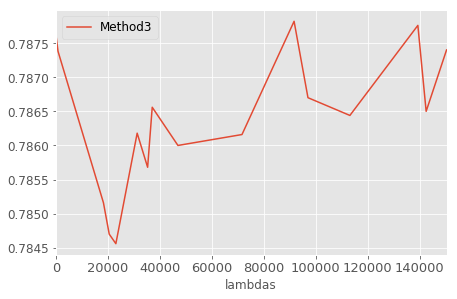

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the $\lambda$s with (7.5, 10)

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_15lmbdas_ar1_3lyrs_he1_75_10_no_exp', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 15
a = np.random.uniform(low=7.5, high=10, size=(n_lmbdas,))
print(a)
print()
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.85851235 8.19592346 8.56129398 9.61194033 7.51179714 7.8039228
 9.17687271 9.56463189 7.84176647 8.93773332 9.72830489 8.02300531
 7.96332055 7.77094223 8.04924373]
()
[7.51179714 7.77094223 7.8039228  7.84176647 7.96332055 8.02300531
 8.04924373 8.19592346 8.56129398 8.85851235 8.93773332 9.17687271
 9.56463189 9.61194033 9.72830489]
()
([0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7.9633205488751875, 8.023005305292974, 8.04924373156248, 8.195923462734491, 8.561293976872832, 8.858512354477414, 8.937733323568125, 9.176872711816946, 9.56463188776262, 9.61194033079976, 9.728304885780659, 0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7.9633205488751875, 8.023005305292974, 8.04924373156248, 8.195923462734491, 8.561293976872832, 8.858512354477414, 8.937733323568125, 9.176872711816946, 9.56463188776262, 9.61194033079976, 9.728304885780659, 0, 7.511797140477431, 7.770942226160638, 7.8039228019577855, 7.841766474212382, 7

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(80, 80)


In [12]:
np.array_equal(np_weights[0], np_weights[15])

True

In [13]:
np.array_equal(np_weights[0], np_weights[16])

False

### Commence training

In [14]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.170996189
Method 3 test accuracy:0.78979998827
Training with lmbda:7.51179714048, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10356554389 and training accuracy:0.972527444363
validation cost:0.103338226676 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0823166370392 and training accuracy:0.975973188877
validation cost:0.0788178667426 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0693510770798 and training accuracy:0.979791402817
validation cost:0.0628246888518 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596028491855 and training accuracy:0.983050823212
validation cost:0.0546582974494 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0535265989602 and training accuracy:0.985192775726
validation cost:0.0488242767751 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0480234026909 and trai

Training on :(6, 7)
training cost:0.00979856215417 and training accuracy:0.999007821083
validation cost:0.0101007102057 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.127705097
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10356554389 and training accuracy:0.972527444363
validation cost:0.103338226676 and validation accuracy:0.97363

Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.012963745743 and training accuracy:0.9987372756
validation cost:0.013368149288 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011112768203 and training accuracy:0.998827457428
validation cost:0.0117992609739 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00979856215417 and training accuracy:0.999007821083
validation cost:0.0101007102057 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and trai

Training on :(4, 5)
Time taken:114.125716925
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636208951473 and training accuracy:0.991611778736
validation cost:0.0635736957192 and validation accuracy:0.989051103592
Training on :(6, 7)
training cost:0.0342947021127 and training accuracy:0.996843159199
validation cost:0.0337495431304 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.9963

Training on :(4, 5)
training cost:0.023657489568 and training accuracy:0.997756123543
validation cost:0.0176057368517 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0198712404817 and training accuracy:0.998341441154
validation cost:0.0145276719704 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0169922467321 and training accuracy:0.998341441154
validation cost:0.0122214574367 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0153050273657 and training accuracy:0.998146355152
validation cost:0.011213125661 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0139560960233 and training accuracy:0.998243927956
validation cost:0.0100094126537 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.908252001
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0


training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0990518555045 and training accuracy:0.991609752178
validation cost:0.0925189256668 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0539999529719 and training accuracy:0.99287801981
validation cost:0.0477138087153 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376890674233 and training accuracy:0.994829297066
validation cost:0.0302194636315 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0290481522679 and training accuracy:0.99658536911
validation cost:0.0220831781626 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.023657489568 and training accuracy:0.997756123543
validation cost:0.0176057368517 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0198712404817 and training accuracy:0.998341441154
validation cost:0.0145276719704 and va

Training on :(2, 3)
training cost:0.0513964854181 and training accuracy:0.982819736004
validation cost:0.0509350299835 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0464820750058 and training accuracy:0.985546767712
validation cost:0.0469166785479 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0427470132709 and training accuracy:0.987273871899
validation cost:0.0414676591754 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:122.589113951
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0990518555045 and training accuracy:0.991609752178
validation cost:0.0925189256668 and validation accuracy:0.99703848

Training on :(2, 3)
training cost:0.113371483982 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885975807905 and training accuracy:0.97309333086
validation cost:0.0926486998796 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0738820210099 and training accuracy:0.974093258381
validation cost:0.0787701904774 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0646886602044 and training accuracy:0.977183878422
validation cost:0.0672900676727 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0566079691052 and training accuracy:0.9806381464
validation cost:0.0583092048764 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0513964854181 and training accuracy:0.982819736004
validation cost:0.0509350299835 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0464820750058 and training ac

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.211473942
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168302044272 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113371483982 and training accuracy:0.968548297882
validation cost:0.12098506093 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0885975807905 and training accuracy:0.97309333086
validation cost:0.0926486998796 and validation accuracy:0.967830

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.778723955
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0479701012373 and training accuracy:0.986682832241
validation cost:0.0454680249095 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.044334076345 and training accuracy:0.987334728241
validation cost:0.0435089208186 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0406236462295 and training accuracy:0.988545358181
validation cost:0.0390987917781 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.857406855
Method 3 test accuracy:0.790000021458
Training with lmbda:9.17687271182, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accurac

Training on :(8, 9)
training cost:0.103550389409 and training accuracy:0.972527444363
validation cost:0.103120595217 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824230909348 and training accuracy:0.975973188877
validation cost:0.0788422375917 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0693369582295 and training accuracy:0.979791402817
validation cost:0.0627895593643 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0596635639668 and training accuracy:0.983050823212
validation cost:0.0547411032021 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0534497350454 and training accuracy:0.985285878181
validation cost:0.0488405413926 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479923263192 and training accuracy:0.986682832241
validation cost:0.045550942421 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.04434235394 and trai

Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.071674109
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151477068663 and training accuracy:0.965170443058
validation cost:0.148457437754 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103550389409 and training accuracy:0.972527444363
validation cost:0.103120595217 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0824230909348 and training accuracy:0.975973188877
validation cost:0.0788422375917 and validation accuracy:0.98022

Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129639329389 and training accuracy:0.9987372756
validation cost:0.0133697763085 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.011112768203 and training accuracy:0.998827457428
validation cost:0.0117992609739 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00979762617499 and training accuracy:0.999007821083
validation cost:0.0101021369919 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0087788850069 and training accuracy:0.999098062515
validation cost:0.00852270238101 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.371605873
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0636208951473 and training accuracy:0.991611778736
validation cost:0.0635736957192 and validation accuracy:0.989051103592
Training on :(6, 7)
training cost:0.0342947021127 and training accuracy:0.996843159199
validation cost:0.0337495431304 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0241673067212 and training accuracy:0.997745096684
validation cost:0.0247216559947 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0191191416234 and training accuracy:0.998015701771
validation cost:0.01931928657 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0155691420659 and training accuracy:0.998286306858
validation cost:0.0159959737211 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0129639329389 and training accuracy:0.9987372756
validation cost

training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183575861156 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164001379162 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.291078091
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and

Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0544792301953 and training accuracy:0.99317073822
validation cost:0.0472705699503 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0309216249734 and training accuracy:0.996292710304
validation cost:0.0237145852298 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0250762961805 and training accuracy:0.996390223503
validation cost:0.0194353610277 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183576606214 and training ac

training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and training accuracy:0.986092150211
validation cost:0.0525288358331 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.725975037
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training o

Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0902791470289 and training accuracy:0.974820494652
validation cost:0.0988100841641 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663870871067 and training accuracy:0.979001879692
validation cost:0.0742923021317 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591977611184 and training accuracy:0.982274353504
validation cost:0.0650026425719 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and t

training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.111252069
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on

Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155

Training on :(8, 9)
Time taken:119.381731033
Method 3 test accuracy:0.791100025177
Training with lmbda:8.02300530529, 22
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 

Training on :(8, 9)
training cost:0.0617894046009 and training accuracy:0.982026457787
validation cost:0.0594418868423 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0555416159332 and training accuracy:0.984075248241
validation cost:0.053346734494 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0496400222182 and training accuracy:0.985844671726
validation cost:0.0472700074315 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0445803552866 and training accuracy:0.987055301666
validation cost:0.0442854613066 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0405430085957 and training accuracy:0.988172829151
validation cost:0.040343914181 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.076274157
Method 3 test accuracy:0.791100025177
Training with lmbda:8.04924373156, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labe

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153984576464 and training accuracy:0.962749123573
validation cost:0.153692275286 and validation accuracy:0.95951038599
Training on :(8, 9)
training cost:0.104996949434 and training accuracy:0.968429863453
validation cost:0.101843871176 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0838682577014 and training accuracy:0.975228190422
validation cost:0.0828503072262 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0702543258667 and training accuracy:0.979605138302
validation cost:0.0693361237645 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0617894046009 and training accuracy:0.982026457787
validation cost:0.0594418868423 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0555416159332 and training accuracy:0.984075248241
validation cost:0.

Training on :(6, 7)
training cost:0.0110732596368 and training accuracy:0.999007821083
validation cost:0.0108604701236 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00984354596585 and training accuracy:0.999188244343
validation cost:0.0102103631943 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00882442854345 and training accuracy:0.999368607998
validation cost:0.00872092228383 and validation accuracy:1.0
Training on :(6, 7)
Time taken:123.484806061
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153984576464 and training accuracy:0.962749123573
validation cost:0.153692275286 and validation accuracy:0.95951038599


Training on :(6, 7)
training cost:0.0341977700591 and training accuracy:0.997564733028
validation cost:0.034630741924 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241072438657 and training accuracy:0.998105883598
validation cost:0.0242516770959 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0183131210506 and training accuracy:0.998556852341
validation cost:0.0184767190367 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0150533709675 and training accuracy:0.998647093773
validation cost:0.0150910522789 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0126965390518 and training accuracy:0.998827457428
validation cost:0.0126975839958 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0110732596368 and training accuracy:0.999007821083
validation cost:0.0108604701236 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00984354596585 and trai

Training on :(4, 5)
training cost:0.016401251778 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132
validation cost:0.0095500042662 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.985738039
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620987862349 and training accuracy:0.992784321308
validation cost:0.0630205348134 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341977700591 and training accuracy:0.997564733028
validation cost:0.034630741924 and validation accuracy:0.999087572098
Training on :

Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0309216249734 and training accuracy:0.996292710304
validation cost:0.0237145852298 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0250762961805 and training accuracy:0.996390223503
validation cost:0.0194353610277 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0209832713008 and training accuracy:0.996975600719
validation cost:0.0149554889649 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0183576606214 and training accuracy:0.997365832329
validation cost:0.0124804545194 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.016401251778 and training accuracy:0.997560977936
validation cost:0.0110024530441 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0149549171329 and training accuracy:0.997463405132


training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.891077042
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998727753758 and training accuracy:0.991609752178
validation cost:0.0896322578192 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0544792301953 and training accuracy:0.99317073822
validation cost:0.0472705699503 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.039569940418 and training accuracy:0.994829297066
validation cost:0.0322494134307 and validation accuracy:0.998025655746
Training on 

Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0663870871067 and training accuracy:0.979001879692
validation cost:0.0742923021317 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591977611184 and training accuracy:0.982274353504
validation cost:0.0650026425719 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523506365716 and training accuracy:0.984819591045
validation cost:0.0572108104825 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0472634024918 and training accuracy:0.986092150211
validation cost:0.0525288358331 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044217325747 and training accuracy:0.987455666065
validation cost:0.0485626012087 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:122.547838211
Current 

Time taken:128.975996971
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0902791470289 and training accuracy:0.974820494652
validation cost:0.0988100841641 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0757050067186 and training accuracy:0.977274775505
validation cost:0.0859948545694 and validation accuracy:0.970588207245
Training on :(

Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.598098993
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Va

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0485742762685 and training accuracy:0.986030936241
validation cost:0.0470215454698 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0444778949022 and training accuracy:0.987148463726
validation cost:0.0425119064748 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0412655323744 and training accuracy:0.988359093666
validation cost:0.039038259536 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.611958027
Method 3 test accuracy:0.787899971008
Training with lmbda:7.51179714048, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 

Training on :(8, 9)
training cost:0.102412380278 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.070045337081 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608049072325 and training accuracy:0.982119560242
validation cost:0.0599401220679 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0541386380792 and training accuracy:0.983888983727
validation cost:0.0519279912114 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0487367026508 and training accuracy:0.985937774181
validation cost:0.0474847964942 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.044612005353 and train

Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.796718121
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102412380278 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation cost:0.0129125146195 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972957536578 and training accuracy:0.999098062515
validation cost:0.00991043355316 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.093369961
Curre

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620246343315 and training accuracy:0.991882383823
validation cost:0.0611299872398 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337876565754 and training accuracy:0.997113764286
validation cost:0.0352338179946 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235168673098 and training accuracy:0.998196065426
validation cost:0.0245644841343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation 

Training on :(4, 5)
training cost:0.0175067875534 and training accuracy:0.998243927956
validation cost:0.0135256079957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156422480941 and training accuracy:0.998439013958
validation cost:0.0123962080106 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141632631421 and training accuracy:0.998536586761
validation cost:0.0110972858965 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.523622036
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620246343315 and training accuracy:0.991882383823
validation cost:0.0611299872398 and validation accuracy:0.991788327694
Training on :(6, 7)
tr

Training on :(4, 5)
training cost:0.0524932183325 and training accuracy:0.994926810265
validation cost:0.0472323782742 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378093980253 and training accuracy:0.995999991894
validation cost:0.0320501588285 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0286116525531 and training accuracy:0.997658550739
validation cost:0.0240544546396 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0234345532954 and training accuracy:0.997658550739
validation cost:0.0190184507519 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0199774652719 and training accuracy:0.997951209545
validation cost:0.0152729824185 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0175067875534 and training accuracy:0.998243927956
validation cost:0.0135256079957 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156422480941 and training accuracy:0.998439013958
validation cost:0.01

Training on :(2, 3)
training cost:0.0426699481905 and training accuracy:0.986819386482
validation cost:0.0424819812179 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:122.899775982
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0964237600565 and training accuracy:0.993365824223
validation cost:0.0909076109529 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0524932183325 and training accuracy:0.994926810265
validation cost:0.0472323782742 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378093980253 and training accuracy:0.995999991894
validation cost:0.0320501588285 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0705194324255 and training accuracy:0.977365672588
validation cost:0.0716695934534 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.061932425946 and training accuracy:0.979183733463
validation cost:0.0637629032135 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548364333808 and training accuracy:0.981638014317
validation cost:0.05614490062 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0493555441499 and training accuracy:0.984092354774
validation cost:0.0478820502758 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0461981035769 and training accuracy:0.984728634357
validation cost:0.0463549382985 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0426699481905 and training accuracy:0.986819386482
validation cost:0.0424819812179 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:122.473402023
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.107004679739 and training accuracy:0.97127532959
validation cost:0.10699351877 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0832488685846 and training accuracy:0.975184082985
validation cost:0.0828824862838 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0705194324255 and training accuracy:0.977365672588
validation cost:0.0716695934534 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.061932425946 and training accuracy:0.979183733463
validation cost:0.0637629032135 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0548364333808 and training accuracy:0.981638014317
validation cost:0.

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.717247009
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160525530577 and training accuracy:0.955185890198
validation cost:0.161406889558 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0411448441446 and training accuracy:0.988452196121
validation cost:0.0381055735052 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.699141979
Method 3 test accuracy:0.787699997425
Training with lmbda:9.17687271182, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587

Training on :(8, 9)
training cost:0.0700597092509 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608077719808 and training accuracy:0.982119560242
validation cost:0.0599384345114 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0542613118887 and training accuracy:0.983888983727
validation cost:0.0517489239573 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.048560667783 and training accuracy:0.986217200756
validation cost:0.046834975481 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0446154810488 and training accuracy:0.987148463726
validation cost:0.0423506684601 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0411448441446 and training accuracy:0.988452196121
validation cost:0.0381055735052 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.611461878
Method 3 t

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.10241535306 and training accuracy:0.972341239452
validation cost:0.101982183754 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.083344116807 and training accuracy:0.975507557392
validation cost:0.0832521691918 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0700597092509 and training accuracy:0.978860139847
validation cost:0.069665722549 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608048774302 and training accuracy:0.982119560242
validation cost:0.0599384345114 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0542613118887 and training accuracy:0.983888983727
validation cost:0.05

Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972952414304 and training accuracy:0.999098062515
validation cost:0.00991043355316 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00865269917995 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.300586939
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150610968471 and training accuracy:0.963307857513
validation cost:0.148379206657 and validation accuracy:0.96

Training on :(6, 7)
training cost:0.0337876565754 and training accuracy:0.997113764286
validation cost:0.0352338179946 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0235168673098 and training accuracy:0.998196065426
validation cost:0.0245644841343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0181493237615 and training accuracy:0.998376488686
validation cost:0.0185021683574 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0148312756792 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0126510653645 and training accuracy:0.998556852341
validation cost:0.0129125146195 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109536452219 and training accuracy:0.998917639256
validation cost:0.0109229553491 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972952414304 and

Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.595708847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.998

Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244343895465 and training accuracy:0.997170746326
validation cost:0.0177498534322 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0212642587721 and training accuracy:0.997365832329
validation cost:0.0151087632403 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329
validation cost:0.0123243164271 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152016272768 and training accuracy:0.997463405132
validation cost:0.011166298762 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.667946815
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0

Time taken:122.277740955
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0949183702469 and training accuracy:0.992292702198
validation cost:0.0888345390558 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374374240637 and training accuracy:0.995121955872
validation cost:0.0302437376231 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
t

Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.0580648817122 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0490117408335 and training accuracy:0.984365046024
validation cost:0.053463332355 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and training accuracy:0.987092077732
validation cost:0.0461915321648 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:122.56014204
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.10808005929 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0695839524269 and training accuracy:0.977729320526
validation cost:0.076758056879 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.058064881

Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:128.2124331
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948

Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 

Training on :(8, 9)
training cost:0.0428918749094 and training accuracy:0.987707197666
validation cost:0.039778880775 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.806101084
Method 3 test accuracy:0.789699971676
Training with lmbda:8.04924373156, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 an

Training on :(8, 9)
training cost:0.0724739655852 and training accuracy:0.978394508362
validation cost:0.0729391798377 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0630634278059 and training accuracy:0.981933295727
validation cost:0.0623452700675 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.05650402233 and training accuracy:0.983795881271
validation cost:0.0555954128504 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0511424206197 and training accuracy:0.985379040241
validation cost:0.0489751845598 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0461676008999 and training accuracy:0.986775934696
validation cost:0.0431391187012 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0428918749094 and training accuracy:0.987707197666
validation cost:0.039778880775 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.605131865
Method 3 t

Time taken:123.076019049
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150381758809 and training accuracy:0.963494122028
validation cost:0.151181966066 and validation accuracy:0.95951038599
Training on :(8, 9)
training cost:0.104619555175 and training accuracy:0.971782445908
validation cost:0.105768769979 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0849401280284 and training accuracy:0.974669396877
validation cost:0.0851943641901 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0724739655852 and training accuracy:0.978394508362
validation cost:0.0729391798377 and validation accuracy:0.979284346104
Training on :(

Training on :(6, 7)
training cost:0.0160018336028 and training accuracy:0.998105883598
validation cost:0.0156132113189 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0134475007653 and training accuracy:0.998556852341
validation cost:0.0136681627482 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0115041341633 and training accuracy:0.998556852341
validation cost:0.011905121617 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101087251678 and training accuracy:0.9987372756
validation cost:0.0104181431234 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0091879600659 and training accuracy:0.998827457428
validation cost:0.00931676849723 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.453930855
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680224522948 and training accuracy:0.990258872509
validation cost:0.0668077021837 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364408902824 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.025768969208 and training accuracy:0.997384309769
validation cost:0.0258081890643 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0200419928879 and training accuracy:0.997745096684
validation cost:0.0192664135247 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0160018336028 and training accuracy:0.998105883598
validation cost:0.0156132113189 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0134475007653 and training accuracy:0.998556852341
validation cost:0

Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329
validation cost:0.0123243164271 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152016272768 and training accuracy:0.997463405132
validation cost:0.011166298762 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:114.720539093
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680224522948 and training accuracy:0.990258872509
validation cost:0.0668077021837 and validation accuracy:0.9881

Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0374374240637 and training accuracy:0.995121955872
validation cost:0.0302437376231 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293257758021 and training accuracy:0.996878027916
validation cost:0.0220163315535 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244343895465 and training accuracy:0.997170746326
validation cost:0.0177498534322 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0212642587721 and training accuracy:0.997365832329
validation cost:0.0151087632403 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0189753547311 and training accuracy:0.99726831913
validation cost:0.0134452367201 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169570632279 and training accuracy:0.997365832329


training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and training accuracy:0.987092077732
validation cost:0.0461915321648 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:122.32374692
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0949183702469 and training accuracy:0.992292702198
validation cost:0.0888345390558 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0529517568648 and training accuracy:0.993073165417
validation cost:0.0452022999525 and validation accuracy:0.99703848362
Training on :(4, 

Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0695839524269 and training accuracy:0.977729320526
validation cost:0.076758056879 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611479505897 and training accuracy:0.979820013046
validation cost:0.0684051588178 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537941642106 and training accuracy:0.982274353504
validation cost:0.0580648817122 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0490117408335 and training accuracy:0.984365046024
validation cost:0.053463332355 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0451766401529 and training accuracy:0.985910356045
validation cost:0.0491817295551 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416168235242 and tr

training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:128.303184986
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162095218897 and training accuracy:0.953822374344
validation cost:0.167138546705 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.10808005929 and training accuracy:0.97154802084
validation cost:0.109002113342 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.08375941962 and training accuracy:0.976184010506
validation cost:0.0887798964977 and validation accuracy:0.970588207245
Training on :(2, 3)
tra

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.550239086
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447843149304 and training accuracy:0.987800359726
validation cost:0.0450638979673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413732491434 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:119.538972139
Method 3 test accuracy:0.778800010681
Training with lmbda:7.77094222616, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accura

Training on :(8, 9)
training cost:0.102401316166 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689082220197 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0.0510799326003 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447844676673 and t

Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.89474082
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.102401316166 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.97928434

Training on :(6, 7)
training cost:0.0194008480757 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156705435365 and training accuracy:0.997745096684
validation cost:0.0162374582142 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135167920962 and training accuracy:0.997925519943
validation cost:0.0137619227171 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0116283893585 and training accuracy:0.998376488686
validation cost:0.0124588711187 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0104563068599 and training accuracy:0.998466670513
validation cost:0.0107550639659 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.222752094
Current

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347865857184 and training accuracy:0.996572554111
validation cost:0.0342171937227 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0245375912637 and training accuracy:0.997474491596
validation cost:0.0253121834248 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0194008480757 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156705435365 and training accuracy:0.997745096684
validation cost:0.0162374582142 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135167920962 and training accuracy:0.997925519943
validation c

Training on :(4, 5)
training cost:0.0181834287941 and training accuracy:0.99726831913
validation cost:0.0119842672721 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0161860194057 and training accuracy:0.997463405132
validation cost:0.010232088156 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0147315105423 and training accuracy:0.997463405132
validation cost:0.0089998356998 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.32191205
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
traini

Training on :(4, 5)
training cost:0.053331580013 and training accuracy:0.993073165417
validation cost:0.0433798357844 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0374968871474 and training accuracy:0.994829297066
validation cost:0.0288449414074 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0288092717528 and training accuracy:0.996390223503
validation cost:0.0221864599735 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239357799292 and training accuracy:0.996975600719
validation cost:0.0179479662329 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0206256192178 and training accuracy:0.997170746326
validation cost:0.0143882324919 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0181834287941 and training accuracy:0.99726831913
validation cost:0.0119842672721 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0161860194057 and training accuracy:0.997463405132
validation cost:0.0102

Training on :(2, 3)
training cost:0.0443670004606 and training accuracy:0.986728489399
validation cost:0.0479844585061 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.918368101
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943072885275 and training accuracy:0.993463397026
validation cost:0.083395473659 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.053331580013 and training accuracy:0.993073165417
validation cost:0.0433798357844 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0374968871474 and training accuracy:0.994829297066
validation cost:0.0288449414074 and validation accuracy:1.0
Tr

Training on :(2, 3)
training cost:0.0760460272431 and training accuracy:0.975184082985
validation cost:0.0819085538387 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653025358915 and training accuracy:0.979456424713
validation cost:0.0665035769343 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0580889172852 and training accuracy:0.9817289114
validation cost:0.0606088973582 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0521769523621 and training accuracy:0.984092354774
validation cost:0.0547606013715 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0476460047066 and training accuracy:0.985728561878
validation cost:0.0518938750029 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0443670004606 and training accuracy:0.986728489399
validation cost:0.0479844585061 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.612001896
Current m

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.115301266313 and training accuracy:0.968275606632
validation cost:0.11939971894 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913520008326 and training accuracy:0.971911668777
validation cost:0.096379943192 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0760460272431 and training accuracy:0.975184082985
validation cost:0.0819085538387 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0653025358915 and training accuracy:0.979456424713
validation cost:0.0665035769343 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0580889172852 and training accuracy:0.9817289114
validation cost:0.06060889

Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.242738962
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171883046627 and training accuracy:0.947368443012
validation cost:0.173870489001 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 

Training on :(8, 9)
training cost:0.0413905642927 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:122.518285036
Method 3 test accuracy:0.778800010681
Training with lmbda:9.56463188776, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411

Training on :(8, 9)
training cost:0.0689082965255 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0.0510799326003 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0490582250059 and training accuracy:0.985751509666
validation cost:0.0490953698754 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0447834059596 and training accuracy:0.987800359726
validation cost:0.0450638979673 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0413905642927 and training accuracy:0.987800359726
validation cost:0.0411700382829 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:127.847625017
Method 3

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.102404296398 and training accuracy:0.972713708878
validation cost:0.101458370686 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0814551189542 and training accuracy:0.976438820362
validation cost:0.0819562450051 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0689082965255 and training accuracy:0.980722665787
validation cost:0.0689102709293 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0609489642084 and training accuracy:0.982771456242
validation cost:0.0598627887666 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0537236705422 and training accuracy:0.984633982182
validation cost:0

Training on :(6, 7)
training cost:0.0116283893585 and training accuracy:0.998376488686
validation cost:0.0124588711187 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0104563068599 and training accuracy:0.998466670513
validation cost:0.0107550639659 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:0.998827457428
validation cost:0.00940547138453 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:128.826741934
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151710405946 and training accuracy:0.966474175453
validation cost:0.14873893559 and validation accuracy:0.97080

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_15lmbdas_ar1_3lyrs_he1_75_10_noexp.csv')
final_test_acc

Method3   lambdas
0    0.7898  0.000000
1    0.7904  7.511797
2    0.7904  7.770942
3    0.7904  7.803923
4    0.7904  7.841766
5    0.7904  7.963321
6    0.7904  8.023005
7    0.7904  8.049244
8    0.7904  8.195923
9    0.7900  8.561294
10   0.7900  8.858512
11   0.7900  8.937733
12   0.7900  9.176873
13   0.7900  9.564632
14   0.7900  9.611940
15   0.7900  9.728305
16   0.7927  0.000000
17   0.7911  7.511797
18   0.7911  7.770942
19   0.7911  7.803923
20   0.7911  7.841766
21   0.7911  7.963321
22   0.7911  8.023005
23   0.7911  8.049244
24   0.7911  8.195923
25   0.7911  8.561294
26   0.7911  8.858512
27   0.7911  8.937733
28   0.7911  9.176873
29   0.7911  9.564632
..      ...       ...
50   0.7897  7.770942
51   0.7897  7.803923
52   0.7897  7.841766
53   0.7897  7.963321
54   0.7897  8.023005
55   0.7897  8.049244
56   0.7897  8.195923
57   0.7897  8.561294
58   0.7897  8.858512
59   0.7897  8.937733
60   0.7897  9.176873
61   0.7898  9.564632
62   0.7898  9.611940
63   0.7897  9.728305
64   0.7784  0.000000
65   0.7788  7.511797
66   0.7788  7.770942
67   0.7788  7.803923
68   0.7788  7.841766
69   0.7788  7.963321
70   0.7788  8.023005
71   0.7788  8.049244
72   0.7788  8.195923
73   0.7788  8.561294
74   0.7788  8.858512
75   0.7788  8.937733
76   0.7788  9.176873
77   0.7788  9.564632
78   0.7788  9.611940
79   0.7788  9.728305

[80 rows x 2 columns]

#### Groupby $\lambda$s

In [16]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

Method3
lambdas          
0.000000  0.78762
7.511797  0.78752
7.770942  0.78752
7.803923  0.78752
7.841766  0.78752
7.963321  0.78752
8.023005  0.78752
8.049244  0.78752
8.195923  0.78754
8.561294  0.78746
8.858512  0.78746
8.937733  0.78746
9.176873  0.78746
9.564632  0.78748
9.611940  0.78748
9.728305  0.78746

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

Method3
lambdas           
0.000000  0.005442
7.511797  0.005047
7.770942  0.005047
7.803923  0.005047
7.841766  0.005047
7.963321  0.005047
8.023005  0.005047
8.049244  0.005047
8.195923  0.005048
8.561294  0.004994
8.858512  0.004994
8.937733  0.004994
9.176873  0.004994
9.564632  0.005006
9.611940  0.005006
9.728305  0.004994

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

Method3
lambdas          
0.000000   0.7927
7.511797   0.7911
7.770942   0.7911
7.803923   0.7911
7.841766   0.7911
7.963321   0.7911
8.023005   0.7911
8.049244   0.7911
8.195923   0.7911
8.561294   0.7911
8.858512   0.7911
8.937733   0.7911
9.176873   0.7911
9.564632   0.7911
9.611940   0.7911
9.728305   0.7911

#### Plots

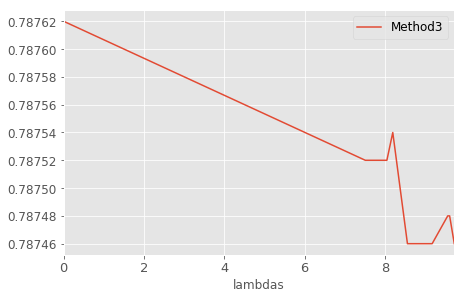

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the writer with $\lambda$s with (7.5, 10)e4

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_11lmbdas_ar1_3lyrs_he1_75_10', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 11
a = np.random.uniform(low=7.5, high=10.0, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.85851235 8.19592346 8.56129398 9.61194033 7.51179714 7.8039228
 9.17687271 9.56463189 7.84176647 8.93773332 9.72830489]
()
[75117.97140477 78039.22801958 78417.66474212 81959.23462734
 85612.93976873 88585.12354477 89377.33323568 91768.72711817
 95646.31887763 96119.403308   97283.04885781]
()
([0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 78039.22801957786, 78417.66474212382, 81959.23462

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(60, 60)


In [13]:
np.array_equal(np_weights[0], np_weights[11])

True

In [14]:
np.array_equal(np_weights[0], np_weights[12])

False

### Commence training

In [15]:
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.011209965
Method 3 test accuracy:0.78979998827
Training with lmbda:75117.9714048, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.153836905956 and training accuracy:0.964425384998
validation cost:0.149323090911 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10382335633 and training accuracy:0.972061812878
validation cost:0.100419342518 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0825118497014 and training accuracy:0.975507557392
validation cost:0.0803260579705 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0690311715007 and training accuracy:0.979884505272
validation cost:0.063497364521 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0600628107786 and training accuracy:0.983330249786
validation cost:0.0547851137817 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0536887310445 and training accuracy:0.985192775726
validation cost:0.0500510074198 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0485435649753 and train

Training on :(6, 7)
training cost:0.0101387770846 and training accuracy:0.998917639256
validation cost:0.010450527072 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00904191937298 and training accuracy:0.999098062515
validation cost:0.00887104682624 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.692113876
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153822347522 and training accuracy:0.964518547058
validation cost:0.149019554257 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103666186333 and training accuracy:0.972248077393
validation cost:0.100262284279 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0242254137993 and training accuracy:0.997925519943
validation cost:0.0251228194684 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190882645547 and training accuracy:0.998015701771
validation cost:0.0194757021964 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156674105674 and training accuracy:0.998376488686
validation cost:0.0162552781403 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131933540106 and training accuracy:0.9987372756
validation cost:0.0132505828515 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0114335697144 and training accuracy:0.998556852341
validation cost:0.0116607137024 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101364161819 and training accuracy:0.998917639256
validation cost:0.010437913239 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00908243563026 and 

Training on :(4, 5)
Time taken:113.581077099
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639065504074 and training accuracy:0.991160809994
validation cost:0.0631678625941 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0343281403184 and training accuracy:0.997203946114
validation cost:0.0342959165573 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242078732699 and training accuracy:0.997925519943
validation cost:0.0248786602169 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.019029090181 and training accuracy:0.998105883598
validation cost:0.0191331338137 and validation accuracy:0.9963

Training on :(4, 5)
training cost:0.0238360613585 and training accuracy:0.997756123543
validation cost:0.0179852824658 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.020196646452 and training accuracy:0.998341441154
validation cost:0.0149767668918 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0173669699579 and training accuracy:0.998341441154
validation cost:0.0126678189263 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0157250855118 and training accuracy:0.998048782349
validation cost:0.0115619245917 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0142215723172 and training accuracy:0.998341441154
validation cost:0.0103907128796 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.889478922
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.098976187408 and training accuracy:0.991609752178
validation cost:0.0924149677157 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0541390888393 and training accuracy:0.992780506611
validation cost:0.0479610413313 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0379330180585 and training accuracy:0.994634151459
validation cost:0.0298050567508 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0293912421912 and training accuracy:0.996682941914
validation cost:0.0230122767389 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0238639675081 and training accuracy:0.997756123543
validation cost:0.0179974716157 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0202240161598 and training accuracy:0.998341441154
validation cost:0.0150300748646 and 

Training on :(2, 3)
training cost:0.0509592220187 and training accuracy:0.983183324337
validation cost:0.0507673285902 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0466038286686 and training accuracy:0.985546767712
validation cost:0.0466840267181 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0428772233427 and training accuracy:0.987273871899
validation cost:0.0416418090463 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:121.486817122
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0988612547517 and training accuracy:0.991609752178
validation cost:0.0913967117667 and validation accuracy:0.99703848

Training on :(2, 3)
training cost:0.113404043019 and training accuracy:0.968366503716
validation cost:0.120848722756 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0888367816806 and training accuracy:0.97309333086
validation cost:0.0928904414177 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0739026740193 and training accuracy:0.974093258381
validation cost:0.0790253654122 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0647318512201 and training accuracy:0.977092981339
validation cost:0.0672434642911 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0565507002175 and training accuracy:0.980729043484
validation cost:0.0583482198417 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0509078428149 and training accuracy:0.982910633087
validation cost:0.050512842834 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0464681424201 and training 

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.035738945
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168385192752 and training accuracy:0.950004518032
validation cost:0.169110611081 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113434426486 and training accuracy:0.968548297882
validation cost:0.12116727978 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886235907674 and training accuracy:0.972911536694
validation cost:0.0931989625096 and validation accuracy:0.96783

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.443413973
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0486841313541 and training accuracy:0.986403405666
validation cost:0.0472118631005 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.044772259891 and training accuracy:0.987893462181
validation cost:0.04408133775 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0415276028216 and training accuracy:0.988359093666
validation cost:0.0401640608907 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.137481928
Method 3 test accuracy:0.780900001526
Training with lmbda:0, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.9951414465

Training on :(8, 9)
training cost:0.104966908693 and training accuracy:0.968429863453
validation cost:0.101662240922 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0838570669293 and training accuracy:0.975228190422
validation cost:0.0826450809836 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0704691037536 and training accuracy:0.979512035847
validation cost:0.0700912177563 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0619770400226 and training accuracy:0.981747090816
validation cost:0.059368930757 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0556346476078 and training accuracy:0.984168350697
validation cost:0.0533436946571 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0496507994831 and training accuracy:0.985658407211
validation cost:0.0468872338533 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448518916965 and tra

training cost:0.0100798970088 and training accuracy:0.999098062515
validation cost:0.0101417824626 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00914821494371 and training accuracy:0.99927842617
validation cost:0.00908604264259 and validation accuracy:1.0
Training on :(6, 7)
Time taken:123.114251137
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15453068912 and training accuracy:0.963401019573
validation cost:0.152509748936 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.105428077281 and training accuracy:0.968709230423
validation cost:0.102065883577 and validation accuracy:0.975517868996
Training on :(8, 9)
train

Training on :(6, 7)
training cost:0.0241254400462 and training accuracy:0.998196065426
validation cost:0.0246706996113 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.018630662933 and training accuracy:0.998556852341
validation cost:0.0192007031292 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0151555901393 and training accuracy:0.998647093773
validation cost:0.0152837466449 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0130035411566 and training accuracy:0.998827457428
validation cost:0.0133294891566 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113382926211 and training accuracy:0.999007821083
validation cost:0.0111597971991 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101022142917 and training accuracy:0.999007821083
validation cost:0.0101169170812 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00918994564563 and trai

training cost:0.0154782123864 and training accuracy:0.997560977936
validation cost:0.0097478935495 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.446880102
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620010979474 and training accuracy:0.992694139481
validation cost:0.0629076212645 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341748595238 and training accuracy:0.997835278511
validation cost:0.0348805896938 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241136979312 and training accuracy:0.998196065426
validation cost:0.0244966819882 and validation accuracy:0.9981752038
Training on :(6, 7)
tr

Training on :(4, 5)
training cost:0.0311432536691 and training accuracy:0.996097564697
validation cost:0.0239992979914 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254982933402 and training accuracy:0.996292710304
validation cost:0.0195289123803 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212124753743 and training accuracy:0.997073173523
validation cost:0.0153550971299 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186316072941 and training accuracy:0.99726831913
validation cost:0.012904974632 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0168396364897 and training accuracy:0.997463405132
validation cost:0.0112094143406 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015247293748 and training accuracy:0.997560977936
validation cost:0.00982174742967 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.619308949
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100072264671 and training accuracy:0.991707324982
validation cost:0.0895595178008 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0546422563493 and training accuracy:0.993073165417
validation cost:0.0472769774497 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395639874041 and training accuracy:0.994926810265
validation cost:0.0323345661163 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0310902222991 and training accuracy:0.996195137501
validation cost:0.0234501156956 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0254913717508 and training accuracy:0.996292710304
validation cost:0.0195671450347 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0213172920048 and training accuracy:0.997073173523
validation c

Training on :(2, 3)
training cost:0.0521844998002 and training accuracy:0.985092282295
validation cost:0.0573013313115 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0474345572293 and training accuracy:0.986092150211
validation cost:0.0528268925846 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0444258674979 and training accuracy:0.987455666065
validation cost:0.0494688153267 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:121.710781813
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100047759712 and training accuracy:0.991804897785
validation cost:0.0895595103502 and validation accuracy:0.995

Training on :(2, 3)
training cost:0.11614189297 and training accuracy:0.968639194965
validation cost:0.11943076551 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903376936913 and training accuracy:0.974729597569
validation cost:0.0985019877553 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0756810083985 and training accuracy:0.977183878422
validation cost:0.0860212445259 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0661587491632 and training accuracy:0.978820085526
validation cost:0.0742029622197 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0591691359878 and training accuracy:0.982456147671
validation cost:0.0653409585357 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0520876608789 and training accuracy:0.985183179379
validation cost:0.0572772100568 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.047382067889 and tra

Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:127.819032907
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172660335898 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.11614189297 and training accuracy:0.968639194965
validation cost:0.11943076551 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903359279037 and training accuracy:0.974729597569
validation cost:0.0984876006842 and validation accuracy:0.97150737

Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.103183031
C

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0495459064841 and training accuracy:0.986124038696
validation cost:0.0472678132355 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0451401881874 and training accuracy:0.987055301666
validation cost:0.0436754375696 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0418114215136 and training accuracy:0.987986564636
validation cost:0.0411744751036 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:118.537163019
Method 3 test accuracy:0.794799983501
Training with lmbda:97283.0488578, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622

Training on :(8, 9)
training cost:0.105352394283 and training accuracy:0.969174921513
validation cost:0.101996988058 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0844190344214 and training accuracy:0.974669396877
validation cost:0.0812723189592 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0708524435759 and training accuracy:0.979418873787
validation cost:0.0702792555094 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0617915317416 and training accuracy:0.982398927212
validation cost:0.0587802752852 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0554417818785 and training accuracy:0.984540879726
validation cost:0.0526164509356 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.049585390836 and training accuracy:0.985844671726
validation cost:0.0472056753933 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0450709052384 and trai

Training on :(6, 7)
training cost:0.00864860136062 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.410341024
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150494784117 and training accuracy:0.963401019573
validation cost:0.148497834802 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.102353192866 and training accuracy:0.972341239452
validation cost:0.101713344455 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.083420984447 and training accuracy:0.975693821907
validation cost:0.0832629576325 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0183473136276 and training accuracy:0.998376488686
validation cost:0.0187788549811 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149370962754 and training accuracy:0.998376488686
validation cost:0.0144498916343 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128197111189 and training accuracy:0.998466670513
validation cost:0.0129445167258 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0112115265802 and training accuracy:0.998827457428
validation cost:0.0115833552554 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.00994374230504 and training accuracy:0.999007821083
validation cost:0.0101797971874 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00889002718031 and training accuracy:0.999098062515
validation cost:0.00902260933071 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:122.948436975
Curr

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619778744876 and training accuracy:0.991882383823
validation cost:0.0614959336817 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337478853762 and training accuracy:0.997023522854
validation cost:0.0349341370165 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234241336584 and training accuracy:0.998196065426
validation cost:0.0244643613696 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0184018071741 and training accuracy:0.998376488686
validation cost:0.0188780296594 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149184986949 and training accuracy:0.998376488686
validation cost:0.0144067658111 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128539893776 and training accuracy:0.998466670513
validation 

Training on :(4, 5)
training cost:0.0176348220557 and training accuracy:0.998243927956
validation cost:0.0132496263832 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.015848973766 and training accuracy:0.998341441154
validation cost:0.0122381318361 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0144896330312 and training accuracy:0.998439013958
validation cost:0.011537653394 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.379582882
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620821081102 and training accuracy:0.991702020168
validation cost:0.0611779987812 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.0527639091015 and training accuracy:0.994926810265
validation cost:0.0473769418895 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.038008350879 and training accuracy:0.995999991894
validation cost:0.0325503721833 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289730876684 and training accuracy:0.997658550739
validation cost:0.0241014584899 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0237669162452 and training accuracy:0.997560977936
validation cost:0.0194174591452 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200986564159 and training accuracy:0.998048782349
validation cost:0.0151099627838 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0176378116012 and training accuracy:0.998243927956
validation cost:0.013330694288 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0158957242966 and training accuracy:0.998341441154
validation cost:0.0124

Training on :(2, 3)
training cost:0.0424053296447 and training accuracy:0.986819386482
validation cost:0.0421728901565 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.552802086
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0966251343489 and training accuracy:0.993365824223
validation cost:0.0911082327366 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0528138689697 and training accuracy:0.994926810265
validation cost:0.0475090667605 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0379520654678 and training accuracy:0.996097564697
validation cost:0.0327371656895 and validation accuracy:1.0


Training on :(2, 3)
training cost:0.0704207867384 and training accuracy:0.977456569672
validation cost:0.0717972293496 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620319917798 and training accuracy:0.979001879692
validation cost:0.063433110714 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0549093037844 and training accuracy:0.9817289114
validation cost:0.0560600496829 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0495077297091 and training accuracy:0.983819663525
validation cost:0.0482592582703 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0463174730539 and training accuracy:0.984819591045
validation cost:0.0462377034128 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0423813350499 and training accuracy:0.986910283566
validation cost:0.0420241989195 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:121.69587779
Current mas

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.107112951577 and training accuracy:0.971184432507
validation cost:0.106819964945 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0834360271692 and training accuracy:0.975184082985
validation cost:0.082379616797 and validation accuracy:0.973345577717
Training on :(2, 3)
training cost:0.0704340711236 and training accuracy:0.977638423443
validation cost:0.0716751888394 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620285905898 and training accuracy:0.979183733463
validation cost:0.0635455548763 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.054847497493 and training accuracy:0.9817289114
validation cost:0.0

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.041901112
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0421020537615 and training accuracy:0.987986564636
validation cost:0.0403355322778 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.220602036
Method 3 test accuracy:0.787899971008
Training with lmbda:96119.403308, 34
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 

Training on :(8, 9)
training cost:0.0699770152569 and training accuracy:0.978487610817
validation cost:0.0692854598165 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609461627901 and training accuracy:0.982026457787
validation cost:0.0585944391787 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0538924783468 and training accuracy:0.984168350697
validation cost:0.0521825365722 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0490600951016 and training accuracy:0.985658407211
validation cost:0.0474438033998 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0450747460127 and training accuracy:0.987334728241
validation cost:0.0429281331599 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0419042855501 and training accuracy:0.988079726696
validation cost:0.0402523465455 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:118.468575954
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150331676006 and training accuracy:0.964239180088
validation cost:0.147141233087 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103209413588 and training accuracy:0.971968710423
validation cost:0.103051297367 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0837777480483 and training accuracy:0.975600659847
validation cost:0.085197404027 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0701616033912 and training accuracy:0.978673875332
validation cost:0.0694941878319 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.060812395066 and training accuracy:0.982212722301
validation cost:0.0583771318197 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539480186999 and training accuracy:0.984168350697
validation cost:0.

Training on :(6, 7)
training cost:0.0115250283852 and training accuracy:0.998556852341
validation cost:0.0119702173397 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101073002443 and training accuracy:0.9987372756
validation cost:0.0104008261114 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00918213743716 and training accuracy:0.998827457428
validation cost:0.00931342691183 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:137.529551029
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.1503149122 and training accuracy:0.963680386543
validation cost:0.150966629386 and validation accuracy:0.959510

Training on :(6, 7)
training cost:0.0365742444992 and training accuracy:0.996572554111
validation cost:0.0356234833598 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0259965881705 and training accuracy:0.997564733028
validation cost:0.0256560128182 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0202693659812 and training accuracy:0.997745096684
validation cost:0.0195685718209 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162180028856 and training accuracy:0.998105883598
validation cost:0.0153207359836 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137576460838 and training accuracy:0.998376488686
validation cost:0.0138219660148 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117146475241 and training accuracy:0.998556852341
validation cost:0.0122512932867 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104330694303 and tr

training cost:0.0171323660761 and training accuracy:0.997365832329
validation cost:0.0125984335318 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0154739692807 and training accuracy:0.997463405132
validation cost:0.0110949091613 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:122.026217937
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679158046842 and training accuracy:0.990258872509
validation cost:0.066998116672 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0364875346422 and training accuracy:0.996572554111
validation cost:0.0356640070677 and validation accuracy:0.9981752038
Training on :

Training on :(4, 5)
training cost:0.0376236438751 and training accuracy:0.994926810265
validation cost:0.0308784414083 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0294845663011 and training accuracy:0.996682941914
validation cost:0.022687677294 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0247660800815 and training accuracy:0.996975600719
validation cost:0.0181243792176 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215961616486 and training accuracy:0.997365832329
validation cost:0.0153548251837 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0191075857729 and training accuracy:0.997463405132
validation cost:0.0135859195143 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.017243059352 and training accuracy:0.997365832329
validation cost:0.0126366894692 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0155066363513 and training accuracy:0.99

Training on :(2, 3)
training cost:0.0416738688946 and training accuracy:0.987001180649
validation cost:0.0461941063404 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:129.050164223
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0954852178693 and training accuracy:0.991999983788
validation cost:0.0895950272679 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0530428551137 and training accuracy:0.992975592613
validation cost:0.0452360101044 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0376278720796 and training accuracy:0.994926810265
validation cost:0.030565854162 and validation accuracy:0.9990

Training on :(2, 3)
training cost:0.0695600807667 and training accuracy:0.977729320526
validation cost:0.0767798423767 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0611925497651 and training accuracy:0.979729115963
validation cost:0.0683751478791 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0538575313985 and training accuracy:0.982456147671
validation cost:0.0581151917577 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0493303313851 and training accuracy:0.984274148941
validation cost:0.0528823435307 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0454167574644 and training accuracy:0.985728561878
validation cost:0.0491918027401 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0416537225246 and training accuracy:0.987273871899
validation cost:0.0463530868292 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:122.11205101
Current 

Training on :(0, 1)
Time taken:127.883944035
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162099152803 and training accuracy:0.953822374344
validation cost:0.167225301266 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108113572001 and training accuracy:0.971457123756
validation cost:0.109079107642 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0838573127985 and training accuracy:0.975820362568
validation cost:0.0887906253338 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.069667764008 and training accuracy:0.977820217609
validation cost:0.0767827033997 and validation accuracy:0.970588207245
T

Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:127.921876907
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Vali

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998

Training on :(8, 9)
training cost:0.0519897155464 and training accuracy:0.985379040241
validation cost:0.0500081479549 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0472787581384 and training accuracy:0.986682832241
validation cost:0.0455585382879 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0435055494308 and training accuracy:0.987148463726
validation cost:0.0410305820405 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:119.272642851
Method 3 test accuracy:0.797599971294
Training with lmbda:95646.3188776, 45
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062

Training on :(8, 9)
training cost:0.104868650436 and training accuracy:0.971968710423
validation cost:0.107577465475 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0852393060923 and training accuracy:0.973738133907
validation cost:0.0855125933886 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0728708282113 and training accuracy:0.978394508362
validation cost:0.0724294111133 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0628271251917 and training accuracy:0.982212722301
validation cost:0.0633487999439 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0566391870379 and training accuracy:0.984075248241
validation cost:0.0546236559749 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0520124472678 and training accuracy:0.985472142696
validation cost:0.0503733642399 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0471248626709 and 

training cost:0.0104821519926 and training accuracy:0.9987372756
validation cost:0.0111053371802 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00949028600007 and training accuracy:0.998827457428
validation cost:0.00986072048545 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:123.158860922
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150855898857 and training accuracy:0.963401019573
validation cost:0.154398515821 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.104005746543 and training accuracy:0.972248077393
validation cost:0.105876930058 and validation accuracy:0.973634660244
Training on :

Training on :(6, 7)
training cost:0.0259700287133 and training accuracy:0.997384309769
validation cost:0.0257840957493 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0203153789043 and training accuracy:0.997745096684
validation cost:0.0197648666799 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162978507578 and training accuracy:0.998196065426
validation cost:0.015631582588 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137451030314 and training accuracy:0.998556852341
validation cost:0.0140545610338 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117359617725 and training accuracy:0.998556852341
validation cost:0.0119873089716 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104651032016 and training accuracy:0.9987372756
validation cost:0.011041617021 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00955755356699 and train

Training on :(4, 5)
Time taken:114.334095955
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0629686638713 and training accuracy:0.990709841251
validation cost:0.063085667789 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347865857184 and training accuracy:0.996572554111
validation cost:0.0342171937227 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0245375912637 and training accuracy:0.997474491596
validation cost:0.0253121834248 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0194009188563 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0241878777742 and training accuracy:0.997170746326
validation cost:0.0180740915239 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209347400814 and training accuracy:0.997170746326
validation cost:0.014266253449 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184335317463 and training accuracy:0.997463405132
validation cost:0.0123080359772 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0165394619107 and training accuracy:0.997365832329
validation cost:0.0106113450602 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0150879118592 and training accuracy:0.997463405132
validation cost:0.00938514713198 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.131256104
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0942446738482 and training accuracy:0.993463397026
validation cost:0.0833255201578 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0534818395972 and training accuracy:0.993073165417
validation cost:0.0437033511698 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377921238542 and training accuracy:0.994829297066
validation cost:0.0294512026012 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0291069876403 and training accuracy:0.996390223503
validation cost:0.0224618222564 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0241432543844 and training accuracy:0.997073173523
validation cost:0.0180117469281 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209344960749 and training accuracy:0.99726831913
validation cost:0.0142966872081 and validatio

Training on :(2, 3)
training cost:0.0521842092276 and training accuracy:0.983910560608
validation cost:0.0546438992023 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477249547839 and training accuracy:0.985637664795
validation cost:0.0513819418848 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0442402586341 and training accuracy:0.986546695232
validation cost:0.0474807396531 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:121.756142139
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0944822877645 and training accuracy:0.993463397026
validation cost:0.0840704366565 and validation accuracy:0.99802565

Training on :(2, 3)
training cost:0.115122787654 and training accuracy:0.968366503716
validation cost:0.119388438761 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0912728235126 and training accuracy:0.971729815006
validation cost:0.0964259728789 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0760823339224 and training accuracy:0.975002288818
validation cost:0.0818870663643 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0652695819736 and training accuracy:0.979183733463
validation cost:0.0662479698658 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0578274950385 and training accuracy:0.981819808483
validation cost:0.0605131089687 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0523517765105 and training accuracy:0.984092354774
validation cost:0.0547119416296 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477487668395 and trainin

Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.047772884
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171819314361 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115139946342 and training accuracy:0.968366503716
validation cost:0.119561992586 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913570523262 and training accuracy:0.971729815006
validation cost:0.0964259728789 and validation accuracy:0.9687

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:127.461713076
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0491452142596 and training accuracy:0.985937774181
validation cost:0.0472751818597 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0448446087539 and training accuracy:0.987800359726
validation cost:0.0436350107193 and validation accuracy:0.992467045784
Training on :(8, 9)
training cost:0.0424458682537 and training accuracy:0.988079726696
validation cost:0.0426973290741 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:119.23467207
Method 3 test accuracy:0.778299987316
Training with lmbda:91768.7271182, 56
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accurac

Training on :(8, 9)
training cost:0.103351868689 and training accuracy:0.971503078938
validation cost:0.101566515863 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0822013616562 and training accuracy:0.976066291332
validation cost:0.0817706361413 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692570433021 and training accuracy:0.980536401272
validation cost:0.068793579936 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0611932165921 and training accuracy:0.982864618301
validation cost:0.0598175153136 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539230331779 and training accuracy:0.984727144241
validation cost:0.0509490929544 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0489925183356 and training accuracy:0.986217200756
validation cost:0.0466404259205 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0450993292034 and t

Training on :(6, 7)
training cost:0.00964837148786 and training accuracy:0.998917639256
validation cost:0.00956209935248 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:122.729166031
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151790380478 and training accuracy:0.966939866543
validation cost:0.148056328297 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.103241428733 and training accuracy:0.971503078938
validation cost:0.10190666467 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0821164548397 and training accuracy:0.975786924362
validation cost:0.0813427641988 and validation accuracy:0.9792843

Training on :(6, 7)
training cost:0.0195995382965 and training accuracy:0.997384309769
validation cost:0.0206369291991 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0160359572619 and training accuracy:0.997654914856
validation cost:0.0169270075858 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0138023337349 and training accuracy:0.998015701771
validation cost:0.0141139831394 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0120247332379 and training accuracy:0.998196065426
validation cost:0.0127968331799 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0107433199883 and training accuracy:0.998466670513
validation cost:0.011371685192 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0096881724894 and training accuracy:0.998827457428
validation cost:0.00962863955647 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:123.12809515
Current ma

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0627911537886 and training accuracy:0.990980446339
validation cost:0.0634372830391 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347861684859 and training accuracy:0.996662735939
validation cost:0.0346069782972 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0247806087136 and training accuracy:0.997654914856
validation cost:0.0256727673113 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0195884797722 and training accuracy:0.997384309769
validation cost:0.0206439364702 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.015999969095 and training accuracy:0.997654914856
validation cost:0.0165382213891 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0138052655384 and training accuracy:0.997925519943
validation c

### Final accuracies

In [16]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_11lmbdas_ar1_3lyrs_he1_75_10.csv')
final_test_acc

Method3       lambdas
0    0.7898      0.000000
1    0.7810  75117.971405
2    0.7806  78039.228020
3    0.7811  78417.664742
4    0.7802  81959.234627
5    0.7807  85612.939769
6    0.7799  88585.123545
7    0.7805  89377.333236
8    0.7806  91768.727118
9    0.7889  95646.318878
10   0.7802  96119.403308
11   0.7809  97283.048858
12   0.7927      0.000000
13   0.7939  75117.971405
14   0.7944  78039.228020
15   0.7942  78417.664742
16   0.7946  81959.234627
17   0.7946  85612.939769
18   0.7940  88585.123545
19   0.7942  89377.333236
20   0.7943  91768.727118
21   0.7947  95646.318878
22   0.7948  96119.403308
23   0.7952  97283.048858
24   0.7879      0.000000
25   0.7875  75117.971405
26   0.7873  78039.228020
27   0.7874  78417.664742
28   0.7878  81959.234627
29   0.7874  85612.939769
30   0.7871  88585.123545
31   0.7875  89377.333236
32   0.7876  91768.727118
33   0.7879  95646.318878
34   0.7879  96119.403308
35   0.7873  97283.048858
36   0.7893      0.000000
37   0.7847  75117.971405
38   0.7968  78039.228020
39   0.8064  78417.664742
40   0.7917  81959.234627
41   0.7973  85612.939769
42   0.7976  88585.123545
43   0.7969  89377.333236
44   0.7976  91768.727118
45   0.7896  95646.318878
46   0.7978  96119.403308
47   0.7976  97283.048858
48   0.7784      0.000000
49   0.7795  75117.971405
50   0.7784  78039.228020
51   0.7790  78417.664742
52   0.7786  81959.234627
53   0.7789  85612.939769
54   0.7789  88585.123545
55   0.7783  89377.333236
56   0.7782  91768.727118
57   0.7783  95646.318878
58   0.7781  96119.403308
59   0.7786  97283.048858

#### Groupby $\lambda$s

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000      0.78762
75117.971405  0.78532
78039.228020  0.78750
78417.664742  0.78962
81959.234627  0.78658
85612.939769  0.78778
88585.123545  0.78750
89377.333236  0.78748
91768.727118  0.78766
95646.318878  0.78788
96119.403308  0.78776
97283.048858  0.78792

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

Method3
lambdas               
0.000000      0.005442
75117.971405  0.005729
78039.228020  0.008133
78417.664742  0.011100
81959.234627  0.007007
85612.939769  0.008159
88585.123545  0.008309
89377.333236  0.008168
91768.727118  0.008400
95646.318878  0.005964
96119.403308  0.008673
97283.048858  0.008415

In [19]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000       0.7927
75117.971405   0.7939
78039.228020   0.7968
78417.664742   0.8064
81959.234627   0.7946
85612.939769   0.7973
88585.123545   0.7976
89377.333236   0.7969
91768.727118   0.7976
95646.318878   0.7947
96119.403308   0.7978
97283.048858   0.7976

#### Plots

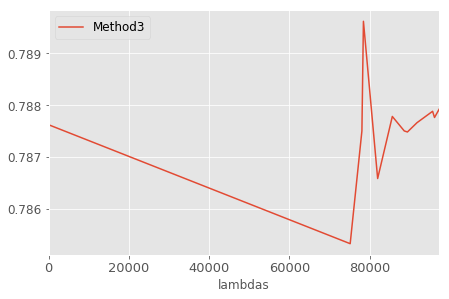

In [20]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

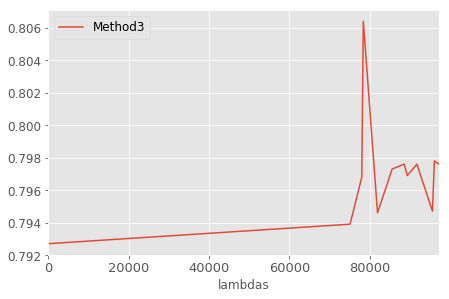

In [21]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

max_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the writer with $\lambda$s (7.5, 8.75)

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_11lmbdas_ar1_3lyrs_he1_75_875', sess.graph)

### Generate $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 11
a = np.random.uniform(low=7.5, high=8.75, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 5
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.17925618 7.84796173 8.03064699 8.55597017 7.50589857 7.6519614
 8.33843636 8.53231594 7.67088324 8.21886666 8.61415244]
()
[75058.98570239 76519.61400979 76708.83237106 78479.61731367
 80306.46988436 81792.56177239 82188.66661784 83384.36355908
 85323.15943881 85559.701654   86141.5244289 ]
()
([0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.61731367245, 80306.46988436417, 81792.56177238707, 82188.66661784063, 83384.36355908474, 85323.15943881309, 85559.7016539988, 86141.5244289033, 0, 75058.98570238716, 76519.61400978893, 76708.83237106192, 78479.6173

### Generate random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(60, 60)


In [12]:
np.array_equal(np_weights[0], np_weights[11])

True

In [13]:
np.array_equal(np_weights[0], np_weights[12])

False

### Commence training

In [14]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:120.912705898
Method 3 test accuracy:0.78979998827
Training with lmbda:75058.9857024, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339

Training on :(8, 9)
training cost:0.153980225325 and training accuracy:0.964332282543
validation cost:0.149577140808 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103872045875 and training accuracy:0.972154974937
validation cost:0.100628592074 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.082523368299 and training accuracy:0.975600659847
validation cost:0.0799287632108 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0692573264241 and training accuracy:0.979698240757
validation cost:0.064111687243 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0602122843266 and training accuracy:0.983330249786
validation cost:0.0548208765686 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0537882000208 and training accuracy:0.985099673271
validation cost:0.050118599087 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0486051179469 and trainin

Training on :(6, 7)
training cost:0.0100795924664 and training accuracy:0.998917639256
validation cost:0.0104372994974 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00906612537801 and training accuracy:0.999098062515
validation cost:0.00893348734826 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.333760023
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153698772192 and training accuracy:0.964425384998
validation cost:0.147991970181 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103767223656 and training accuracy:0.972154974937
validation cost:0.0997932478786 and validation accuracy:0.9783

Training on :(6, 7)
training cost:0.0242274384946 and training accuracy:0.997925519943
validation cost:0.0250753369182 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190337151289 and training accuracy:0.998015701771
validation cost:0.0195076335222 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156096555293 and training accuracy:0.998376488686
validation cost:0.0163432881236 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131616480649 and training accuracy:0.9987372756
validation cost:0.0133023979142 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113771837205 and training accuracy:0.9987372756
validation cost:0.0117523632944 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101460944861 and training accuracy:0.998917639256
validation cost:0.0104345716536 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00906177796423 and t

Training on :(4, 5)
Time taken:115.703335047
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0639021620154 and training accuracy:0.991250991821
validation cost:0.062863856554 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0343353897333 and training accuracy:0.997203946114
validation cost:0.0344043150544 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242029502988 and training accuracy:0.997925519943
validation cost:0.0248681530356 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0189717207104 and training accuracy:0.998015701771
validation cost:0.0194843169302 and validation accuracy:0.9954

Training on :(4, 5)
training cost:0.0238604675978 and training accuracy:0.997756123543
validation cost:0.0179691314697 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0201689265668 and training accuracy:0.998341441154
validation cost:0.0149531615898 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0173454768956 and training accuracy:0.998243927956
validation cost:0.0128394141793 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0157125219703 and training accuracy:0.998048782349
validation cost:0.0114953527227 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141979530454 and training accuracy:0.998146355152
validation cost:0.0103904325515 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.803655148
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989983901381 and training accuracy:0.991512179375
validation cost:0.0917630121112 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0542484335601 and training accuracy:0.992780506611
validation cost:0.0481384173036 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0380006060004 and training accuracy:0.994634151459
validation cost:0.0300817918032 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0292697418481 and training accuracy:0.996682941914
validation cost:0.0226752944291 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239373426884 and training accuracy:0.997658550739
validation cost:0.0181809980422 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0202227700502 and training accuracy:0.998341441154
validation cost:0.0149592664093 and

Training on :(2, 3)
training cost:0.0510635077953 and training accuracy:0.982910633087
validation cost:0.0510738231242 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465391166508 and training accuracy:0.985546767712
validation cost:0.0468710027635 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.042725905776 and training accuracy:0.987455666065
validation cost:0.0415708385408 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:123.739256859
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0989584326744 and training accuracy:0.991512179375
validation cost:0.0917041823268 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113498516381 and training accuracy:0.968457400799
validation cost:0.120995566249 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886741653085 and training accuracy:0.973184227943
validation cost:0.0928004309535 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0736535638571 and training accuracy:0.974275052547
validation cost:0.0785301029682 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0645888373256 and training accuracy:0.977547466755
validation cost:0.0673339515924 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0564976036549 and training accuracy:0.980729043484
validation cost:0.0583416074514 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0510624311864 and training accuracy:0.982819736004
validation cost:0.0505601204932 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465190634131 and trainin

Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:130.043063879
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.168326407671 and training accuracy:0.950004518032
validation cost:0.169079318643 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.113501399755 and training accuracy:0.968457400799
validation cost:0.120995566249 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886745974422 and training accuracy:0.973184227943
validation cost:0.0928004309535 and validation accuracy:0.9678

Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997744202614
validation cost:0.00971961114556 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00863864738494 and training accuracy:0.998004496098
validation cost:0.0086479568854 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00776934204623 and training accuracy:0.99809128046
validation cost:0.0084388460964 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00688597885892 and training accuracy:0.998178005219
validation cost:0.00751441437751 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:129.419608116
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0115019194782 and training accuracy:0.997657477856
validation cost:0.0115101812407 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0099402749911 and training accuracy:0.997

training cost:0.0484783425927 and training accuracy:0.986496567726
validation cost:0.0469869822264 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0445472151041 and training accuracy:0.987707197666
validation cost:0.0440437123179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0413887649775 and training accuracy:0.988452196121
validation cost:0.0405404418707 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.978209972
Method 3 test accuracy:0.780600011349
Training with lmbda:0, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.9951414

Training on :(8, 9)
training cost:0.104966908693 and training accuracy:0.968429863453
validation cost:0.101662240922 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0838570669293 and training accuracy:0.975228190422
validation cost:0.0826450809836 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0704691037536 and training accuracy:0.979512035847
validation cost:0.0700912177563 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0619770400226 and training accuracy:0.981747090816
validation cost:0.059368930757 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0556346476078 and training accuracy:0.984168350697
validation cost:0.0533436946571 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0496507994831 and training accuracy:0.985658407211
validation cost:0.0468872338533 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448518916965 and tra

training cost:0.0100237559527 and training accuracy:0.999098062515
validation cost:0.0101264910772 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00914928130805 and training accuracy:0.99927842617
validation cost:0.00908628851175 and validation accuracy:1.0
Training on :(6, 7)
Time taken:124.902240992
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.154402375221 and training accuracy:0.963401019573
validation cost:0.152796715498 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.10538803786 and training accuracy:0.968616127968
validation cost:0.101608090103 and validation accuracy:0.975517868996
Training on :(8, 9)
trai

Training on :(6, 7)
training cost:0.0241254959255 and training accuracy:0.998196065426
validation cost:0.0245857164264 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0185619164258 and training accuracy:0.998556852341
validation cost:0.0192114822567 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.015081868507 and training accuracy:0.998647093773
validation cost:0.0152813410386 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0130035495386 and training accuracy:0.998827457428
validation cost:0.0134089523926 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113246366382 and training accuracy:0.999007821083
validation cost:0.0113258128986 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0100113842636 and training accuracy:0.999007821083
validation cost:0.0102030020207 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00919094961137 and trai

training cost:0.0152439260855 and training accuracy:0.997560977936
validation cost:0.00972138810903 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.906499147
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619933493435 and training accuracy:0.992784321308
validation cost:0.0630115494132 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0341687165201 and training accuracy:0.997745096684
validation cost:0.0349271260202 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0242073517293 and training accuracy:0.998196065426
validation cost:0.0245896894485 and validation accuracy:0.9981752038
Training on :(6, 7)
t

Training on :(4, 5)
training cost:0.0311512183398 and training accuracy:0.996097564697
validation cost:0.0240539163351 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254935864359 and training accuracy:0.996292710304
validation cost:0.0195911936462 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0213168431073 and training accuracy:0.996975600719
validation cost:0.0152686322108 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186760704964 and training accuracy:0.997170746326
validation cost:0.0129006141797 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0167978983372 and training accuracy:0.997463405132
validation cost:0.0112070348114 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0153752854094 and training accuracy:0.997560977936
validation cost:0.00975950714201 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.774825096
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test 

Time taken:124.055869102
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0998966991901 and training accuracy:0.991804897785
validation cost:0.0895265564322 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0547585263848 and training accuracy:0.992975592613
validation cost:0.0472773835063 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395401082933 and training accuracy:0.994926810265
validation cost:0.0323188789189 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.031132536009 and training accuracy:0.996097564697
validation cost:0.0240289866924 and validation accuracy:0.998025655746
Training o

Training on :(2, 3)
training cost:0.066069200635 and training accuracy:0.978910982609
validation cost:0.0742588639259 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0589921176434 and training accuracy:0.982456147671
validation cost:0.0657024085522 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0522956177592 and training accuracy:0.985092282295
validation cost:0.0573350191116 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0473038591444 and training accuracy:0.986183047295
validation cost:0.0527751818299 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.0443650297821 and training accuracy:0.987364768982
validation cost:0.0492106229067 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:123.889887094
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172655671835 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116139009595 and training accuracy:0.968639194965
validation cost:0.11943076551 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0903519690037 and training accuracy:0.974729597569
validation cost:0.0985019877553 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0756814107299 and training accuracy:0.977183878422
validation cost:0.0860360637307 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.066069200635 and training accuracy:0.978910982609
validation cost:0.0742588639259 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0589931569993 and training accuracy:0.982456147671
validation cost:0.

Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:129.81160593
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172655671835 and training accuracy:0.948277413845
validation cost:0.17598554492 and validation accuracy:0.9

Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0071719856932

Training on :(8, 9)
training cost:0.0414215400815 and training accuracy:0.987986564636
validation cost:0.0409275963902 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:121.178705931
Method 3 test accuracy:0.793099999428
Training with lmbda:85559.701654, 22
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 a

Training on :(8, 9)
training cost:0.0709488764405 and training accuracy:0.979418873787
validation cost:0.0709564089775 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0616304837167 and training accuracy:0.982305824757
validation cost:0.0594508089125 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0554433055222 and training accuracy:0.984540879726
validation cost:0.0530577562749 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0494777746499 and training accuracy:0.985937774181
validation cost:0.0470034517348 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0450812503695 and training accuracy:0.987055301666
validation cost:0.0449070632458 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0416844002903 and training accuracy:0.987707197666
validation cost:0.0413485281169 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:121.380127907
Method 3

Time taken:133.913394213
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.154575258493 and training accuracy:0.963307857513
validation cost:0.153341710567 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.10534927249 and training accuracy:0.968988656998
validation cost:0.101513177156 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0842767357826 and training accuracy:0.974762499332
validation cost:0.080613963306 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0709811672568 and training accuracy:0.979325771332
validation cost:0.0709817111492 and validation accuracy:0.980225980282
Training on :(8,

training cost:0.0148392925039 and training accuracy:0.998286306858
validation cost:0.0142422635108 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.012655550614 and training accuracy:0.998556852341
validation cost:0.0128999259323 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0109515367076 and training accuracy:0.998917639256
validation cost:0.0109260976315 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00972819607705 and training accuracy:0.999098062515
validation cost:0.00991043355316 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00864860136062 and training accuracy:0.999098062515
validation cost:0.00887368153781 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:129.074868917
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620270110667 and training accuracy:0.991702020168
validation cost:0.0614616237581 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.033734831959 and training accuracy:0.997023522854
validation cost:0.0349549874663 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234698802233 and training accuracy:0.998196065426
validation cost:0.0244474764913 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183593928814 and training accuracy:0.998376488686
validation cost:0.0187804829329 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149025684223 and training accuracy:0.998376488686
validation cost:0.0144175346941 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128169013187 and training accuracy:0.998466670513
validation c

Training on :(4, 5)
training cost:0.017595725134 and training accuracy:0.998341441154
validation cost:0.0132585940883 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0158335268497 and training accuracy:0.998341441154
validation cost:0.012216521427 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0144932651892 and training accuracy:0.998439013958
validation cost:0.0114999646321 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.610715151
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0620298683643 and training accuracy:0.991792201996
validation cost:0.0613271817565 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.0527354590595 and training accuracy:0.994829297066
validation cost:0.0475841984153 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0380671992898 and training accuracy:0.99590241909
validation cost:0.0324677675962 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289945136756 and training accuracy:0.997658550739
validation cost:0.0240497738123 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0237690620124 and training accuracy:0.997560977936
validation cost:0.0192800108343 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0200979039073 and training accuracy:0.998048782349
validation cost:0.0149981351569 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0176597926766 and training accuracy:0.998341441154
validation cost:0.0134024349973 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0158666986972 and training accuracy:0.998341441154
validation cost:0.012

Training on :(2, 3)
training cost:0.0423728302121 and training accuracy:0.986728489399
validation cost:0.0423074625432 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:133.731517076
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0965206176043 and training accuracy:0.993365824223
validation cost:0.0908777043223 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0528946965933 and training accuracy:0.994926810265
validation cost:0.0477013960481 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0379761680961 and training accuracy:0.99590241909
validation cost:0.0326691009104 and validation accuracy:1.0
T

Training on :(2, 3)
training cost:0.0704060792923 and training accuracy:0.977456569672
validation cost:0.071807205677 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620712935925 and training accuracy:0.979001879692
validation cost:0.0633941814303 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0549685619771 and training accuracy:0.981638014317
validation cost:0.0560600496829 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0494835264981 and training accuracy:0.983910560608
validation cost:0.0482137426734 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0460784621537 and training accuracy:0.985001385212
validation cost:0.0461829267442 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0423309616745 and training accuracy:0.986819386482
validation cost:0.042214140296 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:123.684679031
Current m

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.10712839663 and training accuracy:0.97127532959
validation cost:0.106732428074 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0830616429448 and training accuracy:0.975274980068
validation cost:0.0822008922696 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0703850910068 and training accuracy:0.977547466755
validation cost:0.071807205677 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.062079127878 and training accuracy:0.979001879692
validation cost:0.06339225173 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.054785002023 and training accuracy:0.981638014317
validation cost:0.0561

Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:130.235983133
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.95

Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 a

Training on :(8, 9)
training cost:0.0418087691069 and training accuracy:0.988079726696
validation cost:0.0401695892215 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:121.37883997
Method 3 test accuracy:0.78719997406
Training with lmbda:85323.1594388, 33
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 a

Training on :(8, 9)
training cost:0.0702333897352 and training accuracy:0.978580713272
validation cost:0.0693607479334 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609476007521 and training accuracy:0.982119560242
validation cost:0.0587161555886 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539781562984 and training accuracy:0.984261512756
validation cost:0.0525783598423 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0490031652153 and training accuracy:0.985565304756
validation cost:0.0472151935101 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0451147332788 and training accuracy:0.987241566181
validation cost:0.0428709574044 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0419918075204 and training accuracy:0.987986564636
validation cost:0.0401613973081 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.883712053
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150192335248 and training accuracy:0.964146018028
validation cost:0.14698804915 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103153087199 and training accuracy:0.971968710423
validation cost:0.102991610765 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0835673362017 and training accuracy:0.975693821907
validation cost:0.0845468789339 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0701411068439 and training accuracy:0.978673875332
validation cost:0.0694020912051 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0609013997018 and training accuracy:0.982119560242
validation cost:0.0585441030562 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539998225868 and training accuracy:0.984075248241
validation cost:0

Training on :(6, 7)
training cost:0.0112252729014 and training accuracy:0.998827457428
validation cost:0.0117540825158 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.00995125900954 and training accuracy:0.999007821083
validation cost:0.0101753808558 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00891835149378 and training accuracy:0.999098062515
validation cost:0.00908995978534 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.73544693
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.15043836832 and training accuracy:0.963959753513
validation cost:0.147597819567 and validation accuracy:0.965

Training on :(6, 7)
training cost:0.0364416614175 and training accuracy:0.996392190456
validation cost:0.0359052494168 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0257732402533 and training accuracy:0.997384309769
validation cost:0.0257938690484 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.020039210096 and training accuracy:0.997745096684
validation cost:0.019262008369 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0159926116467 and training accuracy:0.998105883598
validation cost:0.0156124858186 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0134396087378 and training accuracy:0.998556852341
validation cost:0.0136646823958 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0115250283852 and training accuracy:0.998556852341
validation cost:0.0119702173397 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101073002443 and trai

training cost:0.0170974414796 and training accuracy:0.997463405132
validation cost:0.0125584146008 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0154973650351 and training accuracy:0.997463405132
validation cost:0.0109334103763 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:115.673028946
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680620446801 and training accuracy:0.990168690681
validation cost:0.0667530149221 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0365587472916 and training accuracy:0.996572554111
validation cost:0.0356042422354 and validation accuracy:0.9981752038
Training on 

Training on :(4, 5)
training cost:0.0375589393079 and training accuracy:0.994926810265
validation cost:0.0301554314792 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0297137722373 and training accuracy:0.996780514717
validation cost:0.0223173443228 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0247321594507 and training accuracy:0.996975600719
validation cost:0.0182487610728 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0214513540268 and training accuracy:0.997365832329
validation cost:0.0152427507564 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0191574133933 and training accuracy:0.997463405132
validation cost:0.0135198878124 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0171595066786 and training accuracy:0.997463405132
validation cost:0.0122928014025 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0155278798193 and training accuracy:0.99746340513

Training on :(2, 3)
training cost:0.0415878556669 and training accuracy:0.987092077732
validation cost:0.0455010123551 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.445286036
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0952368229628 and training accuracy:0.992195129395
validation cost:0.0891208127141 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0531367957592 and training accuracy:0.993073165417
validation cost:0.0455575101078 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0375466682017 and training accuracy:0.994926810265
validation cost:0.0301373898983 and validation accuracy:0.999

Training on :(2, 3)
training cost:0.0696804150939 and training accuracy:0.977729320526
validation cost:0.0767770558596 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0610232502222 and training accuracy:0.97991091013
validation cost:0.0678356438875 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537730641663 and training accuracy:0.982365250587
validation cost:0.0579754598439 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0491555780172 and training accuracy:0.984274148941
validation cost:0.0528307817876 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0454025603831 and training accuracy:0.985728561878
validation cost:0.0494955517352 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0414680913091 and training accuracy:0.987182974815
validation cost:0.0454086512327 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:123.533147097
Current 

Training on :(0, 1)
Time taken:129.726268053
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162091732025 and training accuracy:0.953822374344
validation cost:0.167225301266 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108093008399 and training accuracy:0.971457123756
validation cost:0.109079107642 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0838002339005 and training accuracy:0.976365804672
validation cost:0.0886277332902 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0696804150939 and training accuracy:0.977729320526
validation cost:0.0767770558596 and validation accuracy:0.970588207245


Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:129.918364048
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Vali

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998

Training on :(8, 9)
training cost:0.05189088732 and training accuracy:0.985379040241
validation cost:0.0503307282925 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0472679696977 and training accuracy:0.986403405666
validation cost:0.0457011945546 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0435345619917 and training accuracy:0.987241566181
validation cost:0.0413287431002 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.595067024
Method 3 test accuracy:0.797399997711
Training with lmbda:83384.3635591, 44
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 a

Training on :(8, 9)
training cost:0.104088962078 and training accuracy:0.972154974937
validation cost:0.107046917081 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0846649184823 and training accuracy:0.974390029907
validation cost:0.0856931954622 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0727285817266 and training accuracy:0.978394508362
validation cost:0.0717790275812 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0629248917103 and training accuracy:0.982212722301
validation cost:0.0633542314172 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.05674559623 and training accuracy:0.983795881271
validation cost:0.0552100427449 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0518122203648 and training accuracy:0.985472142696
validation cost:0.0500272661448 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0472679547966 and tr

training cost:0.0104092406109 and training accuracy:0.9987372756
validation cost:0.0108583439142 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00946891028434 and training accuracy:0.998827457428
validation cost:0.0098473560065 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.556814194
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150808081031 and training accuracy:0.963494122028
validation cost:0.154131278396 and validation accuracy:0.956685483456
Training on :(8, 9)
training cost:0.104113571346 and training accuracy:0.972154974937
validation cost:0.106899686158 and validation accuracy:0.972693026066
Training on :(

Training on :(6, 7)
training cost:0.0260459911078 and training accuracy:0.997384309769
validation cost:0.0258542224765 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0203216411173 and training accuracy:0.997745096684
validation cost:0.0196532383561 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0162764191628 and training accuracy:0.998196065426
validation cost:0.0156322345138 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0137259215117 and training accuracy:0.998466670513
validation cost:0.0140394726768 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0117124533281 and training accuracy:0.998556852341
validation cost:0.0119010759518 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0104400608689 and training accuracy:0.9987372756
validation cost:0.0108534106985 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00948513206095 and tra

training cost:0.0155402086675 and training accuracy:0.997463405132
validation cost:0.0111977383494 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:115.687774897
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0679664537311 and training accuracy:0.990258872509
validation cost:0.0670847222209 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0365458652377 and training accuracy:0.996572554111
validation cost:0.0357870198786 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0259661134332 and training accuracy:0.997384309769
validation cost:0.0259097926319 and validation accuracy:0.9981752038
Training on :(

Training on :(4, 5)
training cost:0.0288092717528 and training accuracy:0.996390223503
validation cost:0.0221864599735 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239357799292 and training accuracy:0.996975600719
validation cost:0.0179479662329 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0206256434321 and training accuracy:0.997170746326
validation cost:0.0143882324919 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0181834287941 and training accuracy:0.99726831913
validation cost:0.0119842672721 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0161860194057 and training accuracy:0.997463405132
validation cost:0.010232088156 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0147315105423 and training accuracy:0.997463405132
validation cost:0.0089998356998 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.846777916
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Len

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943345203996 and training accuracy:0.993463397026
validation cost:0.0832012742758 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0534858629107 and training accuracy:0.99317073822
validation cost:0.0437155328691 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377362817526 and training accuracy:0.994829297066
validation cost:0.0292080491781 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0290011856705 and training accuracy:0.996390223503
validation cost:0.0224236603826 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0241885315627 and training accuracy:0.997073173523
validation cost:0.0180627964437 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209369286895 and training accuracy:0.99726831913
validation cost:0.0142166875303 and validation

Training on :(2, 3)
training cost:0.0522638745606 and training accuracy:0.984092354774
validation cost:0.0546673089266 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477084033191 and training accuracy:0.985637664795
validation cost:0.0514009073377 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0444102585316 and training accuracy:0.986546695232
validation cost:0.0476811230183 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:123.639794827
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943309292197 and training accuracy:0.993463397026
validation cost:0.083454079926 and validation accuracy:0.998025655

Training on :(2, 3)
training cost:0.115142844617 and training accuracy:0.968366503716
validation cost:0.119561992586 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913783088326 and training accuracy:0.971729815006
validation cost:0.0965802669525 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0762215331197 and training accuracy:0.974911391735
validation cost:0.0821544378996 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0649946928024 and training accuracy:0.97909283638
validation cost:0.0661821067333 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0579099394381 and training accuracy:0.981819808483
validation cost:0.0607856586576 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0522638745606 and training accuracy:0.984092354774
validation cost:0.0546673089266 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477156341076 and training

Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:130.391388178
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171822085977 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115122787654 and training accuracy:0.968366503716
validation cost:0.119388438761 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913701802492 and training accuracy:0.971729815006
validation cost:0.0965802669525 and validation accuracy:0.9687

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.114984035
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0492341145873 and training accuracy:0.985844671726
validation cost:0.047589816153 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.045061737299 and training accuracy:0.987334728241
validation cost:0.0437273196876 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.042111787945 and training accuracy:0.988079726696
validation cost:0.0419848635793 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.25474
Method 3 test accuracy:0.779299974442
Training with lmbda:82188.6666178, 55
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.99

Training on :(8, 9)
training cost:0.10340154916 and training accuracy:0.971596181393
validation cost:0.102943055332 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0820826217532 and training accuracy:0.976159453392
validation cost:0.082349024713 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0688940286636 and training accuracy:0.980629563332
validation cost:0.0682429820299 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0610225722194 and training accuracy:0.983050823212
validation cost:0.0601120479405 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0536871552467 and training accuracy:0.985006511211
validation cost:0.0500402003527 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0489651449025 and training accuracy:0.986124038696
validation cost:0.0470593869686 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.045007634908 and trai

Training on :(6, 7)
training cost:0.00957812927663 and training accuracy:0.998917639256
validation cost:0.00954160746187 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.356364012
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.151571914554 and training accuracy:0.967032968998
validation cost:0.147071793675 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.103339895606 and training accuracy:0.971689343452
validation cost:0.102264344692 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0821992754936 and training accuracy:0.976066291332
validation cost:0.082015439868 and validation accuracy:0.9792843

Training on :(6, 7)
training cost:0.0195366479456 and training accuracy:0.997564733028
validation cost:0.0204644910991 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0160129740834 and training accuracy:0.997654914856
validation cost:0.0167377665639 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0137207647786 and training accuracy:0.998015701771
validation cost:0.0139159597456 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0119621334597 and training accuracy:0.998196065426
validation cost:0.0127283111215 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0107225440443 and training accuracy:0.998466670513
validation cost:0.0113266371191 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00957598537207 and training accuracy:0.998917639256
validation cost:0.0096132978797 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.860145092
Current 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0627222210169 and training accuracy:0.990890204906
validation cost:0.0633791610599 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0347224622965 and training accuracy:0.996752977371
validation cost:0.0341086275876 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0247486457229 and training accuracy:0.997654914856
validation cost:0.025628356263 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0196381397545 and training accuracy:0.997474491596
validation cost:0.0208157077432 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0160056930035 and training accuracy:0.997654914856
validation cost:0.0167382936925 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0137126743793 and training accuracy:0.998015701771
validation c

Training on :(4, 5)
training cost:0.0185067187995 and training accuracy:0.997365832329
validation cost:0.012344641611 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0165386348963 and training accuracy:0.997365832329
validation cost:0.0105966283008 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0153118642047 and training accuracy:0.997170746326
validation cost:0.00942025706172 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.857161999
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0627737417817 and training accuracy:0.990890204906
validation cost:0.0634107366204 and validation accuracy:0.989963531494
Training on :(6, 7)
tr

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_11lmbdas_ar1_3lyrs_he1_75_875.csv')
final_test_acc

Method3       lambdas
0    0.7898      0.000000
1    0.7811  75058.985702
2    0.7808  76519.614010
3    0.7808  76708.832371
4    0.7806  78479.617314
5    0.7808  80306.469884
6    0.7802  81792.561772
7    0.7805  82188.666618
8    0.7808  83384.363559
9    0.7886  85323.159439
10   0.7805  85559.701654
11   0.7806  86141.524429
12   0.7927      0.000000
13   0.7939  75058.985702
14   0.7936  76519.614010
15   0.7943  76708.832371
16   0.7937  78479.617314
17   0.7936  80306.469884
18   0.7941  81792.561772
19   0.7934  82188.666618
20   0.7936  83384.363559
21   0.7931  85323.159439
22   0.7933  85559.701654
23   0.7943  86141.524429
24   0.7879      0.000000
25   0.7868  75058.985702
26   0.7875  76519.614010
27   0.7874  76708.832371
28   0.7878  78479.617314
29   0.7870  80306.469884
30   0.7882  81792.561772
31   0.7877  82188.666618
32   0.7872  83384.363559
33   0.7876  85323.159439
34   0.7874  85559.701654
35   0.7877  86141.524429
36   0.7893      0.000000
37   0.7850  75058.985702
38   0.7904  76519.614010
39   0.7901  76708.832371
40   0.8039  78479.617314
41   0.7897  80306.469884
42   0.7971  81792.561772
43   0.7974  82188.666618
44   0.7973  83384.363559
45   0.7934  85323.159439
46   0.7970  85559.701654
47   0.7966  86141.524429
48   0.7784      0.000000
49   0.7793  75058.985702
50   0.7790  76519.614010
51   0.7790  76708.832371
52   0.7792  78479.617314
53   0.7793  80306.469884
54   0.7793  81792.561772
55   0.7788  82188.666618
56   0.7785  83384.363559
57   0.7786  85323.159439
58   0.7788  85559.701654
59   0.7785  86141.524429

#### Groupby $\lambda$s

In [16]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
mean_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
display(mean_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000      0.78762
75058.985702  0.78522
76519.614010  0.78626
76708.832371  0.78632
78479.617314  0.78904
80306.469884  0.78608
81792.561772  0.78778
82188.666618  0.78756
83384.363559  0.78748
85323.159439  0.78826
85559.701654  0.78740
86141.524429  0.78754

In [17]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
std_acc_grouped_by_lmbda = acc_grouped_by_lmbda.std()
display(std_acc_grouped_by_lmbda)

Method3
lambdas               
0.000000      0.005442
75058.985702  0.005699
76519.614010  0.006226
76708.832371  0.006387
78479.617314  0.010151
80306.469884  0.006007
81792.561772  0.008005
82188.666618  0.008024
83384.363559  0.008050
85323.159439  0.005994
85559.701654  0.007883
86141.524429  0.008026

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
max_acc_grouped_by_lmbda = acc_grouped_by_lmbda.max()
display(max_acc_grouped_by_lmbda)

Method3
lambdas              
0.000000       0.7927
75058.985702   0.7939
76519.614010   0.7936
76708.832371   0.7943
78479.617314   0.8039
80306.469884   0.7936
81792.561772   0.7971
82188.666618   0.7974
83384.363559   0.7973
85323.159439   0.7934
85559.701654   0.7970
86141.524429   0.7966

#### Plots

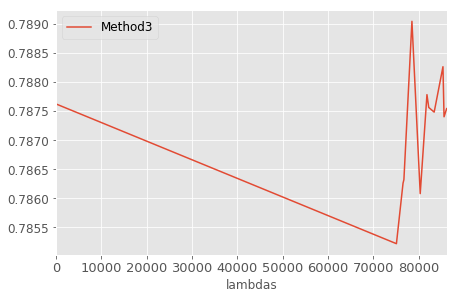

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

mean_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

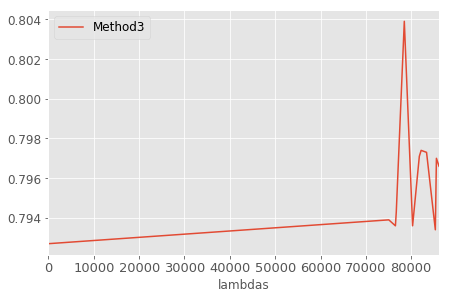

In [20]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

max_acc_grouped_by_lmbda.plot(y='Method3')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.show()

### Init the writer with $\lambda$s (7.5, 8.0)

In [9]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_8lmbdas_ar1_3lyrs_he1_75_80', sess.graph)

### Generate the $\lambda$s

In [10]:
np.random.seed(100)
n_lmbdas = 8
a = np.random.uniform(low=7.5, high=8.0, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 10
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[7.77170247 7.63918469 7.7122588  7.92238807 7.50235943 7.56078456
 7.83537454 7.91292638]
()
[75023.59428095 75607.84560392 76391.84692547 77122.58795375
 77717.02470895 78353.74542363 79129.26377553 79223.8806616 ]
()
([0, 75023.59428095486, 75607.84560391557, 76391.84692546898, 77122.58795374566, 77717.02470895484, 78353.7454236339, 79129.26377552524, 79223.88066159951, 0, 75023.59428095486, 75607.84560391557, 76391.84692546898, 77122.58795374566, 77717.02470895484, 78353.7454236339, 79129.26377552524, 79223.88066159951, 0, 75023.59428095486, 75607.84560391557, 76391.84692546898, 77122.58795374566, 77717.02470895484, 78353.7454236339, 79129.26377552524, 79223.88066159951, 0, 75023.59428095486, 75607.84560391557, 76391.84692546898, 77122.58795374566, 77717.02470895484, 78353.7454236339, 79129.26377552524, 79223.88066159951, 0, 75023.59428095486, 75607.84560391557, 76391.84692546898, 77122.58795374566, 77717.02470895484, 78353.7454236339, 79129.26377552524, 79223.88066159951, 0, 75023

### Generate the random weights

In [11]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(90, 90)


In [12]:
np.array_equal(np_weights[0], np_weights[8])

True

In [13]:
np.array_equal(np_weights[0], np_weights[9])

False

### Commence the training

In [14]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0424780659378 and training accuracy:0.99514144659
validation cost:0.0425861291587 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0238319151103 and training accuracy:0.995575249195
validation cost:0.0244052931666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0170864723623 and training accuracy:0.996703088284
validation cost:0.0173231437802 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0137033909559 and training accuracy:0.997136890888
validation cost:0.0140941208228 and validation accuracy:0.9

Training on :(8, 9)
training cost:0.0535054244101 and training accuracy:0.985285878181
validation cost:0.0488348640501 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0479301735759 and training accuracy:0.986775934696
validation cost:0.0455383919179 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0442771986127 and training accuracy:0.987520933151
validation cost:0.0432717837393 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0408748500049 and training accuracy:0.988359093666
validation cost:0.0389142967761 and validation accuracy:0.993408679962
Training on :(8, 9)
Time taken:119.87639308
Method 3 test accuracy:0.78979998827
Training with lmbda:75023.594281, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 a

Training on :(8, 9)
training cost:0.153863146901 and training accuracy:0.964332282543
validation cost:0.149105384946 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103828720748 and training accuracy:0.972154974937
validation cost:0.100453525782 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0825904533267 and training accuracy:0.975507557392
validation cost:0.0805253982544 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0690082907677 and training accuracy:0.979791402817
validation cost:0.0640916079283 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.060409065336 and training accuracy:0.983330249786
validation cost:0.0557250007987 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0540052577853 and training accuracy:0.985006511211
validation cost:0.0500498972833 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0484573952854 and train

Training on :(6, 7)
training cost:0.0101303961128 and training accuracy:0.998917639256
validation cost:0.010389666073 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00905414484441 and training accuracy:0.999098062515
validation cost:0.0089842248708 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.345440865
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.153782337904 and training accuracy:0.964425384998
validation cost:0.149212926626 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.103845745325 and training accuracy:0.972061812878
validation cost:0.100566983223 and validation accuracy:0.978342

Training on :(6, 7)
training cost:0.0241984166205 and training accuracy:0.997925519943
validation cost:0.0248835235834 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.019018093124 and training accuracy:0.998015701771
validation cost:0.0195136684924 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0156345330179 and training accuracy:0.998286306858
validation cost:0.0162832830101 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0131851173937 and training accuracy:0.9987372756
validation cost:0.0132158165798 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113929007202 and training accuracy:0.998647093773
validation cost:0.0116551136598 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0101149696857 and training accuracy:0.998917639256
validation cost:0.0104413600639 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00906184036285 and 

Training on :(4, 5)
Time taken:115.013352156
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.063928887248 and training accuracy:0.991250991821
validation cost:0.0632255151868 and validation accuracy:0.98813867569
Training on :(6, 7)
training cost:0.0342955477536 and training accuracy:0.997203946114
validation cost:0.0343823172152 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0242062602192 and training accuracy:0.997925519943
validation cost:0.0248517878354 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0190460961312 and training accuracy:0.998015701771
validation cost:0.0194845162332 and validation accuracy:0.9954

Training on :(4, 5)
training cost:0.0238611456007 and training accuracy:0.997756123543
validation cost:0.0179797485471 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0201727617532 and training accuracy:0.998341441154
validation cost:0.0149694085121 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0172444302589 and training accuracy:0.998341441154
validation cost:0.0126476204023 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0156895313412 and training accuracy:0.998048782349
validation cost:0.0114747704938 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0141909923404 and training accuracy:0.998146355152
validation cost:0.0103662954643 and validation accuracy:1.0
Training on :(4, 5)
Time taken:116.229176044
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0987939834595 and training accuracy:0.991609752178
validation cost:0.0914735347033 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0542634949088 and training accuracy:0.992780506611
validation cost:0.0481754951179 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0379437096417 and training accuracy:0.994634151459
validation cost:0.0298737119883 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0292595252395 and training accuracy:0.99658536911
validation cost:0.0225742459297 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0239700693637 and training accuracy:0.997658550739
validation cost:0.0179638359696 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.020175004378 and training accuracy:0.998341441154
validation cost:0.0149575425312 and v

Training on :(2, 3)
training cost:0.0510628521442 and training accuracy:0.982910633087
validation cost:0.0509017147124 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465291365981 and training accuracy:0.985546767712
validation cost:0.0468715317547 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.042725622654 and training accuracy:0.987182974815
validation cost:0.0416037142277 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:123.230154991
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0990330949426 and training accuracy:0.991512179375
validation cost:0.0918543115258 and validation accuracy:0.997038483

Training on :(2, 3)
training cost:0.113498657942 and training accuracy:0.968457400799
validation cost:0.120995566249 and validation accuracy:0.962316155434
Training on :(2, 3)
training cost:0.0886840373278 and training accuracy:0.973184227943
validation cost:0.0928283855319 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0736513435841 and training accuracy:0.974275052547
validation cost:0.078541085124 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0645827651024 and training accuracy:0.977547466755
validation cost:0.0673339515924 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0565020143986 and training accuracy:0.980729043484
validation cost:0.0584243312478 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0510628521442 and training accuracy:0.982910633087
validation cost:0.0509017147124 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0465291365981 and training

Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:130.07968092
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.172586724162 and training accuracy:0.948186516762
validation cost:0.175913929939 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.116030067205 and training accuracy:0.96891194582
validation cost:0.119507059455 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0902791470289 and training accuracy:0.974820494652
validation cost:0.0988100841641 and validation accuracy:0.9705882

Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.998785376549
validation cost:0.0107228029519 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00787314772606 and training accuracy:0.998872101307
validation cost:0.00863403454423 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717198569328 and training accuracy:0.998785376549
validation cost:0.00791050959378 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00652148155496 and training accuracy:0.99895888567
validation cost:0.00675761792809 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:128.871923923
C

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 and training accuracy:0.99514144659
validation cost:0.0417454019189 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0227200146765 and training accuracy:0.994967877865
validation cost:0.0239276178181 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167468301952 and training accuracy:0.995922267437
validation cost:0.0184297058731 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0128897661343 and training accuracy:0.997136890888
validation cost:0.0145706953481 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0106140980497 and training accuracy:0.998264789581
validation cost:0.0119876815006 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00909558497369 and training accuracy:0.99

Training on :(8, 9)
training cost:0.0494897812605 and training accuracy:0.985937774181
validation cost:0.047233235091 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0448364168406 and training accuracy:0.987148463726
validation cost:0.0450449250638 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0410364829004 and training accuracy:0.988172829151
validation cost:0.0415655300021 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:120.999289036
Method 3 test accuracy:0.793699979782
Training with lmbda:76391.8469255, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407013818622 

Training on :(8, 9)
training cost:0.105306468904 and training accuracy:0.968802392483
validation cost:0.101682595909 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.084554001689 and training accuracy:0.974296867847
validation cost:0.0820734128356 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.070912078023 and training accuracy:0.979232609272
validation cost:0.0701220482588 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0616190731525 and training accuracy:0.982398927212
validation cost:0.0591986179352 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0553631223738 and training accuracy:0.984820246696
validation cost:0.0527417995036 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0493916273117 and training accuracy:0.986030936241
validation cost:0.0474139451981 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0452949404716 and trai

training cost:0.00999848078936 and training accuracy:0.999007821083
validation cost:0.0101455207914 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00917185470462 and training accuracy:0.99927842617
validation cost:0.00914405938238 and validation accuracy:1.0
Training on :(6, 7)
Time taken:125.172970057
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.154586404562 and training accuracy:0.963307857513
validation cost:0.153138130903 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.105208046734 and training accuracy:0.968988656998
validation cost:0.101524196565 and validation accuracy:0.976459503174
Training on :(8, 9)
tr

Training on :(6, 7)
training cost:0.024082891643 and training accuracy:0.998286306858
validation cost:0.024649117142 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0186567530036 and training accuracy:0.998556852341
validation cost:0.0191971696913 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.015124918893 and training accuracy:0.998647093773
validation cost:0.0152751561254 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0130238337442 and training accuracy:0.998827457428
validation cost:0.0133261485025 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0113095585257 and training accuracy:0.999007821083
validation cost:0.0111769866198 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0100216530263 and training accuracy:0.999007821083
validation cost:0.0101179685444 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00920183118433 and traini

training cost:0.0154773751274 and training accuracy:0.997560977936
validation cost:0.00977031514049 and validation accuracy:1.0
Training on :(4, 5)
Time taken:114.336830139
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619726330042 and training accuracy:0.992784321308
validation cost:0.0630603432655 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.034209035337 and training accuracy:0.997654914856
validation cost:0.034595258534 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0241276286542 and training accuracy:0.998196065426
validation cost:0.0246685482562 and validation accuracy:0.9981752038
Training on :(6, 7)
tra

Training on :(4, 5)
training cost:0.0311386547983 and training accuracy:0.996097564697
validation cost:0.0239967014641 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254896841943 and training accuracy:0.996292710304
validation cost:0.0195543486625 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212495885789 and training accuracy:0.997073173523
validation cost:0.0152355134487 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0186778139323 and training accuracy:0.99726831913
validation cost:0.01290289592 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0167655143887 and training accuracy:0.997463405132
validation cost:0.0112148756161 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154351182282 and training accuracy:0.997560977936
validation cost:0.00977554544806 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.542845964
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test fea

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0999555289745 and training accuracy:0.991804897785
validation cost:0.0895265564322 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0546903274953 and training accuracy:0.993073165417
validation cost:0.0473115630448 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0395756475627 and training accuracy:0.994926810265
validation cost:0.0323258601129 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0312104076147 and training accuracy:0.996097564697
validation cost:0.0239969734102 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0254873409867 and training accuracy:0.996292710304
validation cost:0.0195543076843 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0212740749121 and training accuracy:0.997073173523
validation 

Training on :(2, 3)
training cost:0.0493555441499 and training accuracy:0.984092354774
validation cost:0.0478820502758 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0461981035769 and training accuracy:0.984728634357
validation cost:0.0463549382985 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0426699481905 and training accuracy:0.986819386482
validation cost:0.0424819812179 and validation accuracy:0.986213207245
Training on :(2, 3)
Time taken:123.387937069
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0964237600565 and training accuracy:0.993365824223
validation cost:0.0909076109529 and validation accuracy:0.99

Training on :(2, 3)
training cost:0.107103474438 and training accuracy:0.97127532959
validation cost:0.106736317277 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833898261189 and training accuracy:0.975184082985
validation cost:0.0829503983259 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0703212246299 and training accuracy:0.977456569672
validation cost:0.0716136917472 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0620242469013 and training accuracy:0.979001879692
validation cost:0.0636194199324 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0546811968088 and training accuracy:0.981819808483
validation cost:0.0558036379516 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0496190860868 and training accuracy:0.983819663525
validation cost:0.0487594902515 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0461081415415 and t

Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:130.559753895
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.160725980997 and training accuracy:0.955004096031
validation cost:0.161874428391 and validation accuracy:0.955882370472
Training on :(2, 3)
training cost:0.107103474438 and training accuracy:0.97127532959
validation cost:0.106736317277 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0833898261189 and training accuracy:0.975184082985
validation cost:0.0829503983259 and validation accuracy:0.972426

Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.997917771339
validation cost:0.013716164045 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00871878024191 and training accuracy:0.998004496098
validation cost:0.0113938776776 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00791663490236 and training accuracy:0.99809128046
validation cost:0.0103809628636 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00715233804658 and training accuracy:0.998178005219
validation cost:0.0096391858533 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:128.925536156
Curren

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accuracy:0.995748758316
validation cost:0.0434302538633 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0229833126068 and training accuracy:0.995661973953
validation cost:0.0272879451513 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0166700072587 and training accuracy:0.996616363525
validation cost:0.0188895296305 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0133215785027 and training accuracy:0.997483968735
validation cost:0.015726827085 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0113944578916 and training accuracy:0.997744202614
validation cost:0.0146624203771 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00990882981569 and training accuracy:0.99

training cost:0.0489745810628 and training accuracy:0.985472142696
validation cost:0.0473107658327 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0448881685734 and training accuracy:0.987520933151
validation cost:0.0429089106619 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0416954681277 and training accuracy:0.987986564636
validation cost:0.0401843674481 and validation accuracy:0.991525411606
Training on :(8, 9)
Time taken:120.137614965
Method 3 test accuracy:0.787599980831
Training with lmbda:77717.024709, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0411857999861 and training accurac

Training on :(8, 9)
training cost:0.103214487433 and training accuracy:0.972341239452
validation cost:0.102813564241 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0837421193719 and training accuracy:0.975786924362
validation cost:0.0858268067241 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0699641257524 and training accuracy:0.978580713272
validation cost:0.0691701024771 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0608499236405 and training accuracy:0.982212722301
validation cost:0.0588545650244 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0539107583463 and training accuracy:0.984075248241
validation cost:0.0526242814958 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0486321635544 and training accuracy:0.985751509666
validation cost:0.0476928018034 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0449383072555 and 

Training on :(6, 7)
training cost:0.00888948421925 and training accuracy:0.999098062515
validation cost:0.00882417336106 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.071964025
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150414183736 and training accuracy:0.963959753513
validation cost:0.147212699056 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.103139646351 and training accuracy:0.972061812878
validation cost:0.103072866797 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0840896740556 and training accuracy:0.975693821907
validation cost:0.086076118052 and validation accuracy:0.977401

Training on :(6, 7)
training cost:0.0183690749109 and training accuracy:0.998376488686
validation cost:0.0188713800162 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.01492446661 and training accuracy:0.998376488686
validation cost:0.0143996458501 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128665100783 and training accuracy:0.998466670513
validation cost:0.0133003331721 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0112696895376 and training accuracy:0.998827457428
validation cost:0.0116011658683 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.00987057946622 and training accuracy:0.999007821083
validation cost:0.0100846011192 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00887627992779 and training accuracy:0.999098062515
validation cost:0.00889185350388 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:127.308746099
Curren

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619806982577 and training accuracy:0.991882383823
validation cost:0.0612914636731 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0337211079895 and training accuracy:0.997023522854
validation cost:0.034920591861 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0234888494015 and training accuracy:0.998196065426
validation cost:0.0244716256857 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0183805506676 and training accuracy:0.998376488686
validation cost:0.0188752468675 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149328177795 and training accuracy:0.998376488686
validation cost:0.014500329271 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0128655442968 and training accuracy:0.998466670513
validation co

Training on :(4, 5)
training cost:0.0189753454179 and training accuracy:0.99726831913
validation cost:0.0134453475475 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0169585160911 and training accuracy:0.997365832329
validation cost:0.0123243164271 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0152014484629 and training accuracy:0.997463405132
validation cost:0.0111647546291 and validation accuracy:0.998025655746
Training on :(4, 5)
Time taken:118.973143816
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0680197104812 and training accuracy:0.990258872509
validation cost:0.0667800009251 and validation accuracy:0.988

Training on :(4, 5)
training cost:0.0532292537391 and training accuracy:0.993073165417
validation cost:0.0455369651318 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0375275835395 and training accuracy:0.994926810265
validation cost:0.0300303995609 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0295784771442 and training accuracy:0.996878027916
validation cost:0.0223454013467 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0248046033084 and training accuracy:0.996975600719
validation cost:0.0182399842888 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0215685572475 and training accuracy:0.99726831913
validation cost:0.015365649946 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0190953724086 and training accuracy:0.997463405132
validation cost:0.0135134197772 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0170959029347 and training accuracy:0.997463405132
v

training cost:0.0454834066331 and training accuracy:0.985728561878
validation cost:0.048866122961 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0415317825973 and training accuracy:0.987092077732
validation cost:0.0455753691494 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:129.981878042
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0955038666725 and training accuracy:0.991999983788
validation cost:0.0894460305572 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.053146623075 and training accuracy:0.992975592613
validation cost:0.0452231839299 and validation accuracy:0.99703848362
Training on 

Training on :(2, 3)
training cost:0.0837389752269 and training accuracy:0.976274907589
validation cost:0.0887669399381 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0695856958628 and training accuracy:0.977820217609
validation cost:0.0768106579781 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0613700710237 and training accuracy:0.97963821888
validation cost:0.0684042423964 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0537707470357 and training accuracy:0.982456147671
validation cost:0.0579846762121 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0492949187756 and training accuracy:0.984365046024
validation cost:0.0528883896768 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0454618521035 and training accuracy:0.985728561878
validation cost:0.0496764555573 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0416134335101 and

Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:129.382716894
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162090584636 and training accuracy:0.953822374344
validation cost:0.167213529348 and validation accuracy:0.948529422283
Training on :(2, 3)
training cost:0.108149036765 and training accuracy:0.971457123756
validation cost:0.109645545483 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0837389752269 and training accuracy:0.976274907589
validation cost:0.0887669399381 and validation accuracy:0.970588207245

Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998178005219
validation cost:0.0100549636409 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00832241028547 and training accuracy:0.998178005219
validation cost:0.00934102013707 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00762184849009 and training accuracy:0.99809128046
validation cost:0.0085003040731 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0068105510436 and training accuracy:0.998351573944
validation cost:0.00740517955273 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:129.813542128
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062 and training accuracy:0.995228171349
validation cost:0.0439142361283 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.02334279567 and training accuracy:0.995054662228
validation cost:0.0243503469974 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0170680135489 and training accuracy:0.996616363525
validation cost:0.0185922384262 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0130954766646 and training accuracy:0.998004496098
validation cost:0.0150229362771 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108403526247 and training accuracy:0.998178005219
validation cost:0.0120927793905 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00930841360241 and training accuracy:0.998

Training on :(8, 9)
training cost:0.0515720583498 and training accuracy:0.985751509666
validation cost:0.0499296151102 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0470767132938 and training accuracy:0.986403405666
validation cost:0.0447058044374 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0432345978916 and training accuracy:0.987427830696
validation cost:0.0403593853116 and validation accuracy:0.992467045784
Training on :(8, 9)
Time taken:120.946440935
Method 3 test accuracy:0.791800022125
Training with lmbda:79129.2637755, 34
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0415110439062

Training on :(8, 9)
training cost:0.104262188077 and training accuracy:0.971968710423
validation cost:0.106943950057 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0846841037273 and training accuracy:0.974390029907
validation cost:0.0855098664761 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0725935250521 and training accuracy:0.978860139847
validation cost:0.073125898838 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0631418973207 and training accuracy:0.982119560242
validation cost:0.0637995377183 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0564954206347 and training accuracy:0.984261512756
validation cost:0.054974976927 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0518155619502 and training accuracy:0.985472142696
validation cost:0.0500001646578 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0469408221543 and tr

training cost:0.0104048186913 and training accuracy:0.9987372756
validation cost:0.0108200861141 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00946821179241 and training accuracy:0.9987372756
validation cost:0.00983900297433 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:125.371418953
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.150692611933 and training accuracy:0.963494122028
validation cost:0.154095500708 and validation accuracy:0.956685483456
Training on :(8, 9)
training cost:0.104307457805 and training accuracy:0.971875607967
validation cost:0.107363007963 and validation accuracy:0.971751391888
Training on :(8

training cost:0.0245375912637 and training accuracy:0.997474491596
validation cost:0.0253121834248 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0194009188563 and training accuracy:0.997474491596
validation cost:0.0205389261246 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.015670472756 and training accuracy:0.997745096684
validation cost:0.0162374582142 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0135167920962 and training accuracy:0.997925519943
validation cost:0.0137619227171 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0116283893585 and training accuracy:0.998376488686
validation cost:0.0124588711187 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0104563068599 and training accuracy:0.998466670513
validation cost:0.0107550639659 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.00935703516006 and training accuracy:

Training on :(4, 5)
Time taken:115.866501093
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0627797544003 and training accuracy:0.990890204906
validation cost:0.0633541718125 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0346198827028 and training accuracy:0.996752977371
validation cost:0.034181304276 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0247641596943 and training accuracy:0.997654914856
validation cost:0.0257355067879 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0195860862732 and training accuracy:0.997474491596
validation cost:0.0207955241203 and validation accuracy:0.995

Training on :(4, 5)
training cost:0.0242176875472 and training accuracy:0.997073173523
validation cost:0.018144859001 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209748689085 and training accuracy:0.997170746326
validation cost:0.0142698949203 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184211544693 and training accuracy:0.997463405132
validation cost:0.0123071307316 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0165302380919 and training accuracy:0.997365832329
validation cost:0.0106150219217 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0151310199872 and training accuracy:0.99726831913
validation cost:0.00939136557281 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.403638124
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943855047226 and training accuracy:0.993463397026
validation cost:0.0837088227272 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0534698218107 and training accuracy:0.993073165417
validation cost:0.0436429567635 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0377292111516 and training accuracy:0.994829297066
validation cost:0.0290817711502 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0291190519929 and training accuracy:0.996390223503
validation cost:0.022504158318 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0242601875216 and training accuracy:0.997073173523
validation cost:0.018112488091 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0209080483764 and training accuracy:0.997170746326
validation cost:0.0142001938075 and validation

Training on :(2, 3)
training cost:0.0522672049701 and training accuracy:0.984092354774
validation cost:0.0546678341925 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0477082654834 and training accuracy:0.985637664795
validation cost:0.0514009073377 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.044413074851 and training accuracy:0.986546695232
validation cost:0.0476811230183 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:123.986674786
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0943291038275 and training accuracy:0.993463397026
validation cost:0.0833697170019 and validation accuracy:0.998025655

Training on :(2, 3)
training cost:0.115142844617 and training accuracy:0.968366503716
validation cost:0.119561992586 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913783088326 and training accuracy:0.971729815006
validation cost:0.0965802669525 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.076224423945 and training accuracy:0.974911391735
validation cost:0.0821544378996 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0649959370494 and training accuracy:0.97909283638
validation cost:0.0661821067333 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0579085536301 and training accuracy:0.981819808483
validation cost:0.0607856586576 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0522640347481 and training accuracy:0.984092354774
validation cost:0.0546673089266 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.047644816339 and training a

Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.629025221
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.171822085977 and training accuracy:0.947277545929
validation cost:0.173728704453 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.115122787654 and training accuracy:0.968366503716
validation cost:0.119388438761 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0913701802492 and training accuracy:0.971729815006
validation cost:0.0965802669525 and validation accuracy:0.9687

Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.99809128046
validation cost:0.0109322778881 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00838874466717 and training accuracy:0.998264789581
validation cost:0.0101041002199 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00755478534847 and training accuracy:0.99809128046
validation cost:0.00917085818946 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00698435213417 and training accuracy:0.998004496098
validation cost:0.00852664839476 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.169789076
Cur

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0406066067517 and training accuracy:0.995314955711
validation cost:0.0420646257699 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0230203382671 and training accuracy:0.995228171349
validation cost:0.0234451759607 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0167031474411 and training accuracy:0.996703088284
validation cost:0.0187955778092 and validation accuracy:0.994732201099
Training on :(0, 1)
training cost:0.0130601068959 and training accuracy:0.997657477856
validation cost:0.0140707390383 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0111347502097 and training accuracy:0.998004496098
validation cost:0.0117450542748 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00962120573968 and training accuracy:0.9

training cost:0.0491912737489 and training accuracy:0.985937774181
validation cost:0.0467564798892 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0452096201479 and training accuracy:0.987427830696
validation cost:0.0437678173184 and validation accuracy:0.991525411606
Training on :(8, 9)
training cost:0.0421025641263 and training accuracy:0.987986564636
validation cost:0.0419373698533 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:120.785123825
Method 3 test accuracy:0.778500020504
Training with lmbda:0, 45
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0408932901919 and training accuracy:0.9949678

training cost:0.104438573122 and training accuracy:0.971689343452
validation cost:0.107217401266 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0841329023242 and training accuracy:0.974762499332
validation cost:0.0856364071369 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0711039453745 and training accuracy:0.978673875332
validation cost:0.0720140635967 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0625501349568 and training accuracy:0.982119560242
validation cost:0.0652162358165 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0554003119469 and training accuracy:0.984075248241
validation cost:0.056522525847 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0501193888485 and training accuracy:0.985472142696
validation cost:0.0501580946147 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0458750203252 and training accuracy:0.98

Training on :(6, 7)
training cost:0.00889163650572 and training accuracy:0.999368607998
validation cost:0.00937375240028 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:125.138669014
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.152765601873 and training accuracy:0.961445331573
validation cost:0.151919424534 and validation accuracy:0.961393594742
Training on :(8, 9)
training cost:0.104269370437 and training accuracy:0.971968710423
validation cost:0.105960458517 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.084406144917 and training accuracy:0.974483132362
validation cost:0.0848532542586 and validation accuracy:0.9764595

Training on :(6, 7)
training cost:0.018309250474 and training accuracy:0.998376488686
validation cost:0.0185105986893 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149502232671 and training accuracy:0.998556852341
validation cost:0.0138177033514 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0125601980835 and training accuracy:0.998917639256
validation cost:0.0128131248057 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0109293479472 and training accuracy:0.999188244343
validation cost:0.0115823894739 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00977211073041 and training accuracy:0.99927842617
validation cost:0.010277306661 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.00888333469629 and training accuracy:0.999368607998
validation cost:0.00938408635557 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:125.16215682
Current mask:[1. 1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.062484562397 and training accuracy:0.993325531483
validation cost:0.062522739172 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0335087180138 and training accuracy:0.997654914856
validation cost:0.0325716249645 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0234669186175 and training accuracy:0.998105883598
validation cost:0.0237253438681 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0182792562991 and training accuracy:0.998376488686
validation cost:0.0186494104564 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0149518540129 and training accuracy:0.998556852341
validation cost:0.0137962307781 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0125058330595 and training accuracy:0.998917639256
validation cost:0.0

Training on :(4, 5)
training cost:0.0185132492334 and training accuracy:0.997658550739
validation cost:0.0139225274324 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164825860411 and training accuracy:0.997853636742
validation cost:0.0119581166655 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0151213984936 and training accuracy:0.997658550739
validation cost:0.0103329261765 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.814323902
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0625128522515 and training accuracy:0.993325531483
validation cost:0.0625018253922 and validation accuracy:0.992700755596
Training on :(6, 7)
tr

Training on :(4, 5)
training cost:0.0546130314469 and training accuracy:0.991999983788
validation cost:0.0490599572659 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0381735377014 and training accuracy:0.995317101479
validation cost:0.0325291082263 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.029751483351 and training accuracy:0.996780514717
validation cost:0.0240355338901 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244718659669 and training accuracy:0.997073173523
validation cost:0.0200312621891 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0207849144936 and training accuracy:0.997463405132
validation cost:0.0166166406125 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0184409115463 and training accuracy:0.997560977936
validation cost:0.0139492908493 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0164812095463 and training accuracy:0.997853636742
validation

Training on :(2, 3)
training cost:0.0416594259441 and training accuracy:0.987364768982
validation cost:0.0466406047344 and validation accuracy:0.982536792755
Training on :(2, 3)
Time taken:123.413382053
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0987436547875 and training accuracy:0.992975592613
validation cost:0.0933547243476 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0546491593122 and training accuracy:0.991999983788
validation cost:0.0490581840277 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0382070541382 and training accuracy:0.995414614677
validation cost:0.0325574539602 and validation accuracy:0.99

Training on :(2, 3)
training cost:0.0710770711303 and training accuracy:0.976911187172
validation cost:0.078664906323 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0619848333299 and training accuracy:0.978547394276
validation cost:0.0670605972409 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0545359700918 and training accuracy:0.982092559338
validation cost:0.0588262788951 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0501020476222 and training accuracy:0.984001457691
validation cost:0.0549685098231 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0453428067267 and training accuracy:0.985637664795
validation cost:0.0487595126033 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0416430719197 and training accuracy:0.987273871899
validation cost:0.0466440990567 and validation accuracy:0.982536792755
Training on :(2, 3)
Time taken:123.441096067
Current 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.163036689162 and training accuracy:0.95218616724
validation cost:0.169579863548 and validation accuracy:0.949448525906
Training on :(2, 3)
training cost:0.108636200428 and training accuracy:0.970548152924
validation cost:0.115349672735 and validation accuracy:0.964154422283
Training on :(2, 3)
training cost:0.0854979455471 and training accuracy:0.975093185902
validation cost:0.0936356261373 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0710770711303 and training accuracy:0.976911187172
validation cost:0.078664906323 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0619848333299 and training accuracy:0.978547394276
validation cost:0.0670605972409 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0545359700918 and training accuracy:0.982092559338
validation cost:0

Training on :(0, 1)
training cost:0.00799342896789 and training accuracy:0.998178005219
validation cost:0.00972363725305 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717001454905 and training accuracy:0.998351573944
validation cost:0.0093073612079 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00655751815066 and training accuracy:0.998525083065
validation cost:0.0095241740346 and validation accuracy:0.996488153934
Training on :(0, 1)
Time taken:130.079544067
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.158793136477 and training accuracy:0.954640507698
validation cost:0.152116447687 and validation accuracy:0.

Training on :(0, 1)
training cost:0.0228296592832 and training accuracy:0.9960090518
validation cost:0.026343761012 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0164887011051 and training accuracy:0.997310400009
validation cost:0.0201635546982 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0127225639299 and training accuracy:0.997657477856
validation cost:0.0153160961345 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0108411358669 and training accuracy:0.997744202614
validation cost:0.013214587234 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00940183270723 and training accuracy:0.99809128046
validation cost:0.0114787714556 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00799342896789 and training accuracy:0.998178005219
validation cost:0.00972363725305 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00717001454905 and

Training on :(8, 9)
training cost:0.040870718658 and training accuracy:0.988359093666
validation cost:0.0397210344672 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:120.754145861
Method 3 test accuracy:0.797699987888
Training with lmbda:75607.8456039, 56
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.042028285563 and training accuracy:0.994447350502
validation cost:0.0454526618123 and validation accuracy:0.992098331451
Training on :(0, 1)
training cost:0.0228296592832 and training accuracy:0.9960090518
validation cost:0.026343761012 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0164887011051 and 

Training on :(8, 9)
training cost:0.0682666227221 and training accuracy:0.980350136757
validation cost:0.0684225857258 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0600426830351 and training accuracy:0.983050823212
validation cost:0.0583440810442 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0536974817514 and training accuracy:0.986124038696
validation cost:0.0520277917385 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0483236722648 and training accuracy:0.987427830696
validation cost:0.0479187890887 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.04433664307 and training accuracy:0.987893462181
validation cost:0.0424776114523 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0408981889486 and training accuracy:0.988079726696
validation cost:0.0392965376377 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:121.235505819
Method 3 t

Training on :(6, 7)
Time taken:125.316753864
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.147861048579 and training accuracy:0.965170443058
validation cost:0.147136643529 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.101261474192 and training accuracy:0.972434341908
validation cost:0.100613243878 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0811234340072 and training accuracy:0.976438820362
validation cost:0.0826897323132 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0681576505303 and training accuracy:0.980536401272
validation cost:0.068311855197 and validation accuracy:0.98305082

Training on :(6, 7)
training cost:0.0154286958277 and training accuracy:0.998015701771
validation cost:0.0144251203164 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0132093178108 and training accuracy:0.998105883598
validation cost:0.0129484944046 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.011722445488 and training accuracy:0.998556852341
validation cost:0.0109262885526 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0104108527303 and training accuracy:0.999007821083
validation cost:0.00949387811124 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00934556964785 and training accuracy:0.998917639256
validation cost:0.00913931149989 and validation accuracy:0.9981752038
Training on :(6, 7)
Time taken:124.656466007
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0628117620945 and training accuracy:0.991250991821
validation cost:0.0582167878747 and validation accuracy:0.993613123894
Training on :(6, 7)
training cost:0.0345702320337 and training accuracy:0.996211767197
validation cost:0.0342457592487 and validation accuracy:0.994525551796
Training on :(6, 7)
training cost:0.0241153407842 and training accuracy:0.997654914856
validation cost:0.022974666208 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0188601799309 and training accuracy:0.998105883598
validation cost:0.0184150952846 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.015379788354 and training accuracy:0.998015701771
validation cost:0.0143878329545 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0131100537255 and training accuracy:0.998196065426
validation co

training cost:0.0207906886935 and training accuracy:0.997073173523
validation cost:0.0168895833194 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0183690004051 and training accuracy:0.997365832329
validation cost:0.0153544973582 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.016156906262 and training accuracy:0.997658550739
validation cost:0.0129300057888 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0146620143205 and training accuracy:0.997756123543
validation cost:0.0113946106285 and validation accuracy:0.999012827873
Training on :(4, 5)
Time taken:115.715757847
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training o

Training on :(4, 5)
training cost:0.0970439687371 and training accuracy:0.994341492653
validation cost:0.0900417342782 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0535752736032 and training accuracy:0.993365824223
validation cost:0.0473601035774 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0371597744524 and training accuracy:0.995609760284
validation cost:0.0321188494563 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0284858103842 and training accuracy:0.997073173523
validation cost:0.0243178922683 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0242149718106 and training accuracy:0.997073173523
validation cost:0.0204741340131 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0208037085831 and training accuracy:0.997073173523
validation cost:0.0169520471245 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0184151008725 and

Training on :(2, 3)
training cost:0.0489343814552 and training accuracy:0.984001457691
validation cost:0.0474993549287 and validation accuracy:0.985294103622
Training on :(2, 3)
training cost:0.044728603214 and training accuracy:0.985728561878
validation cost:0.0411694571376 and validation accuracy:0.987132370472
Training on :(2, 3)
training cost:0.041006103158 and training accuracy:0.98772841692
validation cost:0.0383169986308 and validation accuracy:0.988970577717
Training on :(2, 3)
Time taken:124.151319981
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.0970406457782 and training accuracy:0.994439005852
validation cost:0.0900417342782 and validation accuracy:0.99802

Training on :(2, 3)
training cost:0.11726603657 and training accuracy:0.965912163258
validation cost:0.125178739429 and validation accuracy:0.959558844566
Training on :(2, 3)
training cost:0.0920018032193 and training accuracy:0.970184504986
validation cost:0.10225751996 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0774553790689 and training accuracy:0.97309333086
validation cost:0.0833535268903 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0671276301146 and training accuracy:0.976820290089
validation cost:0.0732020884752 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0592546239495 and training accuracy:0.9811835289
validation cost:0.0660737380385 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0533913522959 and training accuracy:0.982819736004
validation cost:0.0598394237459 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0480981990695 and traini

Training on :(0, 1)
training cost:0.00768285011873 and training accuracy:0.998698592186
validation cost:0.010228285566 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0069249314256 and training accuracy:0.998698592186
validation cost:0.00924274604768 and validation accuracy:0.996488153934
Training on :(0, 1)
Time taken:129.408162832
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.176114559174 and training accuracy:0.946732103825
validation cost:0.173969447613 and validation accuracy:0.947610318661
Training on :(2, 3)
training cost:0.117364965379 and training accuracy:0.965821266174
validation cost:0.125218451023 and validation accuracy:0.95955

Training on :(0, 1)
training cost:0.017212593928 and training accuracy:0.996963381767
validation cost:0.0189839210361 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0133970715106 and training accuracy:0.997744202614
validation cost:0.0143423136324 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0113293807954 and training accuracy:0.997917771339
validation cost:0.0121944788843 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00978762749583 and training accuracy:0.998264789581
validation cost:0.0111975381151 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00863062124699 and training accuracy:0.998525083065
validation cost:0.0105813043192 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00768285011873 and training accuracy:0.998698592186
validation cost:0.010228285566 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0069249314256 a

Training on :(8, 9)
Time taken:121.11336422
Method 3 test accuracy:0.796599984169
Training with lmbda:76391.8469255, 66
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0429915376008 and training accuracy:0.994273841381
validation cost:0.0438964217901 and validation accuracy:0.993854284286
Training on :(0, 1)
training cost:0.0238178223372 and training accuracy:0.994967877865
validation cost:0.0259671844542 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.017212593928 and training accuracy:0.996963381767
validation cost:0.0189839210361 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0133970715106 a

Training on :(8, 9)
training cost:0.062078744173 and training accuracy:0.981933295727
validation cost:0.0605697631836 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0554478876293 and training accuracy:0.983609616756
validation cost:0.053530510515 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0505670644343 and training accuracy:0.986030936241
validation cost:0.0502817705274 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.046641856432 and training accuracy:0.987241566181
validation cost:0.0468453541398 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0434873662889 and training accuracy:0.987893462181
validation cost:0.0430686660111 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:121.219137192
Method 3 test accuracy:0.801599979401
Training with lmbda:77122.5879537, 67
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test label

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.155493229628 and training accuracy:0.957906484604
validation cost:0.154551371932 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.106174364686 and training accuracy:0.968523025513
validation cost:0.104625545442 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.0851683020592 and training accuracy:0.973551869392
validation cost:0.0891708210111 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0713528469205 and training accuracy:0.979046404362
validation cost:0.0710361152887 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0622585862875 and training accuracy:0.981747090816
validation cost:0.0606045126915 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0555641502142 and training accuracy:0.983888983727
validation cost:

Training on :(6, 7)
training cost:0.011577877216 and training accuracy:0.998286306858
validation cost:0.0118617992848 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0103064989671 and training accuracy:0.998556852341
validation cost:0.0103096133098 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.00909309182316 and training accuracy:0.999188244343
validation cost:0.00965052563697 and validation accuracy:0.997262775898
Training on :(6, 7)
Time taken:124.802186966
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.155404984951 and training accuracy:0.958092749119
validation cost:0.154581531882 and validation accuracy:0.957

Training on :(6, 7)
training cost:0.0341899469495 and training accuracy:0.996752977371
validation cost:0.0321021713316 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0236367024481 and training accuracy:0.997745096684
validation cost:0.0228921771049 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0187172554433 and training accuracy:0.998196065426
validation cost:0.0186069607735 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0155333494768 and training accuracy:0.998376488686
validation cost:0.0156738404185 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0132005605847 and training accuracy:0.998376488686
validation cost:0.013387077488 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0115828923881 and training accuracy:0.998286306858
validation cost:0.0118330745026 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0103264693171 and

Training on :(4, 5)
training cost:0.0169977527112 and training accuracy:0.997560977936
validation cost:0.0116459149867 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154785737395 and training accuracy:0.997463405132
validation cost:0.00991877168417 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.665791988
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0619086697698 and training accuracy:0.991972565651
validation cost:0.0597919970751 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0341405719519 and training accuracy:0.996752977371
validation cost:0.0321110971272 and validation accuracy:0.996350347996
Training o

Training on :(4, 5)
training cost:0.0383864045143 and training accuracy:0.994243919849
validation cost:0.0307658165693 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0304979812354 and training accuracy:0.995707333088
validation cost:0.0228060819209 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0250732600689 and training accuracy:0.997073173523
validation cost:0.0184769555926 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0218069534749 and training accuracy:0.997365832329
validation cost:0.0158565249294 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0191155076027 and training accuracy:0.997365832329
validation cost:0.0129064908251 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0169965494424 and training accuracy:0.997560977936
validation cost:0.0116479536518 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0154099697247 and training accuracy:0.

training cost:0.0431834869087 and training accuracy:0.98800110817
validation cost:0.0416289642453 and validation accuracy:0.990808844566
Training on :(2, 3)
Time taken:124.868016005
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.104563094676 and training accuracy:0.990243911743
validation cost:0.100277259946 and validation accuracy:0.993089854717
Training on :(4, 5)
training cost:0.0587990656495 and training accuracy:0.990048766136
validation cost:0.0532216355205 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0405653566122 and training accuracy:0.993658542633
validation cost:0.0357160940766 and validation accuracy:0.996051311493
Training on 

Training on :(2, 3)
training cost:0.0741386264563 and training accuracy:0.975184082985
validation cost:0.0775890648365 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0644443705678 and training accuracy:0.979274630547
validation cost:0.066697485745 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.056856110692 and training accuracy:0.982819736004
validation cost:0.0586942732334 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0516641810536 and training accuracy:0.984546840191
validation cost:0.0523584894836 and validation accuracy:0.986213207245
Training on :(2, 3)
training cost:0.0466875508428 and training accuracy:0.987001180649
validation cost:0.0455941148102 and validation accuracy:0.988051474094
Training on :(2, 3)
training cost:0.043511915952 and training accuracy:0.987819314003
validation cost:0.0421242304146 and validation accuracy:0.989889681339
Training on :(2, 3)
Time taken:123.434533119
Current ma

Training on :(0, 1)
Time taken:130.017961979
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.169827252626 and training accuracy:0.948277413845
validation cost:0.172634080052 and validation accuracy:0.945772051811
Training on :(2, 3)
training cost:0.114108942449 and training accuracy:0.968548297882
validation cost:0.113806560636 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0890826880932 and training accuracy:0.972729742527
validation cost:0.0909723341465 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0741426050663 and training accuracy:0.975184082985
validation cost:0.0776000469923 and validation accuracy:0.969669

Training on :(0, 1)
training cost:0.0108051029965 and training accuracy:0.997917771339
validation cost:0.0121108535677 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00912220589817 and training accuracy:0.998178005219
validation cost:0.010731311515 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00803853012621 and training accuracy:0.998438298702
validation cost:0.00947891175747 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00730696227401 and training accuracy:0.998525083065
validation cost:0.00802361033857 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00661231810227 and training accuracy:0.998525083065
validation cost:0.00713462941349 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:129.367037058
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Va

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407082512975 and training accuracy:0.996703088284
validation cost:0.0428825952113 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0219800006598 and training accuracy:0.996356070042
validation cost:0.0233830865473 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.015835378319 and training accuracy:0.997483968735
validation cost:0.016170958057 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0128135094419 and training accuracy:0.998004496098
validation cost:0.0137275373563 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0108051029965 and training accuracy:0.997917771339
validation cost:0.0121108535677 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.00912220589817 and training accuracy:0.998

Training on :(8, 9)
training cost:0.051244430244 and training accuracy:0.985192775726
validation cost:0.049254026264 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.047069106251 and training accuracy:0.986496567726
validation cost:0.0454797074199 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0432059876621 and training accuracy:0.988079726696
validation cost:0.0420280247927 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:121.122915983
Method 3 test accuracy:0.791800022125
Training with lmbda:77717.024709, 77
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0407082512975 and

Training on :(8, 9)
training cost:0.107115507126 and training accuracy:0.970478653908
validation cost:0.110954530537 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0867657065392 and training accuracy:0.974110662937
validation cost:0.0889818295836 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.073053650558 and training accuracy:0.977928876877
validation cost:0.0756867676973 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0640837103128 and training accuracy:0.981560826302
validation cost:0.0651869401336 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0567628704011 and training accuracy:0.984075248241
validation cost:0.0563946738839 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0513262227178 and training accuracy:0.985099673271
validation cost:0.0491201207042 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0468993522227 and t

Training on :(6, 7)
training cost:0.0102426968515 and training accuracy:0.9987372756
validation cost:0.0102902604267 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00917350873351 and training accuracy:0.998827457428
validation cost:0.00910328514874 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:124.653077126
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.157733097672 and training accuracy:0.961072802544
validation cost:0.163187414408 and validation accuracy:0.955743908882
Training on :(8, 9)
training cost:0.107240267098 and training accuracy:0.970106184483
validation cost:0.110883399844 and validation accuracy:0.971751

Training on :(6, 7)
training cost:0.024533489719 and training accuracy:0.997564733028
validation cost:0.023962970823 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0192355718464 and training accuracy:0.997474491596
validation cost:0.0186312012374 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0158509388566 and training accuracy:0.998015701771
validation cost:0.0158652327955 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0134245464578 and training accuracy:0.998376488686
validation cost:0.0130294999108 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0118492487818 and training accuracy:0.998376488686
validation cost:0.01173138991 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0102880131453 and training accuracy:0.9987372756
validation cost:0.0102970236912 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.00918166898191 and training 

Training on :(4, 5)
training cost:0.0156033374369 and training accuracy:0.997463405132
validation cost:0.0126569848508 and validation accuracy:0.999012827873
Training on :(4, 5)
Time taken:116.139281034
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.0635760352015 and training accuracy:0.991521596909
validation cost:0.060855217278 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0353411585093 and training accuracy:0.996301949024
validation cost:0.033324982971 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0245211832225 and training accuracy:0.997564733028
validation cost:0.0238091088831 and validation accuracy:0.9981

Training on :(4, 5)
training cost:0.0301093608141 and training accuracy:0.99658536911
validation cost:0.0237272940576 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0249476637691 and training accuracy:0.996780514717
validation cost:0.0188592411578 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0210041496903 and training accuracy:0.996878027916
validation cost:0.0152725828812 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0182763189077 and training accuracy:0.997170746326
validation cost:0.0134943770245 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.016340624541 and training accuracy:0.99726831913
validation cost:0.0116511369124 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0147697692737 and training accuracy:0.997365832329
validation cost:0.00993669964373 and validation accuracy:1.0
Training on :(4, 5)
Time taken:115.410201073
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Len

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100767768919 and training accuracy:0.991609752178
validation cost:0.0932349562645 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0561472401023 and training accuracy:0.99317073822
validation cost:0.0492867231369 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0387895554304 and training accuracy:0.995609760284
validation cost:0.0317798778415 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0303756035864 and training accuracy:0.99658536911
validation cost:0.0243178643286 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0252022668719 and training accuracy:0.996780514717
validation cost:0.0190258640796 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0214185081422 and training accuracy:0.996878027916
validation cost:0.01573661156 and validation ac

Training on :(2, 3)
training cost:0.0492065213621 and training accuracy:0.985728561878
validation cost:0.0535502620041 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.045253008604 and training accuracy:0.986364901066
validation cost:0.0479874685407 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0420018397272 and training accuracy:0.987455666065
validation cost:0.0431915484369 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:124.099771023
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.100806541741 and training accuracy:0.991512179375
validation cost:0.0936398655176 and validation accuracy:0.9980

Training on :(2, 3)
training cost:0.0842811465263 and training accuracy:0.97309333086
validation cost:0.0880788043141 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0718666613102 and training accuracy:0.976093053818
validation cost:0.075928658247 and validation accuracy:0.974264681339
Training on :(2, 3)
training cost:0.0623274073005 and training accuracy:0.980001807213
validation cost:0.0657409206033 and validation accuracy:0.977022051811
Training on :(2, 3)
training cost:0.0543532148004 and training accuracy:0.983819663525
validation cost:0.0576768033206 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0492828078568 and training accuracy:0.985728561878
validation cost:0.0540913045406 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0454558879137 and training accuracy:0.986274003983
validation cost:0.0491740703583 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0420143529773 and 

Training on :(0, 1)
Time taken:134.700215101
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.162940382957 and training accuracy:0.952822446823
validation cost:0.166034370661 and validation accuracy:0.950367629528
Training on :(2, 3)
training cost:0.108155660331 and training accuracy:0.970275402069
validation cost:0.111423708498 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0842811465263 and training accuracy:0.97309333086
validation cost:0.0880788043141 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0718408301473 and training accuracy:0.976093053818
validation cost:0.0759332701564 and validation accuracy:0.9742646

Training on :(0, 1)
training cost:0.00949898548424 and training accuracy:0.998004496098
validation cost:0.0133176892996 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00843800976872 and training accuracy:0.99809128046
validation cost:0.011507817544 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00766462180763 and training accuracy:0.998351573944
validation cost:0.0114531647414 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00702045299113 and training accuracy:0.998351573944
validation cost:0.0103198196739 and validation accuracy:0.995610177517
Training on :(0, 1)
Time taken:129.655865908
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation 

Training on :(0, 1)
training cost:0.0232260320336 and training accuracy:0.995228171349
validation cost:0.0289236549288 and validation accuracy:0.992098331451
Training on :(0, 1)
training cost:0.0164824090898 and training accuracy:0.997310400009
validation cost:0.0200726669282 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0131519054994 and training accuracy:0.997830986977
validation cost:0.0164472255856 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0110759427771 and training accuracy:0.997744202614
validation cost:0.01487235073 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00949898548424 and training accuracy:0.998004496098
validation cost:0.0133176892996 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00843800976872 and training accuracy:0.99809128046
validation cost:0.011507817544 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.00766462180763 and

Training on :(8, 9)
Time taken:122.443571091
Method 3 test accuracy:0.77689999342
Training with lmbda:79129.2637755, 88
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.0417908243835 and training accuracy:0.994967877865
validation cost:0.0471030026674 and validation accuracy:0.992976307869
Training on :(0, 1)
training cost:0.0232260320336 and training accuracy:0.995228171349
validation cost:0.0289236549288 and validation accuracy:0.992098331451
Training on :(0, 1)
training cost:0.0164824090898 and training accuracy:0.997310400009
validation cost:0.0200726669282 and validation accuracy:0.995610177517
Training on :(0, 1)
training cost:0.0131519054994 

Training on :(8, 9)
training cost:0.0561137497425 and training accuracy:0.983050823212
validation cost:0.0564585626125 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0512743219733 and training accuracy:0.985099673271
validation cost:0.052012886852 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.045894600451 and training accuracy:0.986217200756
validation cost:0.0465811118484 and validation accuracy:0.990583777428
Training on :(8, 9)
training cost:0.0429239273071 and training accuracy:0.986869037151
validation cost:0.0428730882704 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:128.891454935
Method 3 test accuracy:0.777599990368
Training with lmbda:79223.8806616, 89
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 

Training on :(8, 9)
training cost:0.105758495629 and training accuracy:0.970664918423
validation cost:0.109275273979 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0852840095758 and training accuracy:0.974110662937
validation cost:0.0890263020992 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0732069611549 and training accuracy:0.976811349392
validation cost:0.0762141570449 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0632278546691 and training accuracy:0.980908930302
validation cost:0.0645297393203 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.055744715035 and training accuracy:0.983330249786
validation cost:0.0570819154382 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0509763471782 and training accuracy:0.985285878181
validation cost:0.0517531298101 and validation accuracy:0.989642202854
Training on :(8, 9)
training cost:0.0464550517499 and tr

### Final accuracies

In [15]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_11lmbdas_ar1_3lyrs_he1_75_80.csv')
final_test_acc

Method3       lambdas
0    0.7898      0.000000
1    0.7811  75023.594281
2    0.7809  75607.845604
3    0.7813  76391.846925
4    0.7812  77122.587954
5    0.7807  77717.024709
6    0.7810  78353.745424
7    0.7814  79129.263776
8    0.7803  79223.880662
9    0.7927      0.000000
10   0.7946  75023.594281
11   0.7937  75607.845604
12   0.7940  76391.846925
13   0.7940  77122.587954
14   0.7941  77717.024709
15   0.7945  78353.745424
16   0.7935  79129.263776
17   0.7947  79223.880662
18   0.7879      0.000000
19   0.7878  75023.594281
20   0.7870  75607.845604
21   0.7880  76391.846925
22   0.7876  77122.587954
23   0.7871  77717.024709
24   0.7877  78353.745424
25   0.7874  79129.263776
26   0.7863  79223.880662
27   0.7893      0.000000
28   0.7897  75023.594281
29   0.7849  75607.845604
..      ...           ...
60   0.8009  78353.745424
61   0.7984  79129.263776
62   0.7979  79223.880662
63   0.7973      0.000000
64   0.7967  75023.594281
65   0.7966  75607.845604
66   0.8016  76391.846925
67   0.7940  77122.587954
68   0.7954  77717.024709
69   0.7949  78353.745424
70   0.7940  79129.263776
71   0.7948  79223.880662
72   0.8015      0.000000
73   0.7927  75023.594281
74   0.7925  75607.845604
75   0.8028  76391.846925
76   0.7918  77122.587954
77   0.7926  77717.024709
78   0.7923  78353.745424
79   0.7925  79129.263776
80   0.7923  79223.880662
81   0.7759      0.000000
82   0.7777  75023.594281
83   0.7769  75607.845604
84   0.7782  76391.846925
85   0.7777  77122.587954
86   0.7775  77717.024709
87   0.7769  78353.745424
88   0.7776  79129.263776
89   0.7796  79223.880662

[90 rows x 2 columns]

#### Groupby $\lambda$s

In [35]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
final_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
final_acc_grouped_by_lmbda.rename(columns={'Method3':'MEAN'}, inplace=True)
final_acc_grouped_by_lmbda['S.D'] = acc_grouped_by_lmbda.std()
final_acc_grouped_by_lmbda['MIN'] = acc_grouped_by_lmbda.min()
final_acc_grouped_by_lmbda['MAX'] = acc_grouped_by_lmbda.max()
final_acc_grouped_by_lmbda['MED'] = acc_grouped_by_lmbda.median()
final_acc_grouped_by_lmbda.reset_index(inplace=True)
final_acc_grouped_by_lmbda

lambdas     MEAN       S.D     MIN     MAX      MED
0      0.000000  0.78983  0.008506  0.7759  0.8015  0.78955
1  75023.594281  0.78809  0.007356  0.7777  0.7977  0.78875
2  75607.845604  0.78774  0.007806  0.7769  0.8005  0.78595
3  76391.846925  0.78976  0.009035  0.7782  0.8028  0.78925
4  77122.587954  0.78799  0.007161  0.7777  0.7987  0.78965
5  77717.024709  0.78782  0.007237  0.7775  0.7980  0.78835
6  78353.745424  0.78838  0.007835  0.7769  0.8009  0.78975
7  79129.263776  0.78861  0.007618  0.7776  0.7984  0.78995
8  79223.880662  0.78868  0.007626  0.7785  0.7979  0.78930

#### Plots

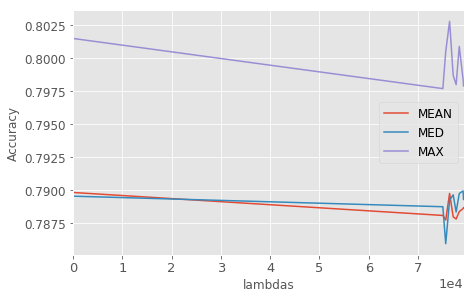

In [39]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

final_acc_grouped_by_lmbda.plot(y=['MEAN','MED','MAX'],x='lambdas')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Init the writer with $\lambda$s (7.5, 10.0) non-spk classification

In [11]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_14lmbdas_ar1_3lyrs_he1_75_10-non_spk', sess.graph)

### Generate $\lambda$s

In [12]:
np.random.seed(100)
n_lmbdas = 14
a = np.random.uniform(low=7.5, high=10.0, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 10
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[8.85851235 8.19592346 8.56129398 9.61194033 7.51179714 7.8039228
 9.17687271 9.56463189 7.84176647 8.93773332 9.72830489 8.02300531
 7.96332055 7.77094223]
()
[75117.97140477 77709.42226161 78039.22801958 78417.66474212
 79633.20548875 80230.05305293 81959.23462734 85612.93976873
 88585.12354477 89377.33323568 91768.72711817 95646.31887763
 96119.403308   97283.04885781]
()
([0, 75117.9714047743, 77709.42226160638, 78039.22801957786, 78417.66474212382, 79633.20548875188, 80230.05305292974, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 77709.42226160638, 78039.22801957786, 78417.66474212382, 79633.20548875188, 80230.05305292974, 81959.23462734491, 85612.93976872832, 88585.12354477413, 89377.33323568125, 91768.72711816947, 95646.3188776262, 96119.40330799759, 97283.04885780659, 0, 75117.9714047743, 77709.42226160638, 78039.22801957786, 78417.66474212382, 79633.20

### Generate random weights

In [13]:
lmbdas = a
np.random.seed(0)
np_weights = []
low = -np.sqrt(2.0/(n_input)) # use 4 for sigmoid, 1 for tanh activation 
high = np.sqrt(2.0/(n_input))
for i in range(n_reps):
    np_weights.append(np.random.uniform(low=low,high=high,size=(n_input,n_middle)))

np_weights=[item for item in np_weights for i in range(n_lmbdas)]
print(len(np_weights), len(lmbdas))

(150, 150)


In [14]:
np.array_equal(np_weights[0], np_weights[14])

True

In [15]:
np.array_equal(np_weights[0], np_weights[15])

False

### Commence training

In [16]:
START_TIME = time.time()
method3_test_accs = []
#INITIALIZE THE NETWORK
logging_count = 0
sess.run(init_op,options=run_options, run_metadata=run_metadata)
sess.graph.finalize()
for l in range(len(lmbdas)):
    print('Training with lmbda:{}, {}'.format(lmbdas[l], l))
    #sess.run(init_op,options=run_options, run_metadata=run_metadata)
    zeta = 1e-3
    new_big_omeg_w2 = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    new_big_omeg_b2 = np.zeros(shape=[1,n_middle], dtype=np.float32)
    w3_zeros = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    b3_zeros = np.zeros(shape=[1,n_out], dtype=np.float32)
    w3_accum = np.zeros(shape=[n_middle,n_out], dtype=np.float32)
    w3_accum = []
    b3_accum = np.zeros(shape=[1,n_out], dtype=np.float32)
    b3_accum = []
    reset_w2_grad_accum = np.zeros(shape=[n_input,n_middle], dtype=np.float32)
    reset_b2_grad_accum = np.zeros(shape=[1,n_middle], dtype=np.float32)

    start_w2 = None
    start_b2 = None
    sess.run(w_2_update_op, {w_2_update_placeholder:np_weights[l]})
    sess.run(b_2_update_op, {b_2_update_placeholder:np.zeros(shape=[1,n_middle],dtype=np.float32)})
    end_w2 = None
    end_b2 = None

    old_test_data = []
    historical_cross_test_acc = {}
    historical_train_accuracies = {}
    historical_train_costs = {}
    historical_val_accuracies = {}
    historical_val_costs = {}
    sets = [(0,1), (2,3), (4,5), (6,7), (8,9)]
    #sets = [(0,4),(5,9)]
    test_labels_set = []
    
    n_test_samples = []
    for a_set in range(len(sets)):
        current_set = sets[a_set]
        current_set_name = 'set'+str(a_set)
        mask_val = [0]*num_classes
        for i in range(0, current_set[1]+1):
            mask_val[i]=1
        set_mask_val = np.array(mask_val, dtype=np.float32)
        print('Current mask:{}'.format(set_mask_val))
        train_data_set, valid_data_set, test_data_set = extract_class_data(start=current_set[0],
                                                                      stop=current_set[1])
        train_images_set, train_labels_set = train_data_set[0], train_data_set[1]
        valid_images_set, valid_labels_set = valid_data_set[0], valid_data_set[1]
        test_images_set, test_labels_set = test_data_set[0], test_data_set[1]
        n_test_samples.append(len(test_labels_set))
        train_total = len(train_images_set)
        n_batches = len(train_images_set)/BATCH_SIZE
        #@@print('Number of batches:{}'.format(n_batches))


        #@@set_omegas = [tf.assign(big_omeg_w2, new_big_omeg_w2), tf.assign(big_omeg_b2, new_big_omeg_b2)]
        #@@sess.run(set_omegas)
        
        sess.run(big_omeg_w2_update_op, {big_omeg_w2_update_placeholder:new_big_omeg_w2})
        sess.run(big_omeg_b2_update_op, {big_omeg_b2_update_placeholder:new_big_omeg_b2})

        #@@reset_grad_accums = [tf.assign(w2_grad_accum, reset_w2_grad_accum),
        #@@                     tf.assign(b2_grad_accum, reset_b2_grad_accum)]
        #@@sess.run(reset_grad_accums)
        
        sess.run(w2_grad_accum_update_op, {w2_grad_accum_update_placeholder:reset_w2_grad_accum})
        sess.run(b2_grad_accum_update_op, {b2_grad_accum_update_placeholder:reset_b2_grad_accum})

        
        #@@reset_w3 = [tf.assign(w_3, w3_zeros), tf.assign(b_3, b3_zeros)]
        #@@sess.run(reset_w3)
        sess.run(w_3_update_op, {w_3_update_placeholder:w3_zeros})
        sess.run(b_3_update_op, {b_3_update_placeholder:b3_zeros})
    
        epochs = 10
        repeats = 1

        for repeat in range(repeats):
            #tf.set_random_seed(l)
            print('Repeat:{}'.format(repeat))
            train_accuracies = []
            train_costs = []
            val_accuracies = []
            val_costs = []
            best_val = 0
            first_params_set = None
            last_params_set = None
            T1 = time.time()
            for i in range(epochs):
                if(i==0):
                    start_w2, start_b2 = w_2.eval(), b_2.eval()
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: len(train_images_set)})
                #@@print('Epoch:{}'.format((i)))
                t1 = time.time()

                ### CALCULATE TRAIN COSTS AND TRAIN ACCURACIES
                train_cost, train_accuracy = sess.run([cost, acct_res] ,feed_dict = {drop_out : 0.0, 
                                                                                     set1_mask:set_mask_val})
                train_costs.append(train_cost)
                train_accuracies.append(train_accuracy)
                #train_writer.add_summary(summary,logging_count)

                print('training cost:{} and training accuracy:{}'.format(train_costs[i], train_accuracies[i]))

                ### CALCULATE VALID COSTS AND VALID ACCURACIES
                sess.run(iter.initializer, feed_dict={a_1: valid_images_set, y: valid_labels_set,
                                                      batch_size: len(valid_images_set)})
                _, _, val_acc, val_cost, _ = sess.run([predictions,acct_mat,acct_res, cost, a_3],
                                                      feed_dict = {drop_out : 0.0,set1_mask:set_mask_val})
                val_costs.append(val_cost)
                val_accuracies.append(val_acc)

                if(val_acc>best_val):
                    best_val = val_acc
                    best_params_set1 = [(w_2.eval(),b_2.eval()),(w_3.eval(),b_3.eval())]
                print('validation cost:{} and validation accuracy:{}'.format(val_cost, val_acc))   
                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                      batch_size: BATCH_SIZE})


                sess.run(iter.initializer, feed_dict={a_1: train_images_set, y: train_labels_set,
                                                  batch_size: BATCH_SIZE})
                print('Training on :{}'.format(current_set))
                for j in range(n_batches):

                    if(not (np.isnan(w_2.eval().any() and np.isnan(w_3.eval()).any()))):
                        #if(a_set==1):
                        #    print(j, w_2.eval().sum(), w_3.eval().sum())
                        if(((j)% 1000 ==0)):
                            logging_count+=1
                            summary,_,_ = sess.run([merged,step, omega_step], 
                                                 feed_dict = {drop_out:0.0,batch_size: BATCH_SIZE,tau:0.5,
                                                              set1_mask:set_mask_val,eta:0.001,
                                                              lmbda:lmbdas[l],n_tot:train_total})
                            #train_writer.add_summary(summary, (i+1)*j)
                            train_writer.add_summary(summary, logging_count)
                        else:
                            sess.run([step, omega_step],feed_dict = {drop_out:0.0,batch_size:BATCH_SIZE,
                                                                     tau:0.5,set1_mask:set_mask_val,
                                                                     eta:0.001,lmbda:lmbdas[l],
                                                                     n_tot:train_total})
                    else:
                        print('Nan encountered in epoch:{} and batch:{}'.format(i, j))
                #@@print('Epoch time:{}'.format(time.time()-t1))


            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,final_test_acc,_ = sess.run([predictions, acct_res, a_3], 
                                                                  feed_dict = {drop_out:0.0, 
                                                                               set1_mask:set_mask_val})
            #@@print('Final test accuracy is:{}'.format(final_test_acc))
            end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
            #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
            #@@sess.run(update_star_wbs)
            sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
            sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
            
            
            #all_final_test_accs_set1.append(final_test_acc)


            #@@best_step = [tf.assign(w_2,best_params_set1[0][0]), tf.assign(b_2,best_params_set1[0][1]),
            #@@             tf.assign(w_3,best_params_set1[1][0]),tf.assign(b_3,best_params_set1[1][1])]
            #@@sess.run(best_step)
            
            sess.run(w_2_update_op, {w_2_update_placeholder:best_params_set1[0][0]})
            sess.run(b_2_update_op, {b_2_update_placeholder:best_params_set1[0][1]})
            
            sess.run(w_3_update_op, {w_3_update_placeholder:best_params_set1[1][0]})
            sess.run(b_3_update_op, {b_3_update_placeholder:best_params_set1[1][1]})
            
            sess.run(iter.initializer, feed_dict={a_1: test_images_set, y: test_labels_set,
                                                      batch_size: len(test_images_set)})
            _,test_acc_corresp_best_val,_ = sess.run([predictions, acct_res, a_3],
                                                     feed_dict = {drop_out:0.0,set1_mask:set_mask_val})

            #@@print('Test accuracy corresp to best val acc:{}'.format(test_acc_corresp_best_val))
            print('Time taken:{}'.format(time.time()-T1))
            #w3_list.append(w_3.eval())
            w3_accum.append(w_3.eval())
            #b3_list.append(b_3.eval())
            b3_accum.append(b_3.eval())
            if(i==epochs-1):
                if(test_acc_corresp_best_val>final_test_acc):
                    end_w2, end_b2, end_w3, end_b3 = w_2.eval(), b_2.eval(), w_3.eval(), b_3.eval()
                    #all_final_test_accs_set1[-1] = test_acc_corresp_best_val
                    #@@update_star_wbs = [tf.assign(star_w2,end_w2),tf.assign(star_b2,end_b2)]
                    #@@sess.run(update_star_wbs)
                    
                    sess.run(star_w2_update_op, {star_w2_update_placeholder:end_w2})
                    sess.run(star_b2_update_op, {star_b2_update_placeholder:end_b2})
                    

                #@@best_step = [tf.assign(w_2,end_w2), tf.assign(b_2,end_b2),
                #@@         tf.assign(w_3,end_w3),tf.assign(b_3,end_b3)]
                #@@sess.run(best_step)
                
                
                sess.run(w_2_update_op, {w_2_update_placeholder:end_w2})
                sess.run(b_2_update_op, {b_2_update_placeholder:end_b2})
                
                sess.run(w_3_update_op, {w_3_update_placeholder:end_w3})
                sess.run(b_3_update_op, {b_3_update_placeholder:end_b3})

                first_params_set = [(start_w2, start_b2)]
                last_params_set = [(end_w2, end_b2)]

                small_omegas = [(w2_grad_accum.eval(),b2_grad_accum.eval())]

                delta_ws = map(lambda x,y: np.square(x-y)+zeta,[item[0] for item in last_params_set],
                           [item[0] for item in first_params_set])

                delta_bs = map(lambda x,y: np.square(x-y)+zeta,[item[1] for item in last_params_set],
                           [item[1] for item in first_params_set])
                delta_wbs = zip(delta_ws, delta_bs)

                big_omegas_ws = map(lambda x,y: (x/y),[item[0] for item in small_omegas],
                           [item[0] for item in delta_wbs])            
                big_omegas_bs = map(lambda x,y: (x/y),[item[1] for item in small_omegas],
                           [item[1] for item in delta_wbs])

                big_omegas = zip(big_omegas_ws, big_omegas_bs)
                new_big_omeg_w2 += big_omegas[0][0]
                new_big_omeg_b2 += big_omegas[0][1]
                #@@print('omegW2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_w2.max(),
                #@@                                                new_big_omeg_w2.mean(),
                #@@                                                new_big_omeg_w2.std()))
                #@@print('omegb2-MAXIMUM:{},MEAN:{},STD:{}'.format(new_big_omeg_b2.max(),
                #@@                                                new_big_omeg_b2.mean(),
                #@@                                                new_big_omeg_b2.std()))

        historical_train_accuracies[current_set_name]=train_accuracies
        historical_train_costs[current_set_name]=train_costs
        historical_val_accuracies[current_set_name]=val_accuracies
        historical_val_costs[current_set_name]=val_costs
    
    #######Method 3 ###########
    w3_set_rows = []
    offset=0
    for item in w3_accum:
        w3_set_rows.append(item[:,offset:offset+2])
        offset+=2


    w3_set_row_avgs = [item.mean() for item in w3_set_rows]
    final_w3 = map(lambda x,y:x-y,w3_set_rows, w3_set_row_avgs)
    final_w3 = np.concatenate(final_w3, axis=1)

    b3_set_rows = []
    offset=0
    for item in b3_accum:
        b3_set_rows.append(item[:,offset:offset+2])
        offset+=2
    b3_set_row_avgs = [item.mean() for item in b3_set_rows]
    final_b3 = map(lambda x,y:x-y,b3_set_rows, b3_set_row_avgs)
    final_b3 = np.concatenate(final_b3, axis=1)

    #@@set_w3 = [tf.assign(w_3, final_w3), tf.assign(b_3, final_b3)]
    #@@sess.run(set_w3)
    sess.run(w_3_update_op, {w_3_update_placeholder:final_w3})
    sess.run(b_3_update_op, {b_3_update_placeholder:final_b3})

    sess.run(iter.initializer, feed_dict={a_1: test_images, y: to_categorical(test_labels,num_classes=num_classes),
                                                      batch_size: len(test_images)})
    _,final_test_acc,_ = sess.run([predictions, acct_res, a_3],
                                  feed_dict = {drop_out:0.0,set1_mask:set_mask_val})
    method3_test_accs.append(final_test_acc)
    print('Method 3 test accuracy:{}'.format(final_test_acc))
    
    
train_writer.close()
print('Total time:{}'.format(time.time()-START_TIME))

Training with lmbda:0, 0
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.223329275846 and training accuracy:0.997657477856
validation cost:0.217609897256 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0588664598763 and training accuracy:0.99809128046
validation cost:0.0582027807832 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0329026244581 and training accuracy:0.998264789581
validation cost:0.0331324525177 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.023102754727 and training accuracy:0.998611807823
validation cost:0.0236389841884 and validation accuracy:0.9973

Training on :(8, 9)
training cost:0.0644264519215 and training accuracy:0.980350136757
validation cost:0.0669165104628 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0573468096554 and training accuracy:0.983050823212
validation cost:0.0592649653554 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0517177283764 and training accuracy:0.985006511211
validation cost:0.0530807264149 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0471327267587 and training accuracy:0.986496567726
validation cost:0.047990180552 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:117.707244873
Method 3 test accuracy:0.729499995708
Training with lmbda:75117.9714048, 1
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 

Training on :(8, 9)
training cost:0.226389616728 and training accuracy:0.955578327179
validation cost:0.227733150125 and validation accuracy:0.94915252924
Training on :(8, 9)
training cost:0.138211235404 and training accuracy:0.965263545513
validation cost:0.140243172646 and validation accuracy:0.958568751812
Training on :(8, 9)
training cost:0.106288217008 and training accuracy:0.972248077393
validation cost:0.108712859452 and validation accuracy:0.970809817314
Training on :(8, 9)
training cost:0.0885949581861 and training accuracy:0.975414395332
validation cost:0.0909430682659 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0768813639879 and training accuracy:0.978860139847
validation cost:0.0789270550013 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0683953091502 and training accuracy:0.981188297272
validation cost:0.0700572058558 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.061908826232 and training

Training on :(6, 7)
training cost:0.0187133066356 and training accuracy:0.998827457428
validation cost:0.0175366848707 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0170100964606 and training accuracy:0.999098062515
validation cost:0.0158882550895 and validation accuracy:1.0
Training on :(6, 7)
Time taken:129.317036152
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.227086961269 and training accuracy:0.955485165119
validation cost:0.228533491492 and validation accuracy:0.94915252924
Training on :(8, 9)
training cost:0.138811662793 and training accuracy:0.965263545513
validation cost:0.14094850421 and validation accuracy:0.958568751812
Training on :(8, 

Training on :(6, 7)
training cost:0.0454644598067 and training accuracy:0.997023522854
validation cost:0.0434526242316 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0343466699123 and training accuracy:0.997654914856
validation cost:0.0327138081193 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0279838461429 and training accuracy:0.998015701771
validation cost:0.0265429839492 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0238407924771 and training accuracy:0.998376488686
validation cost:0.0225172303617 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0209137741476 and training accuracy:0.998556852341
validation cost:0.0196723937988 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0187261532992 and training accuracy:0.998827457428
validation cost:0.0175494216383 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0170222762972 and training accuracy:0.9990

Training on :(4, 5)
Time taken:132.411756992
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.162190288305 and training accuracy:0.990619659424
validation cost:0.155851140618 and validation accuracy:0.990875899792
Training on :(6, 7)
training cost:0.0700075626373 and training accuracy:0.995760798454
validation cost:0.0670409277081 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0454866550863 and training accuracy:0.997023522854
validation cost:0.0434742793441 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0343664810061 and training accuracy:0.997654914856
validation cost:0.0327331647277 and validation accuracy:0.9981

Training on :(4, 5)
training cost:0.0436116456985 and training accuracy:0.99590241909
validation cost:0.0363227277994 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0370544008911 and training accuracy:0.996097564697
validation cost:0.0299583990127 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0324329771101 and training accuracy:0.996292710304
validation cost:0.0255706161261 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289829690009 and training accuracy:0.996487796307
validation cost:0.0223619826138 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0262973308563 and training accuracy:0.996780514717
validation cost:0.0199128929526 and validation accuracy:1.0
Training on :(4, 5)
Time taken:113.986860037
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:10

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.234628379345 and training accuracy:0.979609727859
validation cost:0.235603541136 and validation accuracy:0.984205305576
Training on :(4, 5)
training cost:0.109511762857 and training accuracy:0.990731716156
validation cost:0.104130908847 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.071411550045 and training accuracy:0.994048774242
validation cost:0.0643904134631 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0537557043135 and training accuracy:0.994829297066
validation cost:0.0464056096971 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0436483584344 and training accuracy:0.99590241909
validation cost:0.0363605543971 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.037087533623 and training accuracy:0.996097564697
validation cost:0.0

Training on :(2, 3)
training cost:0.061246111989 and training accuracy:0.983456075191
validation cost:0.0667449459434 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0551303401589 and training accuracy:0.985183179379
validation cost:0.0600469894707 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0502603799105 and training accuracy:0.986364901066
validation cost:0.0546329729259 and validation accuracy:0.982536792755
Training on :(2, 3)
Time taken:119.964761972
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.234873235226 and training accuracy:0.979609727859
validation cost:0.235854625702 and validation accuracy:0.98420

training cost:0.178509995341 and training accuracy:0.958185613155
validation cost:0.184524103999 and validation accuracy:0.954044103622
Training on :(2, 3)
training cost:0.1231469661 and training accuracy:0.96918463707
validation cost:0.129982173443 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0963370651007 and training accuracy:0.975547671318
validation cost:0.103312730789 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0802046582103 and training accuracy:0.978729188442
validation cost:0.0868324413896 and validation accuracy:0.973345577717
Training on :(2, 3)
training cost:0.0692842900753 and training accuracy:0.981638014317
validation cost:0.0753760263324 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0613174587488 and training accuracy:0.983456075191
validation cost:0.0668154656887 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0551997609437 and training accuracy:0.985183

Training on :(0, 1)
training cost:0.00988608878106 and training accuracy:0.999132394791
validation cost:0.0106639899313 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.597644806
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.362919121981 and training accuracy:0.935096800327
validation cost:0.369297355413 and validation accuracy:0.936580896378
Training on :(2, 3)
training cost:0.178578853607 and training accuracy:0.958185613155
validation cost:0.184589579701 and validation accuracy:0.954044103622
Training on :(2, 3)
training cost:0.123211398721 and training accuracy:0.96918463707
validation cost:0.130041688681 and validation accuracy:0.96691179

Training on :(0, 1)
training cost:0.023102754727 and training accuracy:0.998611807823
validation cost:0.0236389841884 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0179823227227 and training accuracy:0.998785376549
validation cost:0.0186521094292 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0148221068084 and training accuracy:0.998872101307
validation cost:0.0155552858487 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0126652261242 and training accuracy:0.99895888567
validation cost:0.01342903357 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0110910469666 and training accuracy:0.99895888567
validation cost:0.0118674216792 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00988608878106 and training accuracy:0.999132394791
validation cost:0.0106639899313 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.446099043
Current mas

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.223329275846 and training accuracy:0.997657477856
validation cost:0.217609897256 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0588664598763 and training accuracy:0.99809128046
validation cost:0.0582027807832 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0329026244581 and training accuracy:0.998264789581
validation cost:0.0331324525177 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.023102754727 and training accuracy:0.998611807823
validation cost:0.0236389841884 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0179823227227 and training accuracy:0.998785376549
validation cost:0.0186521094292 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0148221068084 and training accuracy:0.998872

Training on :(8, 9)
training cost:0.0579715296626 and training accuracy:0.984261512756
validation cost:0.0588701739907 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0537775866687 and training accuracy:0.985658407211
validation cost:0.0543507710099 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:117.265899181
Method 3 test accuracy:0.805400013924
Training with lmbda:95646.3188776, 12
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.223329275846 and training accuracy:0.997657477856
validation cost:0.217609897256 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0588664598763 an

Training on :(8, 9)
training cost:0.107715785503 and training accuracy:0.971968710423
validation cost:0.110105164349 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0899950787425 and training accuracy:0.975600659847
validation cost:0.0922945961356 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0782861039042 and training accuracy:0.978673875332
validation cost:0.0802870541811 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0698091983795 and training accuracy:0.981002032757
validation cost:0.0714362487197 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0633279159665 and training accuracy:0.982492089272
validation cost:0.0645741596818 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0581857860088 and training accuracy:0.984075248241
validation cost:0.0590717084706 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0539936162531 and trai

Training on :(6, 7)
Time taken:121.300371885
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.228868350387 and training accuracy:0.955764591694
validation cost:0.230225265026 and validation accuracy:0.94915252924
Training on :(8, 9)
training cost:0.139813691378 and training accuracy:0.965542912483
validation cost:0.141843616962 and validation accuracy:0.958568751812
Training on :(8, 9)
training cost:0.1077394858 and training accuracy:0.971968710423
validation cost:0.110126003623 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0900188311934 and training accuracy:0.975600659847
validation cost:0.0923154950142 and validation accuracy:0.97834277153

Training on :(6, 7)
training cost:0.0288561582565 and training accuracy:0.998015701771
validation cost:0.0273997019976 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0246475972235 and training accuracy:0.998376488686
validation cost:0.0233120862395 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0216672662646 and training accuracy:0.998556852341
validation cost:0.0204163398594 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0194349773228 and training accuracy:0.998827457428
validation cost:0.0182507261634 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0176926553249 and training accuracy:0.999098062515
validation cost:0.0165648702532 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.009284019
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.148095160723 and training accuracy:0.988635361195
validation cost:0.142264857888 and validation accuracy:0.987226247787
Training on :(6, 7)
training cost:0.0630634129047 and training accuracy:0.99395686388
validation cost:0.0605249404907 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0394191816449 and training accuracy:0.996482372284
validation cost:0.0377186313272 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0286187715828 and training accuracy:0.997474491596
validation cost:0.0271934233606 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.022464312613 and training accuracy:0.997835278511
validation cost:0.0211436375976 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0184938237071 and training accuracy:0.998286306858
validation cost:0.0

Training on :(4, 5)
training cost:0.0328759402037 and training accuracy:0.995609760284
validation cost:0.0261201635003 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0293946564198 and training accuracy:0.996097564697
validation cost:0.0228282175958 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0266858506948 and training accuracy:0.996487796307
validation cost:0.0203156732023 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.426317215
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.157435953617 and training accuracy:0.991792201996
validation cost:0.15142826736 and validation accuracy:0.991788327694
Training on :(6, 7)
train

Training on :(4, 5)
training cost:0.11128666997 and training accuracy:0.99082928896
validation cost:0.106611169875 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0724999606609 and training accuracy:0.99385368824
validation cost:0.0660432875156 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0545815192163 and training accuracy:0.995024383068
validation cost:0.0476335547864 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0443355441093 and training accuracy:0.995317101479
validation cost:0.0373240858316 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.037690512836 and training accuracy:0.995512187481
validation cost:0.0307771749794 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0330106951296 and training accuracy:0.995609760284
validation cost:0.0262606274337 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0295185241848 and training accuracy:0.996097564697
validation cost:

Training on :(2, 3)
training cost:0.0503207109869 and training accuracy:0.986819386482
validation cost:0.0540452413261 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.515627861
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.239719748497 and training accuracy:0.979707300663
validation cost:0.241004034877 and validation accuracy:0.983218193054
Training on :(4, 5)
training cost:0.111321143806 and training accuracy:0.99082928896
validation cost:0.106647379696 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0725277811289 and training accuracy:0.99385368824
validation cost:0.0660725012422 and validation accuracy:0.99703848362
Tr

Training on :(2, 3)
training cost:0.0802606344223 and training accuracy:0.979274630547
validation cost:0.0859497562051 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0693070217967 and training accuracy:0.982183456421
validation cost:0.0745174735785 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.061322402209 and training accuracy:0.984092354774
validation cost:0.0660112574697 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0551996268332 and training accuracy:0.985637664795
validation cost:0.0593860931695 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0503279343247 and training accuracy:0.986819386482
validation cost:0.0540521740913 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.579584837
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.372522592545 and training accuracy:0.936914801598
validation cost:0.377817988396 and validation accuracy:0.941176474094
Training on :(2, 3)
training cost:0.180074945092 and training accuracy:0.960185408592
validation cost:0.185040295124 and validation accuracy:0.958639681339
Training on :(2, 3)
training cost:0.12350179255 and training accuracy:0.969820916653
validation cost:0.129298150539 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0964748486876 and training accuracy:0.975547671318
validation cost:0.102448426187 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0802852585912 and training accuracy:0.979274630547
validation cost:0.0859717801213 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0693312957883 and training accuracy:0.982274353504
validation cost:0.0

Training on :(0, 1)
training cost:0.0124777657911 and training accuracy:0.998785376549
validation cost:0.013283059001 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0109185688198 and training accuracy:0.998872101307
validation cost:0.0116999363527 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00972511619329 and training accuracy:0.998872101307
validation cost:0.0104805286974 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.791517019
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.372536629438 and training accuracy:0.936914801598
validation cost:0.377831816673 and validation accuracy:0.9411

Training on :(0, 1)
training cost:0.0323700904846 and training accuracy:0.998351573944
validation cost:0.0330188237131 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0227714832872 and training accuracy:0.998525083065
validation cost:0.023564402014 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0177313853055 and training accuracy:0.998525083065
validation cost:0.0185591541231 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0146114649251 and training accuracy:0.998698592186
validation cost:0.0154351312667 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0124777657911 and training accuracy:0.998785376549
validation cost:0.013283059001 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0109185688198 and training accuracy:0.998872101307
validation cost:0.0116999363527 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00972511619329 and

Method 3 test accuracy:0.770500004292
Training with lmbda:85612.9397687, 23
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.214052319527 and training accuracy:0.997483968735
validation cost:0.21057702601 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0575607717037 and training accuracy:0.997917771339
validation cost:0.0576605536044 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0323700904846 and training accuracy:0.998351573944
validation cost:0.0330188237131 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0227714832872 and training accuracy:0.998525083065
validation

Training on :(8, 9)
training cost:0.0703693702817 and training accuracy:0.981467664242
validation cost:0.0716991648078 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0636966228485 and training accuracy:0.983237087727
validation cost:0.0647257864475 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0583955198526 and training accuracy:0.984540879726
validation cost:0.0591410547495 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0540687888861 and training accuracy:0.986124038696
validation cost:0.0545561984181 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:117.459142923
Method 3 test accuracy:0.778500020504
Training with lmbda:88585.1235448, 24
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.3025853633

Training on :(8, 9)
training cost:0.141780972481 and training accuracy:0.964518547058
validation cost:0.143368974328 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10931545496 and training accuracy:0.970664918423
validation cost:0.111189484596 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0912442281842 and training accuracy:0.975228190422
validation cost:0.0930658951402 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0792485252023 and training accuracy:0.979232609272
validation cost:0.0808525457978 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0705420300364 and training accuracy:0.981467664242
validation cost:0.0718588829041 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0638720840216 and training accuracy:0.983237087727
validation cost:0.0648913085461 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0585721954703 and train

Training on :(6, 7)
training cost:0.0173248685896 and training accuracy:0.99927842617
validation cost:0.0160801485181 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.220329046
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.231274291873 and training accuracy:0.953902006149
validation cost:0.232415616512 and validation accuracy:0.952919006348
Training on :(8, 9)
training cost:0.141831576824 and training accuracy:0.964518547058
validation cost:0.143415957689 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.109360858798 and training accuracy:0.970664918423
validation cost:0.111230663955 and validation accuracy:0.972693026066
Trainin

Training on :(6, 7)
training cost:0.0348583310843 and training accuracy:0.998015701771
validation cost:0.0332106351852 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0284811258316 and training accuracy:0.998105883598
validation cost:0.0269913654774 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0243105441332 and training accuracy:0.998376488686
validation cost:0.0229130294174 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.021353283897 and training accuracy:0.998827457428
validation cost:0.0200188551098 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0191357135773 and training accuracy:0.999188244343
validation cost:0.0178503077477 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0174038410187 and training accuracy:0.99927842617
validation cost:0.0161597579718 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.130963087
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Tes

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.1593760252 and training accuracy:0.992152988911
validation cost:0.153338342905 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.070344850421 and training accuracy:0.996211767197
validation cost:0.0675023347139 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0461383983493 and training accuracy:0.997294127941
validation cost:0.044157911092 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.035043373704 and training accuracy:0.998015701771
validation cost:0.0333931148052 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.028649110347 and training accuracy:0.998105883598
validation cost:0.0271579101682 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0244645718485 and training accuracy:0.998376488686
validation cost:0.0230664

Training on :(4, 5)
training cost:0.0338840037584 and training accuracy:0.995609760284
validation cost:0.0271720234305 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0303195379674 and training accuracy:0.995999991894
validation cost:0.0237903632224 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.027542533353 and training accuracy:0.996292710304
validation cost:0.0212029386312 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.959310055
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.159419313073 and training accuracy:0.992152988911
validation cost:0.153380811214 and validation accuracy:0.991788327694
Training on :(6, 7)
train

Training on :(4, 5)
training cost:0.11324518919 and training accuracy:0.990634143353
validation cost:0.108659438789 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0740628167987 and training accuracy:0.99385368824
validation cost:0.0676831230521 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.055897783488 and training accuracy:0.994926810265
validation cost:0.0490140281618 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0454819202423 and training accuracy:0.995121955872
validation cost:0.0385243631899 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.038711939007 and training accuracy:0.995512187481
validation cost:0.0318454168737 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0339351184666 and training accuracy:0.995609760284
validation cost:0.0272255185992 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0303664430976 and training accuracy:0.995999991894
validation cost:

Training on :(2, 3)
training cost:0.047342646867 and training accuracy:0.987455666065
validation cost:0.0519990622997 and validation accuracy:0.983455896378
Training on :(2, 3)
Time taken:121.609607935
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.215421631932 and training accuracy:0.982341468334
validation cost:0.21619617939 and validation accuracy:0.988153994083
Training on :(4, 5)
training cost:0.095820762217 and training accuracy:0.991804897785
validation cost:0.0906429588795 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0600185543299 and training accuracy:0.994731724262
validation cost:0.0533670336008 and validation accuracy:0.99901282

training cost:0.0938115864992 and training accuracy:0.976820290089
validation cost:0.100721910596 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0781690776348 and training accuracy:0.979456424713
validation cost:0.0847627222538 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0675989836454 and training accuracy:0.982456147671
validation cost:0.0737013667822 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0599054992199 and training accuracy:0.984365046024
validation cost:0.0654711052775 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.05400583148 and training accuracy:0.985546767712
validation cost:0.0590389110148 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0493100918829 and training accuracy:0.987364768982
validation cost:0.0538352392614 and validation accuracy:0.980698525906
Training on :(2, 3)
Time taken:119.538048983
Current mask:[1. 1. 1. 1. 1. 1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.356910258532 and training accuracy:0.941914379597
validation cost:0.362852782011 and validation accuracy:0.947610318661
Training on :(2, 3)
training cost:0.174086198211 and training accuracy:0.960639953613
validation cost:0.180104225874 and validation accuracy:0.957720577717
Training on :(2, 3)
training cost:0.119940377772 and training accuracy:0.970639050007
validation cost:0.126725509763 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0938656702638 and training accuracy:0.976820290089
validation cost:0.100770168006 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0782221779227 and training accuracy:0.979456424713
validation cost:0.0848103165627 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0676516741514 and training accuracy:0.982456147671
validation cost:0.

Training on :(0, 1)
training cost:0.0127701452002 and training accuracy:0.998611807823
validation cost:0.0144818667322 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0112010780722 and training accuracy:0.998785376549
validation cost:0.0128718838096 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00999860651791 and training accuracy:0.998872101307
validation cost:0.0116260834038 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.897274017
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.356917619705 and training accuracy:0.941914379597
validation cost:0.362859994173 and validation accuracy:0.947

training cost:0.0574855171144 and training accuracy:0.997657477856
validation cost:0.0584013052285 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0326592624187 and training accuracy:0.998178005219
validation cost:0.0342191010714 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0230930075049 and training accuracy:0.998438298702
validation cost:0.024815376848 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.018046265468 and training accuracy:0.998438298702
validation cost:0.019803121686 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0149149270728 and training accuracy:0.998525083065
validation cost:0.0166585091501 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0127701452002 and training accuracy:0.998611807823
validation cost:0.0144818667322 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0112010780722 and training accuracy:0.9

Training on :(8, 9)
Time taken:116.944620132
Method 3 test accuracy:0.763700008392
Training with lmbda:79633.2054888, 35
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.205862998962 and training accuracy:0.99705016613
validation cost:0.202450796962 and validation accuracy:0.996488153934
Training on :(0, 1)
training cost:0.0574855171144 and training accuracy:0.997657477856
validation cost:0.0584013052285 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0326592624187 and training accuracy:0.998178005219
validation cost:0.0342191010714 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0230930075049 an

training cost:0.0776342898607 and training accuracy:0.978766977787
validation cost:0.0796858221292 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0691978633404 and training accuracy:0.981560826302
validation cost:0.0709040686488 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0627310872078 and training accuracy:0.983330249786
validation cost:0.0640850663185 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0575890131295 and training accuracy:0.984447777271
validation cost:0.0586145780981 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0533912107348 and training accuracy:0.985844671726
validation cost:0.0541223660111 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:126.986894846
Method 3 test accuracy:0.763899981976
Training with lmbda:80230.0530529, 36
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train featur

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.227906256914 and training accuracy:0.955578327179
validation cost:0.229337707162 and validation accuracy:0.953860640526
Training on :(8, 9)
training cost:0.13858050108 and training accuracy:0.965915441513
validation cost:0.140650510788 and validation accuracy:0.96516007185
Training on :(8, 9)
training cost:0.106823593378 and training accuracy:0.971503078938
validation cost:0.109225332737 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0892862454057 and training accuracy:0.975414395332
validation cost:0.0916082412004 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0776673704386 and training accuracy:0.978766977787
validation cost:0.079716026783 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0692316815257 and training accuracy:0.981560826302
validation cost:0.070

Training on :(6, 7)
training cost:0.0208560470492 and training accuracy:0.998827457428
validation cost:0.0194593407214 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0186390597373 and training accuracy:0.999098062515
validation cost:0.0172838587314 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0169146154076 and training accuracy:0.999188244343
validation cost:0.0155946230516 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.482760906
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.228111371398 and training accuracy:0.955485165119
validation cost:0.229538738728 and validation accuracy:0.953860640526
Training on :

training cost:0.0707423090935 and training accuracy:0.995129406452
validation cost:0.0678257122636 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0459711290896 and training accuracy:0.997203946114
validation cost:0.043949753046 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0346703119576 and training accuracy:0.997474491596
validation cost:0.0329787693918 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0281917322427 and training accuracy:0.998015701771
validation cost:0.0266534332186 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0239727236331 and training accuracy:0.998466670513
validation cost:0.0225191637874 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0209930315614 and training accuracy:0.998827457428
validation cost:0.0195941925049 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0187676101923 and training accuracy:0.999

Training on :(4, 5)
training cost:0.0262794755399 and training accuracy:0.997365832329
validation cost:0.0204205419868 and validation accuracy:1.0
Training on :(4, 5)
Time taken:111.964121103
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.162360072136 and training accuracy:0.989988267422
validation cost:0.156193733215 and validation accuracy:0.990875899792
Training on :(6, 7)
training cost:0.0709294900298 and training accuracy:0.995129406452
validation cost:0.0680085718632 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0461285188794 and training accuracy:0.997203946114
validation cost:0.0441030077636 and validation accuracy:0.997262775898
Tr

Training on :(4, 5)
training cost:0.05333968997 and training accuracy:0.995609760284
validation cost:0.0467597097158 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0433971062303 and training accuracy:0.996390223503
validation cost:0.0368236005306 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0369331277907 and training accuracy:0.99658536911
validation cost:0.0304964762181 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0323714017868 and training accuracy:0.996878027916
validation cost:0.0261180251837 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289641860873 and training accuracy:0.997365832329
validation cost:0.0229083076119 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0263102259487 and training accuracy:0.997365832329
validation cost:0.0204525329173 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.582938194
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Leng

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.233390763402 and training accuracy:0.983219504356
validation cost:0.234765574336 and validation accuracy:0.987166821957
Training on :(4, 5)
training cost:0.108415469527 and training accuracy:0.991999983788
validation cost:0.10378279537 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0708606243134 and training accuracy:0.994439005852
validation cost:0.0646533742547 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0534895211458 and training accuracy:0.995609760284
validation cost:0.0469162389636 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0435281582177 and training accuracy:0.996390223503
validation cost:0.0369603745639 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0370506457984 and training accuracy:0.99658536911
validation cost:0.0306190885603 and validation acc

Training on :(2, 3)
training cost:0.0603023394942 and training accuracy:0.984365046024
validation cost:0.0658414140344 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0543974041939 and training accuracy:0.985546767712
validation cost:0.0594103820622 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0496960394084 and training accuracy:0.987273871899
validation cost:0.0542071275413 and validation accuracy:0.980698525906
Training on :(2, 3)
Time taken:120.053583145
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.233906984329 and training accuracy:0.98331707716
validation cost:0.235299706459 and validation accuracy:0.98716

training cost:0.174487963319 and training accuracy:0.960730850697
validation cost:0.18048158288 and validation accuracy:0.957720577717
Training on :(2, 3)
training cost:0.120319649577 and training accuracy:0.970639050007
validation cost:0.127069070935 and validation accuracy:0.965992629528
Training on :(2, 3)
training cost:0.0942342877388 and training accuracy:0.976820290089
validation cost:0.101099379361 and validation accuracy:0.972426474094
Training on :(2, 3)
training cost:0.0785854160786 and training accuracy:0.979456424713
validation cost:0.0851380228996 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0680098980665 and training accuracy:0.982456147671
validation cost:0.0740780085325 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.060311332345 and training accuracy:0.984365046024
validation cost:0.0658500343561 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0544063076377 and training accuracy:0.98554

Training on :(0, 1)
training cost:0.00999860651791 and training accuracy:0.998872101307
validation cost:0.0116260834038 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.655347824
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.357349514961 and training accuracy:0.941914379597
validation cost:0.363284170628 and validation accuracy:0.947610318661
Training on :(2, 3)
training cost:0.174512937665 and training accuracy:0.960730850697
validation cost:0.180505156517 and validation accuracy:0.957720577717
Training on :(2, 3)
training cost:0.120343074203 and training accuracy:0.970639050007
validation cost:0.127090424299 and validation accuracy:0.9659926

Training on :(0, 1)
training cost:0.0181377958506 and training accuracy:0.998611807823
validation cost:0.0195580385625 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0149348024279 and training accuracy:0.998611807823
validation cost:0.0163600984961 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0127494847402 and training accuracy:0.998611807823
validation cost:0.0141588198021 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0111558279023 and training accuracy:0.998698592186
validation cost:0.0125384526327 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00993795134127 and training accuracy:0.998872101307
validation cost:0.0112892948091 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.484321117
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid f

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.226786181331 and training accuracy:0.997483968735
validation cost:0.22298695147 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0595840364695 and training accuracy:0.997917771339
validation cost:0.0601139031351 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0332592837512 and training accuracy:0.99809128046
validation cost:0.0344407819211 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0233266986907 and training accuracy:0.998438298702
validation cost:0.024691702798 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0181377958506 and training accuracy:0.998611807823
validation cost:0.0195580385625 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0149348024279 and training accuracy:0.9986118

Training on :(8, 9)
training cost:0.0574733130634 and training accuracy:0.984633982182
validation cost:0.0576541647315 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0532685704529 and training accuracy:0.985844671726
validation cost:0.0531886257231 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:117.329456806
Method 3 test accuracy:0.787899971008
Training with lmbda:77709.4222616, 47
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.226786181331 and training accuracy:0.997483968735
validation cost:0.22298695147 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0595840364695 an

training cost:0.10640514642 and training accuracy:0.972620606422
validation cost:0.108032286167 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0891316533089 and training accuracy:0.975786924362
validation cost:0.0905692726374 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0776134356856 and training accuracy:0.979046404362
validation cost:0.0787489041686 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0692171528935 and training accuracy:0.981095194817
validation cost:0.0700167641044 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0627640485764 and training accuracy:0.983237087727
validation cost:0.0632387474179 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0576268061996 and training accuracy:0.984354615211
validation cost:0.0578076988459 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0534260421991 and training accuracy:0.985

Training on :(6, 7)
Time taken:120.690262079
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.223652586341 and training accuracy:0.955857694149
validation cost:0.225400209427 and validation accuracy:0.952919006348
Training on :(8, 9)
training cost:0.137406930327 and training accuracy:0.965542912483
validation cost:0.139017358422 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.106420777738 and training accuracy:0.972620606422
validation cost:0.108047574759 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0891480669379 and training accuracy:0.975786924362
validation cost:0.09058509022 and validation accuracy:0.9802259802

Training on :(6, 7)
training cost:0.0287036914378 and training accuracy:0.997745096684
validation cost:0.0269858967513 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0243701077998 and training accuracy:0.998015701771
validation cost:0.0227742791176 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0213183239102 and training accuracy:0.998556852341
validation cost:0.0198112074286 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0190441850573 and training accuracy:0.998827457428
validation cost:0.0176066961139 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0172777362168 and training accuracy:0.998917639256
validation cost:0.0158995557576 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.287108898
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.167778387666 and training accuracy:0.989266693592
validation cost:0.161157622933 and validation accuracy:0.990875899792
Training on :(6, 7)
training cost:0.0728664547205 and training accuracy:0.994407892227
validation cost:0.0696409717202 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0471416898072 and training accuracy:0.996662735939
validation cost:0.044855710119 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0354445464909 and training accuracy:0.997745096684
validation cost:0.0335315316916 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0287617705762 and training accuracy:0.997745096684
validation cost:0.027042509988 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0244235638529 and training accuracy:0.998015701771
validation cost:0.0

Training on :(4, 5)
training cost:0.0323313064873 and training accuracy:0.996292710304
validation cost:0.0255788061768 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289080776274 and training accuracy:0.996682941914
validation cost:0.0223564319313 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0262432117015 and training accuracy:0.99726831913
validation cost:0.0198946595192 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.423499107
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.167843461037 and training accuracy:0.989266693592
validation cost:0.161221578717 and validation accuracy:0.990875899792
Training on :(6, 7)
train

Training on :(4, 5)
training cost:0.108572885394 and training accuracy:0.990438997746
validation cost:0.103780053556 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0709830522537 and training accuracy:0.99385368824
validation cost:0.0643928572536 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0535333119333 and training accuracy:0.995512187481
validation cost:0.0464971400797 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0435207113624 and training accuracy:0.99590241909
validation cost:0.0364625491202 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0370099842548 and training accuracy:0.996097564697
validation cost:0.0300783868879 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0324164144695 and training accuracy:0.996292710304
validation cost:0.02566665411 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289857201278 and training accuracy:0.996682941914
validation cost:

Training on :(2, 3)
training cost:0.0491616129875 and training accuracy:0.987364768982
validation cost:0.0537711381912 and validation accuracy:0.981617629528
Training on :(2, 3)
Time taken:119.935232878
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.232954293489 and training accuracy:0.979512214661
validation cost:0.234703570604 and validation accuracy:0.984205305576
Training on :(4, 5)
training cost:0.10894395411 and training accuracy:0.990438997746
validation cost:0.104171156883 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0712818726897 and training accuracy:0.99385368824
validation cost:0.0647067502141 and validation accuracy:0.99703848

training cost:0.0931167677045 and training accuracy:0.976365804672
validation cost:0.100339859724 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0777526721358 and training accuracy:0.979547321796
validation cost:0.0845791697502 and validation accuracy:0.973345577717
Training on :(2, 3)
training cost:0.0673393681645 and training accuracy:0.982728838921
validation cost:0.073610521853 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0597333833575 and training accuracy:0.984819591045
validation cost:0.0654211491346 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0538838617504 and training accuracy:0.986455798149
validation cost:0.0590122230351 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0492174103856 and training accuracy:0.987364768982
validation cost:0.0538269914687 and validation accuracy:0.981617629528
Training on :(2, 3)
Time taken:120.219985008
Current mask:[1. 1. 1. 1. 1. 1. 0. 0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.350558817387 and training accuracy:0.939823627472
validation cost:0.35714289546 and validation accuracy:0.942095577717
Training on :(2, 3)
training cost:0.171651288867 and training accuracy:0.961548924446
validation cost:0.178146645427 and validation accuracy:0.958639681339
Training on :(2, 3)
training cost:0.1186876297 and training accuracy:0.97127532959
validation cost:0.125890806317 and validation accuracy:0.965073525906
Training on :(2, 3)
training cost:0.0931327790022 and training accuracy:0.976365804672
validation cost:0.10035455972 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0777684077621 and training accuracy:0.979547321796
validation cost:0.0845937654376 and validation accuracy:0.973345577717
Training on :(2, 3)
training cost:0.0673551857471 and training accuracy:0.982728838921
validation cost:0.073625512421

Training on :(0, 1)
training cost:0.0127494847402 and training accuracy:0.998611807823
validation cost:0.0141588198021 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0111558279023 and training accuracy:0.998698592186
validation cost:0.0125384526327 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00993795134127 and training accuracy:0.998872101307
validation cost:0.0112892948091 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.646389961
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.350612610579 and training accuracy:0.939823627472
validation cost:0.357195943594 and validation accuracy:0.942

training cost:0.0595840364695 and training accuracy:0.997917771339
validation cost:0.0601139031351 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0332592837512 and training accuracy:0.99809128046
validation cost:0.0344407819211 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0233266986907 and training accuracy:0.998438298702
validation cost:0.024691702798 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0181377958506 and training accuracy:0.998611807823
validation cost:0.0195580385625 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0149348024279 and training accuracy:0.998611807823
validation cost:0.0163600984961 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0127494847402 and training accuracy:0.998611807823
validation cost:0.0141588198021 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0111558279023 and training accuracy:0.

Training on :(8, 9)
Time taken:116.954058886
Method 3 test accuracy:0.787100017071
Training with lmbda:96119.403308, 58
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.226786181331 and training accuracy:0.997483968735
validation cost:0.22298695147 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0595840364695 and training accuracy:0.997917771339
validation cost:0.0601139031351 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0332592837512 and training accuracy:0.99809128046
validation cost:0.0344407819211 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0233266986907 and 

training cost:0.0785460472107 and training accuracy:0.978766977787
validation cost:0.0796469375491 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0701955333352 and training accuracy:0.980908930302
validation cost:0.0709713101387 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0637798160315 and training accuracy:0.983143985271
validation cost:0.0642440393567 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0586696900427 and training accuracy:0.984168350697
validation cost:0.0588527694345 and validation accuracy:0.988700568676
Training on :(8, 9)
training cost:0.0544900707901 and training accuracy:0.985192775726
validation cost:0.054424777627 and validation accuracy:0.989642202854
Training on :(8, 9)
Time taken:117.150444984
Method 3 test accuracy:0.78719997406
Training with lmbda:97283.0488578, 59
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.225465163589 and training accuracy:0.956137061119
validation cost:0.227214619517 and validation accuracy:0.952919006348
Training on :(8, 9)
training cost:0.138401672244 and training accuracy:0.965822339058
validation cost:0.14001083374 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10732177645 and training accuracy:0.972527444363
validation cost:0.108924977481 and validation accuracy:0.974576294422
Training on :(8, 9)
training cost:0.0900737345219 and training accuracy:0.975973188877
validation cost:0.0914750918746 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0786042809486 and training accuracy:0.978766977787
validation cost:0.0797040611506 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0702561736107 and training accuracy:0.980908930302
validation cost:0.0

Training on :(6, 7)
training cost:0.0164642892778 and training accuracy:0.998015701771
validation cost:0.0157337430865 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0143147092313 and training accuracy:0.998286306858
validation cost:0.0135510964319 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0126600628719 and training accuracy:0.998556852341
validation cost:0.0118714328855 and validation accuracy:1.0
Training on :(6, 7)
Time taken:120.536652088
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.220429703593 and training accuracy:0.949711322784
validation cost:0.223639249802 and validation accuracy:0.94350284338
Train

Training on :(6, 7)
training cost:0.0701415166259 and training accuracy:0.99485886097
validation cost:0.0679337233305 and validation accuracy:0.994525551796
Training on :(6, 7)
training cost:0.0457577481866 and training accuracy:0.996572554111
validation cost:0.0445026829839 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0345761999488 and training accuracy:0.997294127941
validation cost:0.0336425714195 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0281439423561 and training accuracy:0.997835278511
validation cost:0.0273304861039 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.023945517838 and training accuracy:0.997925519943
validation cost:0.0231815315783 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0209766849875 and training accuracy:0.998286306858
validation cost:0.0202347673476 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0187578313053 and traini

Training on :(4, 5)
training cost:0.0262936782092 and training accuracy:0.996780514717
validation cost:0.020047865808 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.581938982
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.159580796957 and training accuracy:0.990619659424
validation cost:0.153818845749 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0703043416142 and training accuracy:0.99485886097
validation cost:0.0680939108133 and validation accuracy:0.994525551796
Training on :(6, 7)
training cost:0.0458986014128 and training accuracy:0.996572554111
validation cost:0.0446417927742 and validation accuracy:0.997262775898
Trai

Training on :(4, 5)
training cost:0.0532758198678 and training accuracy:0.995317101479
validation cost:0.0461804904044 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0433971881866 and training accuracy:0.995804905891
validation cost:0.036324121058 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.036951571703 and training accuracy:0.995999991894
validation cost:0.0300418436527 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0323902964592 and training accuracy:0.996195137501
validation cost:0.0256935935467 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0289740581065 and training accuracy:0.99658536911
validation cost:0.0225039049983 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0263074208051 and training accuracy:0.996780514717
validation cost:0.0200619287789 and validation accuracy:1.0
Training on :(4, 5)
Time taken:111.949266195
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Leng

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.230680689216 and training accuracy:0.981756091118
validation cost:0.23150408268 and validation accuracy:0.98617964983
Training on :(4, 5)
training cost:0.107448227704 and training accuracy:0.991219520569
validation cost:0.102343961596 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0704729035497 and training accuracy:0.994439005852
validation cost:0.0637518316507 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0533031113446 and training accuracy:0.995317101479
validation cost:0.0462088547647 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0434208102524 and training accuracy:0.995804905891
validation cost:0.0363485664129 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0369725041091 and training accuracy:0.995999991894
validation cost:0.0300634689629 and vali

Training on :(2, 3)
training cost:0.0609796568751 and training accuracy:0.984455943108
validation cost:0.0664370581508 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0549280717969 and training accuracy:0.985819458961
validation cost:0.0598907321692 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0501119531691 and training accuracy:0.987364768982
validation cost:0.0546036325395 and validation accuracy:0.983455896378
Training on :(2, 3)
Time taken:119.665117025
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.230871662498 and training accuracy:0.981756091118
validation cost:0.231701925397 and validation accuracy:0.9861

training cost:0.178123310208 and training accuracy:0.959094643593
validation cost:0.183995768428 and validation accuracy:0.954963207245
Training on :(2, 3)
training cost:0.122523859143 and training accuracy:0.970002710819
validation cost:0.129154905677 and validation accuracy:0.965073525906
Training on :(2, 3)
training cost:0.095783315599 and training accuracy:0.975184082985
validation cost:0.102523393929 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0797378793359 and training accuracy:0.97936552763
validation cost:0.0861693844199 and validation accuracy:0.977022051811
Training on :(2, 3)
training cost:0.0688902139664 and training accuracy:0.982274353504
validation cost:0.074853092432 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0609926506877 and training accuracy:0.984455943108
validation cost:0.066449098289 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.054940789938 and training accuracy:0.98581945

Training on :(0, 1)
training cost:0.00988013762981 and training accuracy:0.999219179153
validation cost:0.0111610898748 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.030929089
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.365085750818 and training accuracy:0.934733211994
validation cost:0.370923429728 and validation accuracy:0.9375
Training on :(2, 3)
training cost:0.178167656064 and training accuracy:0.959094643593
validation cost:0.18403762579 and validation accuracy:0.954963207245
Training on :(2, 3)
training cost:0.122565209866 and training accuracy:0.970002710819
validation cost:0.129192709923 and validation accuracy:0.965073525906
Tra

Training on :(0, 1)
training cost:0.0178789626807 and training accuracy:0.998611807823
validation cost:0.0193645320833 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147669836879 and training accuracy:0.99895888567
validation cost:0.0162060298026 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0126350782812 and training accuracy:0.999045610428
validation cost:0.0140215028077 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0110755171627 and training accuracy:0.999132394791
validation cost:0.0124083096161 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00988013762981 and training accuracy:0.999219179153
validation cost:0.0111610898748 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.249573946
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid fe

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.206088110805 and training accuracy:0.997570693493
validation cost:0.20448358357 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0570162832737 and training accuracy:0.997917771339
validation cost:0.0581067353487 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0323881059885 and training accuracy:0.998264789581
validation cost:0.0338423512876 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0228915270418 and training accuracy:0.998525083065
validation cost:0.0244005490094 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178789626807 and training accuracy:0.998611807823
validation cost:0.0193645320833 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147669836879 and training accuracy:0.99895

Training on :(8, 9)
training cost:0.0582571141422 and training accuracy:0.984540879726
validation cost:0.0590950250626 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0540555715561 and training accuracy:0.985658407211
validation cost:0.0545974113047 and validation accuracy:0.985875725746
Training on :(8, 9)
Time taken:117.190719128
Method 3 test accuracy:0.773699998856
Training with lmbda:89377.3332357, 70
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.206088110805 and training accuracy:0.997570693493
validation cost:0.20448358357 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0570162832737 and

training cost:0.107439190149 and training accuracy:0.970478653908
validation cost:0.10971147567 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0899455845356 and training accuracy:0.975414395332
validation cost:0.0921070799232 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0783424526453 and training accuracy:0.979046404362
validation cost:0.0802139118314 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0699105933309 and training accuracy:0.981560826302
validation cost:0.0714310482144 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0634442344308 and training accuracy:0.982957720757
validation cost:0.0646104216576 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0583022199571 and training accuracy:0.984540879726
validation cost:0.0591374970973 and validation accuracy:0.98399245739
Training on :(8, 9)
training cost:0.0541011989117 and training accuracy:0.9856

Training on :(6, 7)
Time taken:120.940602064
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.228095188737 and training accuracy:0.956509590149
validation cost:0.229552268982 and validation accuracy:0.952919006348
Training on :(8, 9)
training cost:0.139183297753 and training accuracy:0.965170443058
validation cost:0.141187936068 and validation accuracy:0.96233522892
Training on :(8, 9)
training cost:0.107552014291 and training accuracy:0.970478653908
validation cost:0.109810978174 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0900619700551 and training accuracy:0.975321292877
validation cost:0.0922089368105 and validation accuracy:0.978342771

Training on :(6, 7)
training cost:0.0290389936417 and training accuracy:0.997835278511
validation cost:0.0282324068248 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0247812345624 and training accuracy:0.998105883598
validation cost:0.0240316838026 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0217629987746 and training accuracy:0.998286306858
validation cost:0.0210414715111 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0195014700294 and training accuracy:0.998827457428
validation cost:0.0187957175076 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0177364964038 and training accuracy:0.998917639256
validation cost:0.0170416552573 and validation accuracy:1.0
Training on :(6, 7)
Time taken:120.837088108
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length o

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.161234676838 and training accuracy:0.990709841251
validation cost:0.155469551682 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0714195370674 and training accuracy:0.99485886097
validation cost:0.0691937580705 and validation accuracy:0.994525551796
Training on :(6, 7)
training cost:0.0468557439744 and training accuracy:0.996662735939
validation cost:0.0455886907876 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0355686917901 and training accuracy:0.997294127941
validation cost:0.0346328653395 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0290586054325 and training accuracy:0.997835278511
validation cost:0.0282521825284 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0247994922101 and training accuracy:0.998105883598
validation cost:

Training on :(4, 5)
training cost:0.0332717224956 and training accuracy:0.996195137501
validation cost:0.0266006067395 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0297781601548 and training accuracy:0.99658536911
validation cost:0.0233279298991 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0270486623049 and training accuracy:0.996682941914
validation cost:0.020817970857 and validation accuracy:1.0
Training on :(4, 5)
Time taken:111.977311134
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.161335602403 and training accuracy:0.990709841251
validation cost:0.155570670962 and validation accuracy:0.989963531494
Training on :(6, 7)
traini

Training on :(4, 5)
training cost:0.0962906181812 and training accuracy:0.991512179375
validation cost:0.0909327343106 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0601806640625 and training accuracy:0.994341492653
validation cost:0.0534313507378 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0437421649694 and training accuracy:0.995609760284
validation cost:0.0367516838014 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0344804525375 and training accuracy:0.996097564697
validation cost:0.0275833141059 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0285620167851 and training accuracy:0.996390223503
validation cost:0.0218673981726 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0244521275163 and training accuracy:0.99658536911
validation cost:0.0179950799793 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0214275699109 and training accuracy:0.996780514717
validation 

Training on :(2, 3)
training cost:0.0492886975408 and training accuracy:0.987182974815
validation cost:0.0527030192316 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:119.995234966
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.234419107437 and training accuracy:0.981853663921
validation cost:0.235554277897 and validation accuracy:0.98617964983
Training on :(4, 5)
training cost:0.108608230948 and training accuracy:0.991707324982
validation cost:0.103783987463 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.070883244276 and training accuracy:0.994146347046
validation cost:0.0645063444972 and validation accuracy:0.998025655746
Tr

Training on :(2, 3)
training cost:0.0786297395825 and training accuracy:0.97991091013
validation cost:0.0841142386198 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0678842514753 and training accuracy:0.982274353504
validation cost:0.0728464797139 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.060073684901 and training accuracy:0.984637737274
validation cost:0.064485475421 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0540951006114 and training accuracy:0.986364901066
validation cost:0.0579873211682 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0493391603231 and training accuracy:0.987182974815
validation cost:0.0527520440519 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:119.432139874
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.368509352207 and training accuracy:0.937551140785
validation cost:0.373053103685 and validation accuracy:0.9375
Training on :(2, 3)
training cost:0.177571296692 and training accuracy:0.960367262363
validation cost:0.182553753257 and validation accuracy:0.959558844566
Training on :(2, 3)
training cost:0.12135220319 and training accuracy:0.970366358757
validation cost:0.127129971981 and validation accuracy:0.96875
Training on :(2, 3)
training cost:0.0945933386683 and training accuracy:0.976638495922
validation cost:0.100440181792 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0786366537213 and training accuracy:0.97991091013
validation cost:0.0841206535697 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0678911358118 and training accuracy:0.982274353504
validation cost:0.0728529468179 and

Training on :(0, 1)
training cost:0.0123903853819 and training accuracy:0.998785376549
validation cost:0.013617021963 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108527811244 and training accuracy:0.998872101307
validation cost:0.0120350383222 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00967658217996 and training accuracy:0.999045610428
validation cost:0.0108164036646 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.436851978
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.368518352509 and training accuracy:0.937551140785
validation cost:0.373061954975 and validation accuracy:0.9375

Training on :(0, 1)
training cost:0.032088086009 and training accuracy:0.998438298702
validation cost:0.0333170518279 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0225660856813 and training accuracy:0.998351573944
validation cost:0.0238796602935 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0175787508488 and training accuracy:0.998611807823
validation cost:0.0188843216747 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0144965434447 and training accuracy:0.998698592186
validation cost:0.0157672483474 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0123903853819 and training accuracy:0.998785376549
validation cost:0.013617021963 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108527811244 and training accuracy:0.998872101307
validation cost:0.0120350383222 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00967658217996 and

Method 3 test accuracy:0.784600019455
Training with lmbda:80230.0530529, 81
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.213040530682 and training accuracy:0.997483968735
validation cost:0.210038483143 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0571700818837 and training accuracy:0.998178005219
validation cost:0.0579179823399 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.032088086009 and training accuracy:0.998438298702
validation cost:0.0333170518279 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0225660856813 and training accuracy:0.998351573944
validation

Training on :(8, 9)
training cost:0.0690905079246 and training accuracy:0.980908930302
validation cost:0.0708847641945 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0625626668334 and training accuracy:0.983516454697
validation cost:0.0640120655298 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0573752187192 and training accuracy:0.984540879726
validation cost:0.0585036054254 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0531437061727 and training accuracy:0.986030936241
validation cost:0.0539812222123 and validation accuracy:0.990583777428
Training on :(8, 9)
Time taken:117.102105856
Method 3 test accuracy:0.785099983215
Training with lmbda:81959.2346273, 82
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.3025853633

Training on :(8, 9)
training cost:0.138805225492 and training accuracy:0.964797914028
validation cost:0.141201734543 and validation accuracy:0.960451960564
Training on :(8, 9)
training cost:0.107071012259 and training accuracy:0.970385551453
validation cost:0.109649434686 and validation accuracy:0.971751391888
Training on :(8, 9)
training cost:0.0894161760807 and training accuracy:0.975414395332
validation cost:0.0918420478702 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0776965394616 and training accuracy:0.979046404362
validation cost:0.0798248127103 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0691851973534 and training accuracy:0.980908930302
validation cost:0.070972494781 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0626593977213 and training accuracy:0.983423352242
validation cost:0.0641030147672 and validation accuracy:0.98681730032
Training on :(8, 9)
training cost:0.0574742294848 and train

Training on :(6, 7)
training cost:0.0170574467629 and training accuracy:0.999188244343
validation cost:0.0158357452601 and validation accuracy:1.0
Training on :(6, 7)
Time taken:120.782705069
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.226571574807 and training accuracy:0.955485165119
validation cost:0.228405296803 and validation accuracy:0.951035797596
Training on :(8, 9)
training cost:0.139008417726 and training accuracy:0.964797914028
validation cost:0.141392290592 and validation accuracy:0.960451960564
Training on :(8, 9)
training cost:0.107253082097 and training accuracy:0.970385551453
validation cost:0.109815202653 and validation accuracy:0.971751391888
Traini

training cost:0.0346460044384 and training accuracy:0.997294127941
validation cost:0.0330371670425 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.02822878398 and training accuracy:0.998196065426
validation cost:0.0267778392881 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0240484345704 and training accuracy:0.998466670513
validation cost:0.0226869937032 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0210928730667 and training accuracy:0.998827457428
validation cost:0.0197900477797 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0188817493618 and training accuracy:0.999007821083
validation cost:0.0176228806376 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0171578582376 and training accuracy:0.999188244343
validation cost:0.0159356482327 and validation accuracy:1.0
Training on :(6, 7)
Time taken:120.981621027
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test feature

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.162141352892 and training accuracy:0.990258872509
validation cost:0.155997782946 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0705239400268 and training accuracy:0.995850980282
validation cost:0.0676713883877 and validation accuracy:0.996350347996
Training on :(6, 7)
training cost:0.0458896793425 and training accuracy:0.996662735939
validation cost:0.0439421087503 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0346843935549 and training accuracy:0.997294127941
validation cost:0.0330746173859 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0282635446638 and training accuracy:0.998196065426
validation cost:0.0268119312823 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0240803379565 and training accuracy:0.998466670513
validation cost:0

Training on :(4, 5)
training cost:0.033261988312 and training accuracy:0.996487796307
validation cost:0.0268727391958 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.029765708372 and training accuracy:0.996878027916
validation cost:0.0235698278993 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.027036389336 and training accuracy:0.99726831913
validation cost:0.0210351292044 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.030004978
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.162380695343 and training accuracy:0.990258872509
validation cost:0.156232729554 and validation accuracy:0.989963531494
Training on :(6, 7)
training

Training on :(4, 5)
training cost:0.1107808128 and training accuracy:0.991707324982
validation cost:0.106050543487 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.0726078152657 and training accuracy:0.994146347046
validation cost:0.0662999600172 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0549203492701 and training accuracy:0.994926810265
validation cost:0.0482347235084 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0447550602257 and training accuracy:0.995414614677
validation cost:0.0380651056767 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0381266996264 and training accuracy:0.99590241909
validation cost:0.0315656475723 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0334376394749 and training accuracy:0.996487796307
validation cost:0.0270540267229 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0299251507968 and training accuracy:0.996878027916
validation cost

Training on :(2, 3)
training cost:0.0496786348522 and training accuracy:0.987273871899
validation cost:0.0530812181532 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:119.853183031
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.237605497241 and training accuracy:0.981853663921
validation cost:0.238866820931 and validation accuracy:0.98617964983
Training on :(4, 5)
training cost:0.110827364028 and training accuracy:0.991707324982
validation cost:0.106099031866 and validation accuracy:0.99703848362
Training on :(4, 5)
training cost:0.072644919157 and training accuracy:0.994146347046
validation cost:0.0663385540247 and validation accuracy:0.998025655

Training on :(2, 3)
training cost:0.079029545188 and training accuracy:0.97991091013
validation cost:0.0844859331846 and validation accuracy:0.975183844566
Training on :(2, 3)
training cost:0.0682726278901 and training accuracy:0.982274353504
validation cost:0.0732113197446 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0604525841773 and training accuracy:0.984455943108
validation cost:0.0648461654782 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0544640086591 and training accuracy:0.986364901066
validation cost:0.0583420470357 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0496992394328 and training accuracy:0.987273871899
validation cost:0.0531014949083 and validation accuracy:0.985294103622
Training on :(2, 3)
Time taken:119.739639997
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid feat

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.350078076124 and training accuracy:0.945550382137
validation cost:0.35626244545 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.168276295066 and training accuracy:0.963821470737
validation cost:0.173856139183 and validation accuracy:0.960477948189
Training on :(2, 3)
training cost:0.115321777761 and training accuracy:0.971457123756
validation cost:0.121292434633 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0899425372481 and training accuracy:0.977274775505
validation cost:0.0958155542612 and validation accuracy:0.974264681339
Training on :(2, 3)
training cost:0.0747277066112 and training accuracy:0.981092631817
validation cost:0.0801893845201 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0644341409206 and training accuracy:0.982728838921
validation cost:0.

Training on :(0, 1)
training cost:0.0124460272491 and training accuracy:0.999045610428
validation cost:0.0140091534704 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108863636851 and training accuracy:0.999045610428
validation cost:0.0124192591757 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00969591923058 and training accuracy:0.999132394791
validation cost:0.0111932773143 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.760770082
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.351786136627 and training accuracy:0.945550382137
validation cost:0.357959508896 and validation accuracy:0.943

Training on :(0, 1)
training cost:0.0594830438495 and training accuracy:0.998351573944
validation cost:0.0599328242242 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0327972657979 and training accuracy:0.998264789581
validation cost:0.0340690761805 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.022880230099 and training accuracy:0.998525083065
validation cost:0.0243837870657 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0177429318428 and training accuracy:0.998698592186
validation cost:0.0193151123822 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0145896365866 and training accuracy:0.998785376549
validation cost:0.0161705203354 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0124460272491 and training accuracy:0.999045610428
validation cost:0.0140091534704 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108863636851 and

Training on :(8, 9)
training cost:0.0525757782161 and training accuracy:0.985937774181
validation cost:0.0533686801791 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:116.923496008
Method 3 test accuracy:0.797999978065
Training with lmbda:78039.2280196, 93
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.234928354621 and training accuracy:0.997483968735
validation cost:0.229937121272 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0594830438495 and training accuracy:0.998351573944
validation cost:0.0599328242242 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0327972657979 a

Training on :(8, 9)
training cost:0.0881330519915 and training accuracy:0.975880026817
validation cost:0.0898544490337 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.076630294323 and training accuracy:0.978673875332
validation cost:0.0782608240843 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0682671293616 and training accuracy:0.981467664242
validation cost:0.069709636271 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0618521682918 and training accuracy:0.983516454697
validation cost:0.0630751550198 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0567548386753 and training accuracy:0.984820246696
validation cost:0.0577569119632 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0525960028172 and training accuracy:0.985937774181
validation cost:0.0533883348107 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:116.614713907
Method 3 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.222604706883 and training accuracy:0.956975221634
validation cost:0.222631961107 and validation accuracy:0.951977372169
Training on :(8, 9)
training cost:0.136563122272 and training accuracy:0.965356647968
validation cost:0.137548863888 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.105460733175 and training accuracy:0.971596181393
validation cost:0.107040554285 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0881526246667 and training accuracy:0.975880026817
validation cost:0.0898719653487 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.076650775969 and training accuracy:0.978673875332
validation cost:0.0782795399427 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0682884305716 and training accuracy:0.981374561787
validation cost:0.

Training on :(6, 7)
training cost:0.0208548214287 and training accuracy:0.998376488686
validation cost:0.0198042280972 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0186848975718 and training accuracy:0.998647093773
validation cost:0.0176597721875 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0169949810952 and training accuracy:0.998917639256
validation cost:0.0159890428185 and validation accuracy:1.0
Training on :(6, 7)
Time taken:120.833826065
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.222731262445 and training accuracy:0.956975221634
validation cost:0.22275814414 and validation accuracy:0.951977372169
Train

Training on :(6, 7)
training cost:0.0689670145512 and training accuracy:0.995670616627
validation cost:0.066175557673 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0451128035784 and training accuracy:0.997023522854
validation cost:0.0433964543045 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0341765880585 and training accuracy:0.997745096684
validation cost:0.0328463241458 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0278878752142 and training accuracy:0.998105883598
validation cost:0.0267196185887 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0237833634019 and training accuracy:0.998286306858
validation cost:0.0226923488081 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0208796672523 and training accuracy:0.998376488686
validation cost:0.0198290292174 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0187084507197 and train

training cost:0.0285685583949 and training accuracy:0.996780514717
validation cost:0.0220321957022 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0259629469365 and training accuracy:0.997170746326
validation cost:0.019649695605 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.229717016
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.156659156084 and training accuracy:0.991341233253
validation cost:0.150118455291 and validation accuracy:0.990875899792
Training on :(6, 7)
training cost:0.0690795704722 and training accuracy:0.995670616627
validation cost:0.0662852227688 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:

Training on :(4, 5)
training cost:0.0698927789927 and training accuracy:0.99385368824
validation cost:0.0628893896937 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.052748285234 and training accuracy:0.995121955872
validation cost:0.0454941764474 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0429463908076 and training accuracy:0.995414614677
validation cost:0.0357719436288 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.036578796804 and training accuracy:0.99590241909
validation cost:0.0295925159007 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0320865213871 and training accuracy:0.996390223503
validation cost:0.0253230500966 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0287287477404 and training accuracy:0.996878027916
validation cost:0.0221937466413 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0261113606393 and training accuracy:0.997170746326
va

Training on :(2, 3)
Time taken:119.690689802
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.233277872205 and training accuracy:0.983414649963
validation cost:0.233356311917 and validation accuracy:0.98914116621
Training on :(4, 5)
training cost:0.107486568391 and training accuracy:0.991902410984
validation cost:0.101865664124 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.070121191442 and training accuracy:0.99385368824
validation cost:0.063124217093 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0529419369996 and training accuracy:0.995121955872
validation cost:0.0456925407052 and validation accuracy:0.9990128278

Training on :(2, 3)
training cost:0.0768131837249 and training accuracy:0.981001734734
validation cost:0.0820961892605 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0665297731757 and training accuracy:0.982910633087
validation cost:0.0713082328439 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0590191967785 and training accuracy:0.984546840191
validation cost:0.0632792934775 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0532417967916 and training accuracy:0.986364901066
validation cost:0.0570064894855 and validation accuracy:0.983455896378
Training on :(2, 3)
training cost:0.0486328862607 and training accuracy:0.987637460232
validation cost:0.0519375987351 and validation accuracy:0.983455896378
Training on :(2, 3)
Time taken:120.132061005
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid fe

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.352133780718 and training accuracy:0.945550382137
validation cost:0.358304262161 and validation accuracy:0.943933844566
Training on :(2, 3)
training cost:0.170425623655 and training accuracy:0.963730573654
validation cost:0.175918608904 and validation accuracy:0.960477948189
Training on :(2, 3)
training cost:0.117428399622 and training accuracy:0.971638917923
validation cost:0.123244844377 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0920583084226 and training accuracy:0.977365672588
validation cost:0.097748324275 and validation accuracy:0.974264681339
Training on :(2, 3)
training cost:0.0768563076854 and training accuracy:0.981001734734
validation cost:0.0821361392736 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0665720850229 and training accuracy:0.982910633087
validation cost:0.

Training on :(0, 1)
training cost:0.0124460272491 and training accuracy:0.999045610428
validation cost:0.0140091534704 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108863636851 and training accuracy:0.999045610428
validation cost:0.0124192591757 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00969591923058 and training accuracy:0.999132394791
validation cost:0.0111932773143 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.26802206
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.352214396 and training accuracy:0.945550382137
validation cost:0.358384042978 and validation accuracy:0.9439338

Training on :(0, 1)
training cost:0.0594830438495 and training accuracy:0.998351573944
validation cost:0.0599328242242 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0327972657979 and training accuracy:0.998264789581
validation cost:0.0340690761805 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.022880230099 and training accuracy:0.998525083065
validation cost:0.0243837870657 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0177429318428 and training accuracy:0.998698592186
validation cost:0.0193151123822 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0145896365866 and training accuracy:0.998785376549
validation cost:0.0161705203354 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0124460272491 and training accuracy:0.999045610428
validation cost:0.0140091534704 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0108863636851 and

Training on :(8, 9)
training cost:0.0535770654678 and training accuracy:0.985658407211
validation cost:0.0543350353837 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:117.449484825
Method 3 test accuracy:0.808700025082
Training with lmbda:97283.0488578, 104
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.234928354621 and training accuracy:0.997483968735
validation cost:0.229937121272 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0594830438495 and training accuracy:0.998351573944
validation cost:0.0599328242242 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0327972657979 

Training on :(8, 9)
training cost:0.0890122801065 and training accuracy:0.975786924362
validation cost:0.0906428545713 and validation accuracy:0.977401137352
Training on :(8, 9)
training cost:0.0775540843606 and training accuracy:0.978580713272
validation cost:0.0790966674685 and validation accuracy:0.979284346104
Training on :(8, 9)
training cost:0.0692332461476 and training accuracy:0.981374561787
validation cost:0.0705973803997 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0628558695316 and training accuracy:0.982957720757
validation cost:0.0640147998929 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0577842406929 and training accuracy:0.984540879726
validation cost:0.0587363392115 and validation accuracy:0.987758934498
Training on :(8, 9)
training cost:0.0536418370903 and training accuracy:0.985658407211
validation cost:0.0543994605541 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:117.372467995
Method 

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.218305125833 and training accuracy:0.94952505827
validation cost:0.221673175693 and validation accuracy:0.947269320488
Training on :(8, 9)
training cost:0.13863414526 and training accuracy:0.960979700089
validation cost:0.14239422977 and validation accuracy:0.957627117634
Training on :(8, 9)
training cost:0.106884725392 and training accuracy:0.968616127968
validation cost:0.111053310335 and validation accuracy:0.96798491478
Training on :(8, 9)
training cost:0.0883275195956 and training accuracy:0.973458766937
validation cost:0.0924249887466 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0756206735969 and training accuracy:0.978301346302
validation cost:0.0793264955282 and validation accuracy:0.97834277153
Training on :(8, 9)
training cost:0.0662072151899 and training accuracy:0.980629563332
validation cost:0.0693

Training on :(6, 7)
training cost:0.0208110958338 and training accuracy:0.998647093773
validation cost:0.0196652207524 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0185853205621 and training accuracy:0.999007821083
validation cost:0.0175046101213 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0168532319367 and training accuracy:0.999368607998
validation cost:0.0158252809197 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.004407883
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.229808494449 and training accuracy:0.953529536724
validation cost:0.231876075268 and validation accuracy:0.951035797596
Traini

Training on :(6, 7)
training cost:0.0707309618592 and training accuracy:0.99485886097
validation cost:0.0674595460296 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0459260456264 and training accuracy:0.996662735939
validation cost:0.0438422672451 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0346155613661 and training accuracy:0.997384309769
validation cost:0.0330124422908 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0281296763569 and training accuracy:0.998105883598
validation cost:0.0267605241388 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0239030010998 and training accuracy:0.998105883598
validation cost:0.0226679779589 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0209153164178 and training accuracy:0.998647093773
validation cost:0.0197678022087 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0186833050102 and t

Training on :(4, 5)
training cost:0.0266434233636 and training accuracy:0.997170746326
validation cost:0.0199452005327 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.275952816
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.162464737892 and training accuracy:0.990258872509
validation cost:0.155369788408 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0707528442144 and training accuracy:0.99485886097
validation cost:0.0674806833267 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0459445677698 and training accuracy:0.996662735939
validation cost:0.0438601225615 and validation accuracy:0.995437979698
Tra

Training on :(4, 5)
training cost:0.0538590475917 and training accuracy:0.995121955872
validation cost:0.0462989769876 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0438786186278 and training accuracy:0.995999991894
validation cost:0.0363326855004 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0373766608536 and training accuracy:0.99658536911
validation cost:0.0299958530813 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0327808521688 and training accuracy:0.996780514717
validation cost:0.0256180670112 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0293429642916 and training accuracy:0.996975600719
validation cost:0.0224128793925 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0266609787941 and training accuracy:0.997170746326
validation cost:0.0199624020606 and validation accuracy:1.0
Training on :(4, 5)
Time taken:111.932779074
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Le

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.233156442642 and training accuracy:0.980975627899
validation cost:0.234542384744 and validation accuracy:0.987166821957
Training on :(4, 5)
training cost:0.108817599714 and training accuracy:0.991804897785
validation cost:0.103477373719 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0713413059711 and training accuracy:0.993756115437
validation cost:0.0642022192478 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0539530776441 and training accuracy:0.995121955872
validation cost:0.0463949367404 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0439605750144 and training accuracy:0.995999991894
validation cost:0.0364156514406 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0374501347542 and training accuracy:0.99658536911
validation cost:0.0300695281476 and va

Training on :(2, 3)
training cost:0.0613032318652 and training accuracy:0.984183251858
validation cost:0.0676183253527 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.05512984097 and training accuracy:0.985183179379
validation cost:0.0609105341136 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0502316504717 and training accuracy:0.986546695232
validation cost:0.0554912015796 and validation accuracy:0.981617629528
Training on :(2, 3)
Time taken:120.115674019
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.233248144388 and training accuracy:0.980975627899
validation cost:0.234636291862 and validation accuracy:0.987166

Training on :(2, 3)
training cost:0.182218447328 and training accuracy:0.957912921906
validation cost:0.188121303916 and validation accuracy:0.954044103622
Training on :(2, 3)
training cost:0.124663375318 and training accuracy:0.969002842903
validation cost:0.131739199162 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0970443561673 and training accuracy:0.975274980068
validation cost:0.104491047561 and validation accuracy:0.969669103622
Training on :(2, 3)
training cost:0.0805299580097 and training accuracy:0.979274630547
validation cost:0.0877907127142 and validation accuracy:0.977022051811
Training on :(2, 3)
training cost:0.0694106370211 and training accuracy:0.982456147671
validation cost:0.0762403979897 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0613386742771 and training accuracy:0.984092354774
validation cost:0.067651450634 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0551647506654 and trai

Training on :(0, 1)
training cost:0.00985879544169 and training accuracy:0.99895888567
validation cost:0.0109565081075 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.642009974
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.376283973455 and training accuracy:0.935005903244
validation cost:0.381774634123 and validation accuracy:0.933823525906
Training on :(2, 3)
training cost:0.182304263115 and training accuracy:0.957912921906
validation cost:0.188201963902 and validation accuracy:0.954044103622
Training on :(2, 3)
training cost:0.124744430184 and training accuracy:0.969002842903
validation cost:0.13181245327 and validation accuracy:0.963235318

Training on :(0, 1)
training cost:0.0228034481406 and training accuracy:0.998611807823
validation cost:0.0240070931613 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178102403879 and training accuracy:0.998785376549
validation cost:0.0190372131765 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147149823606 and training accuracy:0.998785376549
validation cost:0.0159247480333 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0125963995233 and training accuracy:0.998872101307
validation cost:0.0137735335156 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0110468566418 and training accuracy:0.998872101307
validation cost:0.0121854394674 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00985879544169 and training accuracy:0.99895888567
validation cost:0.0109565081075 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:125.762393951
Current

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.210939571261 and training accuracy:0.996963381767
validation cost:0.207669049501 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0571070052683 and training accuracy:0.997830986977
validation cost:0.0575984865427 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0322935059667 and training accuracy:0.998525083065
validation cost:0.0333583503962 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0228034481406 and training accuracy:0.998611807823
validation cost:0.0240070931613 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178102403879 and training accuracy:0.998785376549
validation cost:0.0190372131765 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147149823606 and training accuracy:0.9987

Training on :(8, 9)
training cost:0.0596286430955 and training accuracy:0.983143985271
validation cost:0.0607519485056 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0552290193737 and training accuracy:0.984540879726
validation cost:0.0560070723295 and validation accuracy:0.983050823212
Training on :(8, 9)
Time taken:117.383713007
Method 3 test accuracy:0.763800024986
Training with lmbda:91768.7271182, 116
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.210939571261 and training accuracy:0.996963381767
validation cost:0.207669049501 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0571070052683 

Training on :(8, 9)
training cost:0.110900640488 and training accuracy:0.970013022423
validation cost:0.113532416523 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.0927666947246 and training accuracy:0.974296867847
validation cost:0.0953100919724 and validation accuracy:0.973634660244
Training on :(8, 9)
training cost:0.0806951746345 and training accuracy:0.977835714817
validation cost:0.0829537585378 and validation accuracy:0.980225980282
Training on :(8, 9)
training cost:0.0719034746289 and training accuracy:0.979791402817
validation cost:0.0737911015749 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0651480928063 and training accuracy:0.981747090816
validation cost:0.0666438862681 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0597680099308 and training accuracy:0.983050823212
validation cost:0.0608867481351 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0553679354489 and 

Training on :(6, 7)
Time taken:120.942682028
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.231999441981 and training accuracy:0.953343272209
validation cost:0.234016865492 and validation accuracy:0.951035797596
Training on :(8, 9)
training cost:0.143582835793 and training accuracy:0.963028490543
validation cost:0.145932361484 and validation accuracy:0.963276863098
Training on :(8, 9)
training cost:0.111111655831 and training accuracy:0.970106184483
validation cost:0.113724082708 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.0929756611586 and training accuracy:0.974296867847
validation cost:0.0954993516207 and validation accuracy:0.97363466

Training on :(6, 7)
training cost:0.0289334114641 and training accuracy:0.998105883598
validation cost:0.0275449473411 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0246439315379 and training accuracy:0.998105883598
validation cost:0.0233950745314 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0216054730117 and training accuracy:0.998556852341
validation cost:0.0204491913319 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0193306710571 and training accuracy:0.998917639256
validation cost:0.0182434953749 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0175567604601 and training accuracy:0.99927842617
validation cost:0.0165255703032 and validation accuracy:0.999087572098
Training on :(6, 7)
Time taken:121.245087147
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid feature

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.164396733046 and training accuracy:0.990349054337
validation cost:0.15727032721 and validation accuracy:0.989963531494
Training on :(6, 7)
training cost:0.0719940364361 and training accuracy:0.99485886097
validation cost:0.0686797574162 and validation accuracy:0.992700755596
Training on :(6, 7)
training cost:0.0469836220145 and training accuracy:0.996752977371
validation cost:0.0448624789715 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0355534814298 and training accuracy:0.997384309769
validation cost:0.0339219979942 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0289815086871 and training accuracy:0.998105883598
validation cost:0.0275918804109 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.024688122794 and training accuracy:0.998105883598
validation cost:

Training on :(4, 5)
training cost:0.0251222960651 and training accuracy:0.99658536911
validation cost:0.0183498114347 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0219847075641 and training accuracy:0.99658536911
validation cost:0.0154596427456 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.019573353231 and training accuracy:0.996878027916
validation cost:0.0132996821776 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.034652948
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.148557648063 and training accuracy:0.98737257719
validation cost:0.143342450261 and validation accuracy:0.985401451588
Training on :(6, 7)
training

Training on :(4, 5)
training cost:0.111149795353 and training accuracy:0.988390266895
validation cost:0.107262209058 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0726407468319 and training accuracy:0.992585361004
validation cost:0.0664717257023 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0547705776989 and training accuracy:0.994439005852
validation cost:0.0479501187801 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0445300228894 and training accuracy:0.995219528675
validation cost:0.0375813581049 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0378753766418 and training accuracy:0.995414614677
validation cost:0.0309926718473 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0331809744239 and training accuracy:0.99590241909
validation cost:0.0264431871474 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0296724755317 and training accuracy:0.996

Training on :(2, 3)
training cost:0.0495443344116 and training accuracy:0.986637592316
validation cost:0.0526061654091 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.184583902
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.237101987004 and training accuracy:0.976682901382
validation cost:0.241156667471 and validation accuracy:0.985192477703
Training on :(4, 5)
training cost:0.11144040525 and training accuracy:0.988390266895
validation cost:0.107569210231 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0728767886758 and training accuracy:0.992585361004
validation cost:0.0667188838124 and validation accuracy:0.996051311493


training cost:0.0944670215249 and training accuracy:0.975911259651
validation cost:0.0997759625316 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0786237120628 and training accuracy:0.979547321796
validation cost:0.0835844054818 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0679531097412 and training accuracy:0.982001662254
validation cost:0.0724255889654 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0602006316185 and training accuracy:0.984637737274
validation cost:0.0641729161143 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0542672611773 and training accuracy:0.985546767712
validation cost:0.0577673241496 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0495509691536 and training accuracy:0.986637592316
validation cost:0.0526124499738 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:119.931032181
Current mask:[1. 1. 1. 1. 1. 1. 0

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.361601561308 and training accuracy:0.938460111618
validation cost:0.367356061935 and validation accuracy:0.943014681339
Training on :(2, 3)
training cost:0.176140978932 and training accuracy:0.959549129009
validation cost:0.180990621448 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.120967388153 and training accuracy:0.969820916653
validation cost:0.126267969608 and validation accuracy:0.963235318661
Training on :(2, 3)
training cost:0.0944752767682 and training accuracy:0.975911259651
validation cost:0.0997834727168 and validation accuracy:0.971507370472
Training on :(2, 3)
training cost:0.0786317884922 and training accuracy:0.979547321796
validation cost:0.0835917294025 and validation accuracy:0.976102948189
Training on :(2, 3)
training cost:0.0679609924555 and training accuracy:0.982001662254
validation cost:0

Training on :(0, 1)
training cost:0.0123846614733 and training accuracy:0.999045610428
validation cost:0.0137486513704 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0108406720683 and training accuracy:0.999219179153
validation cost:0.0121843703091 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.00966225750744 and training accuracy:0.999219179153
validation cost:0.0109819024801 and validation accuracy:0.998244047165
Training on :(0, 1)
Time taken:126.649916887
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.361629277468 and training accuracy:0.938460111618
validation cost:0.367383390665 and validation accuracy:0.943

training cost:0.0579269528389 and training accuracy:0.998351573944
validation cost:0.0583438538015 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0323626324534 and training accuracy:0.998611807823
validation cost:0.0334822237492 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0226778592914 and training accuracy:0.998698592186
validation cost:0.0239888504148 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0176209863275 and training accuracy:0.998785376549
validation cost:0.0189883578569 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0145056582987 and training accuracy:0.998785376549
validation cost:0.0158810410649 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0123846614733 and training accuracy:0.999045610428
validation cost:0.0137486513704 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0108406720683 and training accuracy:

Training on :(8, 9)
Time taken:117.177564859
Method 3 test accuracy:0.81819999218
Training with lmbda:81959.2346273, 127
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.217273890972 and training accuracy:0.997657477856
validation cost:0.2133654356 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0579269528389 and training accuracy:0.998351573944
validation cost:0.0583438538015 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0323626324534 and training accuracy:0.998611807823
validation cost:0.0334822237492 and validation accuracy:0.998244047165
Training on :(0, 1)
training cost:0.0226778592914 and

training cost:0.0784256532788 and training accuracy:0.979139506817
validation cost:0.0800148621202 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0697798281908 and training accuracy:0.981374561787
validation cost:0.0710357874632 and validation accuracy:0.982109248638
Training on :(8, 9)
training cost:0.0631594136357 and training accuracy:0.983050823212
validation cost:0.0640759021044 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.057899672538 and training accuracy:0.984354615211
validation cost:0.0584997683764 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0536082088947 and training accuracy:0.985937774181
validation cost:0.0539253912866 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:117.016433954
Method 3 test accuracy:0.818499982357
Training with lmbda:85612.9397687, 128
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train featu

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.231632933021 and training accuracy:0.954647064209
validation cost:0.232829764485 and validation accuracy:0.953860640526
Training on :(8, 9)
training cost:0.141084864736 and training accuracy:0.965170443058
validation cost:0.142704084516 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.108527556062 and training accuracy:0.971875607967
validation cost:0.110438667238 and validation accuracy:0.969868183136
Training on :(8, 9)
training cost:0.090530321002 and training accuracy:0.975880026817
validation cost:0.0923655629158 and validation accuracy:0.975517868996
Training on :(8, 9)
training cost:0.0786210000515 and training accuracy:0.979139506817
validation cost:0.080193080008 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.0699809417129 and training accuracy:0.981374561787
validation cost:0.07

Training on :(6, 7)
training cost:0.0212751701474 and training accuracy:0.998827457428
validation cost:0.0198688544333 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0190335083753 and training accuracy:0.998917639256
validation cost:0.0176748856902 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0172860324383 and training accuracy:0.998917639256
validation cost:0.0159708112478 and validation accuracy:1.0
Training on :(6, 7)
Time taken:121.130339861
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.23195797205 and training accuracy:0.954740166664
validation cost:0.233150839806 and validation accuracy:0.953860640526
Training on :(8, 9)
train

Training on :(6, 7)
training cost:0.0709776356816 and training accuracy:0.995941221714
validation cost:0.0683514177799 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0463287681341 and training accuracy:0.997203946114
validation cost:0.0444200895727 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0350335426629 and training accuracy:0.997474491596
validation cost:0.0333806574345 and validation accuracy:0.9981752038
Training on :(6, 7)
training cost:0.0285408105701 and training accuracy:0.998376488686
validation cost:0.0270064100623 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.024303574115 and training accuracy:0.998556852341
validation cost:0.0228418260813 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0213054120541 and training accuracy:0.998827457428
validation cost:0.019898917526 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0190617796034 and training accuracy:0.998917

Training on :(4, 5)
training cost:0.0276766140014 and training accuracy:0.996292710304
validation cost:0.0213142819703 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.047873974
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.161033019423 and training accuracy:0.991070628166
validation cost:0.155628159642 and validation accuracy:0.990875899792
Training on :(6, 7)
training cost:0.0711395740509 and training accuracy:0.995941221714
validation cost:0.0685099586844 and validation accuracy:0.995437979698
Training on :(6, 7)
training cost:0.0464638955891 and training accuracy:0.997203946114
validation cost:0.0445525087416 and validation accuracy:0.9981752038
Trai

Training on :(4, 5)
training cost:0.0562671981752 and training accuracy:0.994439005852
validation cost:0.0495062470436 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0458383373916 and training accuracy:0.995024383068
validation cost:0.0389334484935 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0390430167317 and training accuracy:0.995219528675
validation cost:0.0321922004223 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0342389345169 and training accuracy:0.995804905891
validation cost:0.0275242812932 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0306422691792 and training accuracy:0.996195137501
validation cost:0.0240983050317 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0278342403471 and training accuracy:0.996292710304
validation cost:0.0214736703783 and validation accuracy:1.0
Training on :(4, 5)
Time taken:111.730007172
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0.

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.239818960428 and training accuracy:0.976585388184
validation cost:0.244014680386 and validation accuracy:0.985192477703
Training on :(4, 5)
training cost:0.113383077085 and training accuracy:0.988292694092
validation cost:0.109624691308 and validation accuracy:0.995064139366
Training on :(4, 5)
training cost:0.0744409263134 and training accuracy:0.992390215397
validation cost:0.0683598145843 and validation accuracy:0.996051311493
Training on :(4, 5)
training cost:0.0562991015613 and training accuracy:0.994439005852
validation cost:0.0495395101607 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.045865945518 and training accuracy:0.995024383068
validation cost:0.0389620512724 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0390675365925 and training accuracy:0.995219528675
validation cost:

Training on :(2, 3)
training cost:0.0605810917914 and training accuracy:0.984455943108
validation cost:0.0645297020674 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0546394847333 and training accuracy:0.985546767712
validation cost:0.0581200011075 and validation accuracy:0.982536792755
Training on :(2, 3)
training cost:0.0499153397977 and training accuracy:0.986637592316
validation cost:0.052960600704 and validation accuracy:0.984375
Training on :(2, 3)
Time taken:120.195786953
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.239984452724 and training accuracy:0.97648781538
validation cost:0.244188562036 and validation accuracy:0.985192477703

training cost:0.173612430692 and training accuracy:0.960094511509
validation cost:0.177460968494 and validation accuracy:0.956801474094
Training on :(2, 3)
training cost:0.118653528392 and training accuracy:0.971093535423
validation cost:0.122938126326 and validation accuracy:0.966911792755
Training on :(2, 3)
training cost:0.0923469811678 and training accuracy:0.975184082985
validation cost:0.0966531261802 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0765791237354 and training accuracy:0.979274630547
validation cost:0.0805961117148 and validation accuracy:0.977941155434
Training on :(2, 3)
training cost:0.0659183934331 and training accuracy:0.982728838921
validation cost:0.0695199817419 and validation accuracy:0.979779422283
Training on :(2, 3)
training cost:0.0581517629325 and training accuracy:0.984365046024
validation cost:0.0613147243857 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.052195828408 and training accuracy:0.986

Training on :(0, 1)
training cost:0.00987247936428 and training accuracy:0.99895888567
validation cost:0.0116164442152 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:125.447171926
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.363738209009 and training accuracy:0.940914452076
validation cost:0.368097066879 and validation accuracy:0.944852948189
Training on :(2, 3)
training cost:0.175524801016 and training accuracy:0.960639953613
validation cost:0.179240211844 and validation accuracy:0.957720577717
Training on :(2, 3)
training cost:0.120485849679 and training accuracy:0.971366226673
validation cost:0.124563917518 and validation accuracy:0.96783089

training cost:0.0228093471378 and training accuracy:0.998525083065
validation cost:0.0246704109013 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178289748728 and training accuracy:0.998525083065
validation cost:0.0197088513523 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147348884493 and training accuracy:0.998698592186
validation cost:0.0165966041386 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0126142920926 and training accuracy:0.998698592186
validation cost:0.0144430585206 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.011062421836 and training accuracy:0.998872101307
validation cost:0.0128502687439 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00987247936428 and training accuracy:0.99895888567
validation cost:0.0116164442152 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:127.279129028
Current mask:[1. 1. 1. 1. 0.

training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.203907415271 and training accuracy:0.997570693493
validation cost:0.201984629035 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0566555894911 and training accuracy:0.99809128046
validation cost:0.0579187460244 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0322347804904 and training accuracy:0.998351573944
validation cost:0.0339787490666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0228093471378 and training accuracy:0.998525083065
validation cost:0.0246704109013 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178289748728 and training accuracy:0.998525083065
validation cost:0.0197088513523 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147348884493 and training accuracy:0.99869

Training on :(8, 9)
training cost:0.0571357607841 and training accuracy:0.984075248241
validation cost:0.058751154691 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0529603250325 and training accuracy:0.985285878181
validation cost:0.0542472749949 and validation accuracy:0.988700568676
Training on :(8, 9)
Time taken:126.262194872
Method 3 test accuracy:0.762099981308
Training with lmbda:78417.6647421, 139
Current mask:[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test features:(2115, 3630)
Length of test labels:2115
Train features:(11526, 3630)
Length of train labels:11526
Valid features:(1139, 3630)
Length of valid labels:1139
Repeat:0
training cost:2.30258536339 and training accuracy:0.467811912298
validation cost:2.30258536339 and validation accuracy:0.473222136497
Training on :(0, 1)
training cost:0.203907415271 and training accuracy:0.997570693493
validation cost:0.201984629035 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0566555894911 a

Training on :(8, 9)
training cost:0.105632856488 and training accuracy:0.971130549908
validation cost:0.10890032351 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0884702056646 and training accuracy:0.975507557392
validation cost:0.0915731266141 and validation accuracy:0.976459503174
Training on :(8, 9)
training cost:0.0770225003362 and training accuracy:0.978301346302
validation cost:0.0797910541296 and validation accuracy:0.98116761446
Training on :(8, 9)
training cost:0.068678535521 and training accuracy:0.980722665787
validation cost:0.0710538253188 and validation accuracy:0.983050823212
Training on :(8, 9)
training cost:0.0622643977404 and training accuracy:0.982398927212
validation cost:0.0642463341355 and validation accuracy:0.984934091568
Training on :(8, 9)
training cost:0.0571578592062 and training accuracy:0.984075248241
validation cost:0.0587734691799 and validation accuracy:0.985875725746
Training on :(8, 9)
training cost:0.0529828183353 and tra

Training on :(6, 7)
Time taken:128.185263157
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(8, 9)
training cost:0.220571726561 and training accuracy:0.955671429634
validation cost:0.222986221313 and validation accuracy:0.947269320488
Training on :(8, 9)
training cost:0.136360123754 and training accuracy:0.964704811573
validation cost:0.139418438077 and validation accuracy:0.964218437672
Training on :(8, 9)
training cost:0.10568986088 and training accuracy:0.971130549908
validation cost:0.108953662217 and validation accuracy:0.972693026066
Training on :(8, 9)
training cost:0.0885288640857 and training accuracy:0.975507557392
validation cost:0.0916282013059 and validation accuracy:0.976459503

Training on :(6, 7)
training cost:0.0281236693263 and training accuracy:0.998286306858
validation cost:0.0263340678066 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0239901859313 and training accuracy:0.9987372756
validation cost:0.0223164837807 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.021066987887 and training accuracy:0.9987372756
validation cost:0.0194752607495 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0188806056976 and training accuracy:0.998827457428
validation cost:0.0173540003598 and validation accuracy:1.0
Training on :(6, 7)
training cost:0.0171767827123 and training accuracy:0.998917639256
validation cost:0.0157058015466 and validation accuracy:1.0
Training on :(6, 7)
Time taken:125.542603016
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Test features:(1983, 3630)
Length of test labels:1983
Train features:(10738, 3630)
Length of train labels:10738
Valid features:(1062, 3630)
Length of valid labels:1062
R

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.158821359277 and training accuracy:0.991341233253
validation cost:0.151840373874 and validation accuracy:0.991788327694
Training on :(6, 7)
training cost:0.0698325261474 and training accuracy:0.995580434799
validation cost:0.0664500668645 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0456186570227 and training accuracy:0.997023522854
validation cost:0.0432475432754 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0345568656921 and training accuracy:0.997745096684
validation cost:0.0325733721256 and validation accuracy:0.997262775898
Training on :(6, 7)
training cost:0.0282076392323 and training accuracy:0.998286306858
validation cost:0.0264150351286 and validation accuracy:0.999087572098
Training on :(6, 7)
training cost:0.0240682475269 and training accuracy:0.998647093773
validation co

Training on :(4, 5)
training cost:0.0327657312155 and training accuracy:0.996390223503
validation cost:0.0264776814729 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0292739011347 and training accuracy:0.996682941914
validation cost:0.0231701806188 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0265544168651 and training accuracy:0.997170746326
validation cost:0.0206403974444 and validation accuracy:1.0
Training on :(4, 5)
Time taken:112.897659063
Current mask:[1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
Test features:(1986, 3630)
Length of test labels:1986
Train features:(11087, 3630)
Length of train labels:11087
Valid features:(1096, 3630)
Length of valid labels:1096
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(6, 7)
training cost:0.159172132611 and training accuracy:0.991341233253
validation cost:0.152179926634 and validation accuracy:0.991788327694
Training on :(6, 7)
trai

Training on :(4, 5)
training cost:0.110268101096 and training accuracy:0.989951193333
validation cost:0.106153175235 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0721560642123 and training accuracy:0.993951201439
validation cost:0.0661797448993 and validation accuracy:0.998025655746
Training on :(4, 5)
training cost:0.0544242821634 and training accuracy:0.995121955872
validation cost:0.0479454807937 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0442318916321 and training accuracy:0.995414614677
validation cost:0.0376901067793 and validation accuracy:0.999012827873
Training on :(4, 5)
training cost:0.0375948622823 and training accuracy:0.996097564697
validation cost:0.03115073964 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0329069159925 and training accuracy:0.996390223503
validation cost:0.0266228150576 and validation accuracy:1.0
Training on :(4, 5)
training cost:0.0294035729021 and training accuracy:0.9966

Training on :(2, 3)
training cost:0.04956259951 and training accuracy:0.987637460232
validation cost:0.0516871884465 and validation accuracy:0.988051474094
Training on :(2, 3)
Time taken:120.877110958
Current mask:[1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
Test features:(1874, 3630)
Length of test labels:1874
Train features:(10250, 3630)
Length of train labels:10250
Valid features:(1013, 3630)
Length of valid labels:1013
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(4, 5)
training cost:0.235933333635 and training accuracy:0.980097532272
validation cost:0.238368496299 and validation accuracy:0.985192477703
Training on :(4, 5)
training cost:0.110344141722 and training accuracy:0.989951193333
validation cost:0.106232650578 and validation accuracy:0.994077026844
Training on :(4, 5)
training cost:0.0722177550197 and training accuracy:0.993951201439
validation cost:0.0662442520261 and validation accuracy:0.99802565

Training on :(2, 3)
training cost:0.0944951698184 and training accuracy:0.975184082985
validation cost:0.0985242575407 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0787350609899 and training accuracy:0.980001807213
validation cost:0.0824719145894 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0680824369192 and training accuracy:0.982728838921
validation cost:0.071415796876 and validation accuracy:0.980698525906
Training on :(2, 3)
training cost:0.0603167712688 and training accuracy:0.984728634357
validation cost:0.0632273554802 and validation accuracy:0.981617629528
Training on :(2, 3)
training cost:0.0543548315763 and training accuracy:0.986364901066
validation cost:0.0568567998707 and validation accuracy:0.984375
Training on :(2, 3)
training cost:0.0496023595333 and training accuracy:0.987637460232
validation cost:0.0517247766256 and validation accuracy:0.987132370472
Training on :(2, 3)
Time taken:121.23999691
Current mask:[1

training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.36422264576 and training accuracy:0.940914452076
validation cost:0.368569970131 and validation accuracy:0.944852948189
Training on :(2, 3)
training cost:0.175972685218 and training accuracy:0.960730850697
validation cost:0.179658293724 and validation accuracy:0.957720577717
Training on :(2, 3)
training cost:0.120893575251 and training accuracy:0.971366226673
validation cost:0.124929413199 and validation accuracy:0.967830896378
Training on :(2, 3)
training cost:0.0945665091276 and training accuracy:0.975184082985
validation cost:0.0985876396298 and validation accuracy:0.970588207245
Training on :(2, 3)
training cost:0.0788046568632 and training accuracy:0.980001807213
validation cost:0.0825343728065 and validation accuracy:0.978860318661
Training on :(2, 3)
training cost:0.0681503042579 and training accuracy:0.982728838921
validation cost:0.

Training on :(0, 1)
training cost:0.0126142920926 and training accuracy:0.998698592186
validation cost:0.0144430585206 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.011062421836 and training accuracy:0.998872101307
validation cost:0.0128502687439 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.00987247936428 and training accuracy:0.99895888567
validation cost:0.0116164442152 and validation accuracy:0.997366130352
Training on :(0, 1)
Time taken:128.081171036
Current mask:[1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
Test features:(2042, 3630)
Length of test labels:2042
Train features:(11001, 3630)
Length of train labels:11001
Valid features:(1088, 3630)
Length of valid labels:1088
Repeat:0
training cost:2.30258536339 and training accuracy:0.0
validation cost:2.30258536339 and validation accuracy:0.0
Training on :(2, 3)
training cost:0.364233911037 and training accuracy:0.940914452076
validation cost:0.36858099699 and validation accuracy:0.944852

Training on :(0, 1)
training cost:0.0566555894911 and training accuracy:0.99809128046
validation cost:0.0579187460244 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0322347804904 and training accuracy:0.998351573944
validation cost:0.0339787490666 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0228093471378 and training accuracy:0.998525083065
validation cost:0.0246704109013 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0178289748728 and training accuracy:0.998525083065
validation cost:0.0197088513523 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0147348884493 and training accuracy:0.998698592186
validation cost:0.0165966041386 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.0126142920926 and training accuracy:0.998698592186
validation cost:0.0144430585206 and validation accuracy:0.997366130352
Training on :(0, 1)
training cost:0.011062421836 and 

Training on :(8, 9)
training cost:0.0540557429194 and training accuracy:0.985379040241
validation cost:0.0553705245256 and validation accuracy:0.987758934498
Training on :(8, 9)
Time taken:132.073575974
Method 3 test accuracy:0.759000003338
Total time:90175.8174529


### Final accuracies

In [17]:
final_test_acc = pd.DataFrame({'Method3':method3_test_accs, 'lambdas':lmbdas})
final_test_acc.to_csv('spike_sh_14lmbdas_ar1_3lyrs_he1_75_10_non_spike_claasify.csv')
final_test_acc

Method3       lambdas
0     0.7295      0.000000
1     0.8091  75117.971405
2     0.8088  77709.422262
3     0.8087  78039.228020
4     0.8086  78417.664742
5     0.8084  79633.205489
6     0.8087  80230.053053
7     0.8090  81959.234627
8     0.8095  85612.939769
9     0.8107  88585.123545
10    0.8050  89377.333236
11    0.8054  91768.727118
12    0.8060  95646.318878
13    0.8064  96119.403308
14    0.8065  97283.048858
15    0.7188      0.000000
16    0.7694  75117.971405
17    0.7701  77709.422262
18    0.7701  78039.228020
19    0.7700  78417.664742
20    0.7702  79633.205489
21    0.7703  80230.053053
22    0.7705  81959.234627
23    0.7785  85612.939769
24    0.7786  88585.123545
25    0.7790  89377.333236
26    0.7794  91768.727118
27    0.7811  95646.318878
28    0.7813  96119.403308
29    0.7817  97283.048858
..       ...           ...
120   0.7346      0.000000
121   0.8158  75117.971405
122   0.8171  77709.422262
123   0.8173  78039.228020
124   0.8173  78417.664742
125   0.8177  79633.205489
126   0.8182  80230.053053
127   0.8185  81959.234627
128   0.8193  85612.939769
129   0.8197  88585.123545
130   0.8197  89377.333236
131   0.8201  91768.727118
132   0.8227  95646.318878
133   0.8229  96119.403308
134   0.8230  97283.048858
135   0.6867      0.000000
136   0.7575  75117.971405
137   0.7619  77709.422262
138   0.7621  78039.228020
139   0.7621  78417.664742
140   0.7621  79633.205489
141   0.7623  80230.053053
142   0.7521  81959.234627
143   0.7530  85612.939769
144   0.7533  88585.123545
145   0.7540  89377.333236
146   0.7543  91768.727118
147   0.7586  95646.318878
148   0.7587  96119.403308
149   0.7590  97283.048858

[150 rows x 2 columns]

#### Groupby $\lambda$

In [18]:
acc_grouped_by_lmbda = final_test_acc.groupby('lambdas')
final_acc_grouped_by_lmbda = acc_grouped_by_lmbda.mean()
final_acc_grouped_by_lmbda.rename(columns={'Method3':'MEAN'}, inplace=True)
final_acc_grouped_by_lmbda['S.D'] = acc_grouped_by_lmbda.std()
final_acc_grouped_by_lmbda['MIN'] = acc_grouped_by_lmbda.min()
final_acc_grouped_by_lmbda['MAX'] = acc_grouped_by_lmbda.max()
final_acc_grouped_by_lmbda['MED'] = acc_grouped_by_lmbda.median()
final_acc_grouped_by_lmbda.reset_index(inplace=True)
display(final_acc_grouped_by_lmbda)

lambdas     MEAN       S.D     MIN     MAX      MED
0       0.000000  0.71909  0.013358  0.6867  0.7346  0.72165
1   75117.971405  0.78152  0.020727  0.7575  0.8158  0.77810
2   77709.422262  0.78250  0.020241  0.7608  0.8171  0.77825
3   78039.228020  0.78257  0.020269  0.7609  0.8173  0.77825
4   78417.664742  0.78260  0.020226  0.7611  0.8173  0.77825
5   79633.205489  0.78272  0.020203  0.7613  0.8177  0.77845
6   80230.053053  0.78300  0.020283  0.7614  0.8182  0.77885
7   81959.234627  0.78297  0.022364  0.7521  0.8185  0.77900
8   85612.939769  0.78450  0.021875  0.7530  0.8193  0.78235
9   88585.123545  0.78518  0.022124  0.7533  0.8197  0.78265
10  89377.333236  0.78485  0.021290  0.7540  0.8197  0.78310
11  91768.727118  0.78598  0.022291  0.7543  0.8201  0.78355
12  95646.318878  0.78604  0.020861  0.7586  0.8227  0.78410
13  96119.403308  0.78622  0.020912  0.7587  0.8229  0.78425
14  97283.048858  0.78645  0.020718  0.7590  0.8230  0.78440

#### Plots

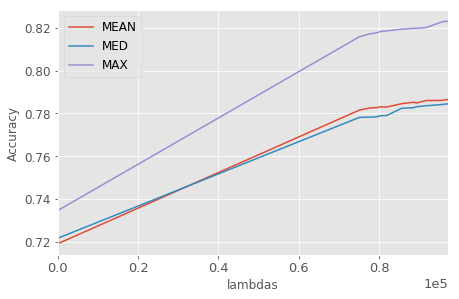

In [19]:
mpl.rcParams['figure.figsize'] = 7,4.5
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

final_acc_grouped_by_lmbda.plot(y=['MEAN','MED','MAX'],x='lambdas')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ylabel('Accuracy')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Some histograms

#### W_2

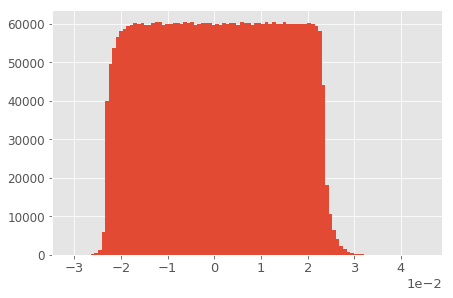

In [20]:
plt.hist(w_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_W_2

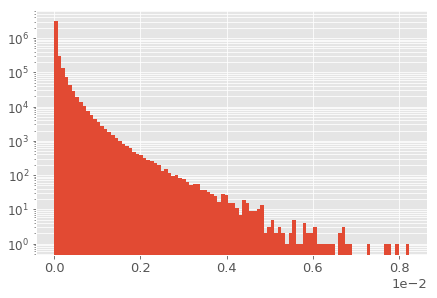

In [21]:
plt.hist(new_big_omeg_w2.flatten(),bins=100,log=True)
#plt.yscale('log')
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_2

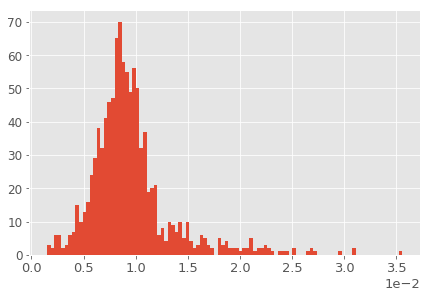

In [23]:
plt.hist(b_2.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### Omega_b_2

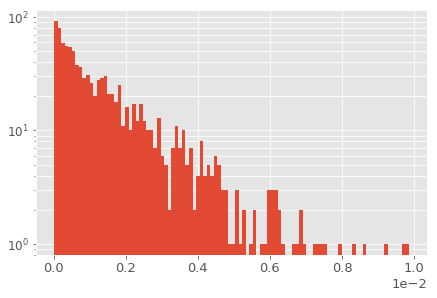

In [24]:
plt.hist(new_big_omeg_b2.flatten(),100,log=True)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### W_3

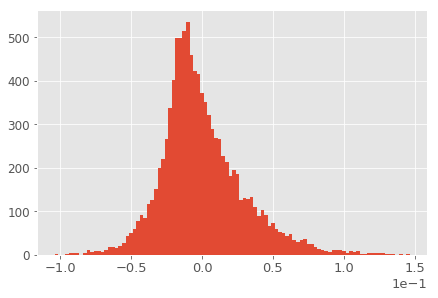

In [22]:
plt.hist(w_3.eval().flatten(), 100)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

#### b_2

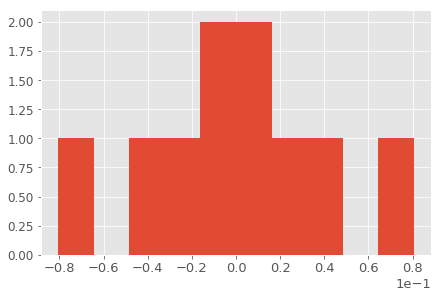

In [25]:
plt.hist(b_3.eval().flatten(), 10)
plt.grid(b=True, which='both', color='w', linestyle='-', alpha=1.0)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()

### Init the writer with $\lambda$s (10.0, 20.0) non-spk classification

In [ ]:
path = '/home/ruthvik/Desktop/Summer 2017/tf_graph_outputs/mnist/continual_learning/original_mnist_5sets'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(path + '/spike_sh_14lmbdas_ar1_3lyrs_he1_10_20-non_spk', sess.graph)

### Generate $\lambda$s

In [27]:
np.random.seed(100)
n_lmbdas = 14
a = np.random.uniform(low=10.0, high=20.0, size=(n_lmbdas,))
print(a)
print()
a = a*1.0e4
a = a[np.argsort(a)]
print(a)
print()
n_reps = 10
a = ([0]+a.tolist())*n_reps
n_lmbdas+=1
print(a, len(a))

[15.43404942 12.78369385 14.24517591 18.44776132 10.04718856 11.21569121
 16.70749085 18.25852755 11.3670659  15.75093329 18.91321954 12.09202122
 11.8532822  11.0837689 ]
()
[100471.8856191  110837.68904643 112156.91207831 113670.6589685
 118532.82195501 120920.21221172 127836.93850938 142451.75907491
 154340.4941791  157509.33294272 167074.90847268 182585.2755105
 184477.61323199 189132.19543123]
()
([0, 100471.88561909726, 110837.68904642553, 112156.91207831142, 113670.65896849529, 118532.8219550075, 120920.21221171896, 127836.93850937962, 142451.7590749133, 154340.49417909654, 157509.33294272498, 167074.90847267784, 182585.27551050478, 184477.6132319904, 189132.1954312264, 0, 100471.88561909726, 110837.68904642553, 112156.91207831142, 113670.65896849529, 118532.8219550075, 120920.21221171896, 127836.93850937962, 142451.7590749133, 154340.49417909654, 157509.33294272498, 167074.90847267784, 182585.27551050478, 184477.6132319904, 189132.1954312264, 0, 100471.88561909726, 110837.68904